In [215]:
import numpy as np
import os
import glob
import pandas as pd
import matplotlib.pyplot as plt
from astropy import units as u
from astropy import constants as const
import ModelFlare_final as mf
import seaborn as sns 
import astropy.coordinates as coord
import matplotlib.colors as mcolors
import matplotlib.cm as cm
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               ScalarFormatter,AutoMinorLocator)
from scipy import stats
import FINDflare as ff
from IPython.display import Image, display
import powerlaw
import FFD_2 as ffd

import matplotlib as mpl


In [2]:
### Plot Settings:
import matplotlib as mpl
plt.style.use('classic')
mpl.rcParams['figure.facecolor'] = 'white'

### Steps for merging the Dataframes

#### Load: 
Id match (df_idxmatch): Contains ZTF ids for each source ('matchid') as given by each field ('unique_matchids_exploded') <br>
Green (df_g19_xmatch): Contains Magnitudes and distances <br>
Gaia (df_xmatch): Contains colors <br>
Stats (df_stats): Flare candidate statistics <br>

#### Combining Data frames:
Id match:
- Find all of the sources with unique_matchids_exploded in our fields
 - There will be some source with ids out of our fields based on grabing with sources within certain coordinates
- Some unique_matchids_exploded will be associated with one matchid, cut to one matchid (delete duplicates)
- Total sources: 124,296,039; In our Fields: 117,484,975, Out of our fields: 6,811,064

Green:
- Drop duplicates of the subset=['matchid','Mr_50','E_50'] since this indicates a duplicated row
- There are still some duplicated sources, since we cant tell which information is correct, anything left that is duplicated on matchid. 

Gaia:
- Drop duplicates of the subset=['matchid','source_id'] since this indicates a duplicated row
- There are still some duplicated sources, since we cant tell which information is correct, anything left that is duplicated on matchid. 


### Looking at the fields

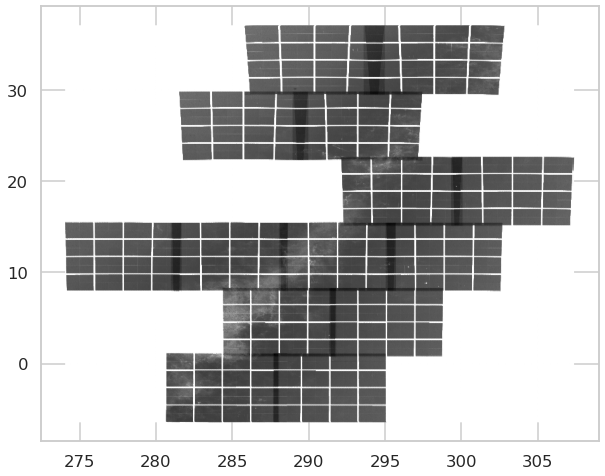

In [144]:
#Sources in our 14 fields with duplicates
fig = plt.figure(figsize=(10,8))
plt.hexbin(infields['ra'],infields['dec'], bins='log', cmap='binary',gridsize=800)

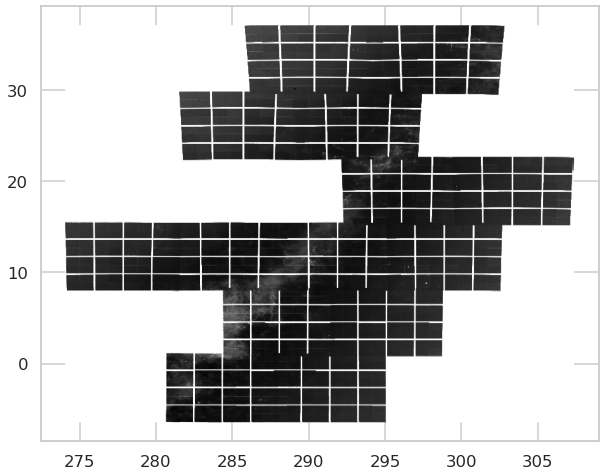

In [147]:
# Sources in our 14 fields without duplicates
fig = plt.figure(figsize=(10,8))
plt.hexbin(nodup_infields['ra'],nodup_infields['dec'], bins='log', cmap='binary',gridsize=800)

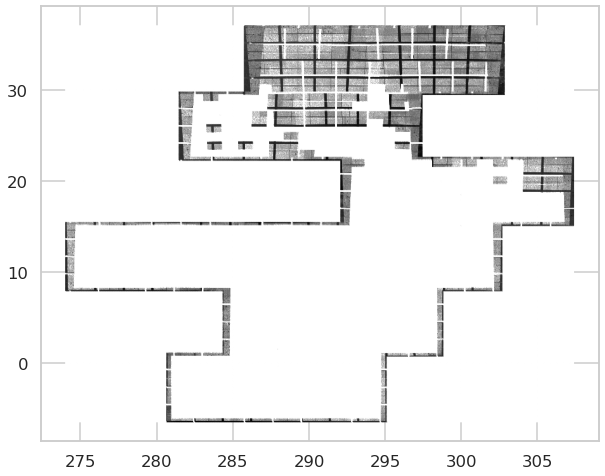

In [145]:
#sources excluded/not in our 14 fields
fig = plt.figure(figsize=(10,8))
plt.hexbin(nodup_other['ra'],nodup_other['dec'], bins='log', cmap='binary',gridsize=800)

### Loading Data

In [3]:
pd.set_option('display.max_columns', 100)

In [4]:
#Reading in ID mapping
df_idxmatch436 = pd.read_parquet('../epyc/users/ecbellm/stellar_flares/matchid_mapping/matchid_map_436.parquet')
df_idxmatch437 = pd.read_parquet('../epyc/users/ecbellm/stellar_flares/matchid_mapping/matchid_map_437.parquet')
df_idxmatch488 = pd.read_parquet('../epyc/users/ecbellm/stellar_flares/matchid_mapping/matchid_map_488.parquet')
df_idxmatch489 = pd.read_parquet('../epyc/users/ecbellm/stellar_flares/matchid_mapping/matchid_map_489.parquet')
df_idxmatch538 = pd.read_parquet('../epyc/users/ecbellm/stellar_flares/matchid_mapping/matchid_map_538.parquet')
df_idxmatch539 = pd.read_parquet('../epyc/users/ecbellm/stellar_flares/matchid_mapping/matchid_map_539.parquet')
df_idxmatch540 = pd.read_parquet('../epyc/users/ecbellm/stellar_flares/matchid_mapping/matchid_map_540.parquet')
df_idxmatch541 = pd.read_parquet('../epyc/users/ecbellm/stellar_flares/matchid_mapping/matchid_map_541.parquet')
df_idxmatch591 = pd.read_parquet('../epyc/users/ecbellm/stellar_flares/matchid_mapping/matchid_map_591.parquet')
df_idxmatch592 = pd.read_parquet('../epyc/users/ecbellm/stellar_flares/matchid_mapping/matchid_map_592.parquet')
df_idxmatch638 = pd.read_parquet('../epyc/users/ecbellm/stellar_flares/matchid_mapping/matchid_map_638.parquet')
df_idxmatch639 = pd.read_parquet('../epyc/users/ecbellm/stellar_flares/matchid_mapping/matchid_map_639.parquet')
df_idxmatch685 = pd.read_parquet('../epyc/users/ecbellm/stellar_flares/matchid_mapping/matchid_map_685.parquet')
df_idxmatch686 = pd.read_parquet('../epyc/users/ecbellm/stellar_flares/matchid_mapping/matchid_map_686.parquet')

In [5]:
idxmatch = [df_idxmatch436, df_idxmatch437,df_idxmatch488,df_idxmatch489,df_idxmatch538,df_idxmatch539,
               df_idxmatch540,df_idxmatch541,df_idxmatch591,df_idxmatch592,df_idxmatch638,df_idxmatch639,
               df_idxmatch685,df_idxmatch686]

df_idxmatch = pd.DataFrame()
for i in idxmatch:
    df_idxmatch = df_idxmatch.append(i)

In [6]:
df_idxmatch['unique_matchids_exploded'] = df_idxmatch['unique_matchids_exploded'].astype(int)

In [7]:
df_idxmatch.head()

matchid          ra       dec  ztf_n_obs  \
0  10435322116782  280.675461 -1.646806          2   
1  10435322156518  280.676054 -1.643882         44   
2  10435322080496  280.676259 -1.647395          2   
3  10435322142211  280.676404 -1.642892          7   
4  10435322042113  280.676568 -1.648677         95   

   exploded_unique_matchids_index  unique_matchids_exploded  
0                               0            10435322116782  
1                               0            10435322156518  
2                               0            10435322080496  
3                               0            10435322142211  
4                               0            10435322042113

In [8]:
def out_fields(df, idtype='unique_matchids_exploded'):
    out_fields = df.loc[(df[idtype] < 10436000000000) | 
                       ((df[idtype] > 10438000000000) & (df[idtype] < 10488000000000)) | 
                       ((df[idtype] > 10490000000000) & (df[idtype] < 10538000000000)) | 
                       ((df[idtype] > 10542000000000) & (df[idtype] < 10591000000000)) |
                       ((df[idtype] > 10593000000000) & (df[idtype] < 10638000000000)) |
                       ((df[idtype] > 10640000000000) & (df[idtype] < 10685000000000)) | 
                       (df[idtype] > 10687000000000)]
    return out_fields

In [9]:
def in_fields(df, idtype='unique_matchids_exploded'):
    in_fields = df.loc[((df[idtype] > 10436000000000) & (df[idtype] < 10437000000000))|
                       ((df[idtype] > 10437000000000) & (df[idtype] < 10438000000000))|
                       ((df[idtype] > 10488000000000) & (df[idtype] < 10489000000000))|
                       ((df[idtype] > 10489000000000) & (df[idtype] < 10490000000000))|
                       ((df[idtype] > 10538000000000) & (df[idtype] < 10539000000000))|
                       ((df[idtype] > 10539000000000) & (df[idtype] < 10540000000000))|
                       ((df[idtype] > 10540000000000) & (df[idtype] < 10541000000000))|
                       ((df[idtype] > 10541000000000) & (df[idtype] < 10542000000000))|
                       ((df[idtype] > 10591000000000) & (df[idtype] < 10592000000000))|
                       ((df[idtype] > 10592000000000) & (df[idtype] < 10593000000000))|
                       ((df[idtype] > 10638000000000) & (df[idtype] < 10639000000000))|
                       ((df[idtype] > 10639000000000) & (df[idtype] < 10640000000000))|
                       ((df[idtype] > 10685000000000) & (df[idtype] < 10686000000000))|
                       ((df[idtype] > 10686000000000) & (df[idtype] < 10687000000000))]
    return in_fields

In [10]:
print('ZTF Cross match:                       {}'.format(len(df_idxmatch)))

infield_id = in_fields(df_idxmatch)
print('ZTF Cross match in our fields:         {} {} Sources dropped: {}'.format(len(infield_id),'\t',len(df_idxmatch)-len(infield_id)))
l = len(infield_id)

infield_id = infield_id.drop_duplicates(subset=['unique_matchids_exploded'])
print('ZTF Cross match no unique duplicate:   {} {} Sources dropped: {}'.format(len(infield_id),'\t',l-len(infield_id)))

df_idxmatch_final = infield_id.drop_duplicates(subset=['matchid'])
print('ZTF Cross match no matchid duplicates: {} {} Sources dropped: {}'.format(len(df_idxmatch_final),'\t',len(infield_id)-len(df_idxmatch_final)))


ZTF Cross match:                       331124679
ZTF Cross match in our fields:         274922405 	 Sources dropped: 56202274
ZTF Cross match no unique duplicate:   203687644 	 Sources dropped: 71234761
ZTF Cross match no matchid duplicates: 117483764 	 Sources dropped: 86203880


### Green 19

In [11]:
#read in green xmatch
df_g19_xmatch436 = pd.read_parquet('../epyc/users/ecbellm/stellar_flares/g19_match/key=436')
df_g19_xmatch437 = pd.read_parquet('../epyc/users/ecbellm/stellar_flares/g19_match/key=437')
df_g19_xmatch488 = pd.read_parquet('../epyc/users/ecbellm/stellar_flares/g19_match/key=488')
df_g19_xmatch489 = pd.read_parquet('../epyc/users/ecbellm/stellar_flares/g19_match/key=489')
df_g19_xmatch538 = pd.read_parquet('../epyc/users/ecbellm/stellar_flares/g19_match/key=538')
df_g19_xmatch539 = pd.read_parquet('../epyc/users/ecbellm/stellar_flares/g19_match/key=539')
df_g19_xmatch540 = pd.read_parquet('../epyc/users/ecbellm/stellar_flares/g19_match/key=540')
df_g19_xmatch541 = pd.read_parquet('../epyc/users/ecbellm/stellar_flares/g19_match/key=541')
df_g19_xmatch591 = pd.read_parquet('../epyc/users/ecbellm/stellar_flares/g19_match/key=591')
df_g19_xmatch592 = pd.read_parquet('../epyc/users/ecbellm/stellar_flares/g19_match/key=592')
df_g19_xmatch638 = pd.read_parquet('../epyc/users/ecbellm/stellar_flares/g19_match/key=638')
df_g19_xmatch639 = pd.read_parquet('../epyc/users/ecbellm/stellar_flares/g19_match/key=639')
df_g19_xmatch685 = pd.read_parquet('../epyc/users/ecbellm/stellar_flares/g19_match/key=685')
df_g19_xmatch686 = pd.read_parquet('../epyc/users/ecbellm/stellar_flares/g19_match/key=686')

In [12]:
g19_xmatch = [df_g19_xmatch436, df_g19_xmatch437,df_g19_xmatch488,df_g19_xmatch489,df_g19_xmatch538,df_g19_xmatch539,
              df_g19_xmatch540,df_g19_xmatch541,df_g19_xmatch591,df_g19_xmatch592,df_g19_xmatch638,df_g19_xmatch639,
              df_g19_xmatch685,df_g19_xmatch686]

df_g19_xmatch = pd.DataFrame()
for i in g19_xmatch:
    df_g19_xmatch = df_g19_xmatch.append(i)

In [13]:
print('Green19 initial dataframe:         {}'.format(len(df_g19_xmatch)))
l = len(df_g19_xmatch)

in_g19  = df_g19_xmatch.loc[df_g19_xmatch['matchid'].isin(df_idxmatch_final['matchid'].values)]
print('Green19 in our fields:             {} {} Sources dropped: {}'.format(len(in_g19),'\t',l-len(in_g19)))
l = len(in_g19)      
      
in_g19 = in_g19.drop_duplicates(subset=['matchid','Mr_50','E_50'])
print('Green19 without duplicated rows:   {} {} Sources dropped: {}'.format(len(in_g19),'\t',l-len(in_g19)))
l = len(in_g19)

in_g19 = in_g19.drop_duplicates(subset=['matchid'],keep=False)
print('Green19 drop duplicated matchids:  {} {} Sources dropped: {}'.format(len(in_g19),'\t',l-len(in_g19)))


Green19 initial dataframe:         102842952
Green19 in our fields:             97777053 	 Sources dropped: 5065899
Green19 without duplicated rows:   88614594 	 Sources dropped: 9162459
Green19 drop duplicated matchids:  88613424 	 Sources dropped: 1170


In [14]:
in_g19.head()

matchid          ra       dec      dm_16      E_16     Mr_16  \
164  10435322041675  280.736522 -1.640029  12.786213  1.447466 -0.650000   
166  10436452106893  280.736984 -1.645828  13.219912  2.338836 -0.700000   
167  10436452090664  280.737412 -1.638352  12.137952  1.067027  2.900000   
168  10436452090826  280.737900 -1.645239  12.216832  1.132333  2.325815   
169  10435321030659  280.738014 -1.639648  14.455332  1.062928  0.150000   

     FeH_16      dm_50      E_50  Mr_50  FeH_50      dm_84      E_84  \
164   -0.60  13.221683  1.488789  -0.05   -0.40  13.881721  1.518137   
166   -0.65  13.783600  2.387797  -0.05   -0.45  14.578032  2.440438   
167   -0.65  13.669180  1.283856   3.75   -0.40  14.737309  1.390710   
168   -0.60  13.443861  1.222633   3.05   -0.40  14.408951  1.313863   
169   -0.70  15.236265  1.107947   0.50   -0.50  15.624356  1.154388   

        Mr_84  FeH_84              gaia_id  
164  0.324185   -0.15  4259944900029527680  
166  0.450000   -0.20  4259944895729914240  
167  6.000000   -0.20                    0  
168  4.100000   -0.20                    0  
169  1.150000   -0.30  4259944895724338816

### Gaia

In [15]:
#Reading in Gaia
df_xmatch436 = pd.read_parquet('../epyc/users/ecbellm/stellar_flares/gaia_match/key=436')
df_xmatch437 = pd.read_parquet('../epyc/users/ecbellm/stellar_flares/gaia_match/key=437')
df_xmatch488 = pd.read_parquet('../epyc/users/ecbellm/stellar_flares/gaia_match/key=488')
df_xmatch489 = pd.read_parquet('../epyc/users/ecbellm/stellar_flares/gaia_match/key=489')
df_xmatch538 = pd.read_parquet('../epyc/users/ecbellm/stellar_flares/gaia_match/key=538')
df_xmatch539 = pd.read_parquet('../epyc/users/ecbellm/stellar_flares/gaia_match/key=539')
df_xmatch540 = pd.read_parquet('../epyc/users/ecbellm/stellar_flares/gaia_match/key=540')
df_xmatch541 = pd.read_parquet('../epyc/users/ecbellm/stellar_flares/gaia_match/key=541')
df_xmatch591 = pd.read_parquet('../epyc/users/ecbellm/stellar_flares/gaia_match/key=591')
df_xmatch592 = pd.read_parquet('../epyc/users/ecbellm/stellar_flares/gaia_match/key=592')
df_xmatch638 = pd.read_parquet('../epyc/users/ecbellm/stellar_flares/gaia_match/key=638')
df_xmatch639 = pd.read_parquet('../epyc/users/ecbellm/stellar_flares/gaia_match/key=639')
df_xmatch685 = pd.read_parquet('../epyc/users/ecbellm/stellar_flares/gaia_match/key=685')
df_xmatch686 = pd.read_parquet('../epyc/users/ecbellm/stellar_flares/gaia_match/key=686')

In [16]:
xmatch = [df_xmatch436, df_xmatch437, df_xmatch488, df_xmatch489, df_xmatch538, df_xmatch539, df_xmatch540, 
          df_xmatch541, df_xmatch591, df_xmatch592, df_xmatch638, df_xmatch639, df_xmatch685, df_xmatch686]

df_xmatch = pd.DataFrame()
for i in xmatch:
    df_xmatch = df_xmatch.append(i)

In [17]:
df_xmatch.head()

matchid          ra       dec            source_id     bp_rp  \
0  10435322156518  280.676054 -1.643882  4260126628669270656  1.802952   
1  10435322080496  280.676259 -1.647395  4260126628669245952  2.242176   
2  10435322142211  280.676404 -1.642892  4260126830543756544  2.869312   
3  10435322042113  280.676568 -1.648677  4260126624385214080  2.158577   
4  10435322142026  280.677176 -1.635635  4260126937906960640  2.379248   

   phot_g_mean_mag  phot_g_mean_flux_over_error  phot_bp_mean_mag  \
0        19.529078                   182.307449         19.999294   
1        20.573723                    73.060173         20.919231   
2        20.581446                    79.545486         21.304731   
3        18.975090                   276.302887         19.907875   
4        20.254824                   113.621567         20.957420   

   phot_rp_mean_mag  a_g_val  parallax  parallax_error  lum_val       axsdist  
0         18.196342      NaN -0.095662        0.409760      NaN  4.600729e-07  
1         18.677055      NaN -0.793990        1.051409      NaN  5.051085e-07  
2         18.435419      NaN -1.044307        1.244409      NaN  2.341685e-06  
3         17.749298      NaN  0.779127        0.266000      NaN  6.010644e-07  
4         18.578173      NaN -0.494582        0.742402      NaN  5.310926e-07

In [18]:
print('Gaia initial dataframe:         {}'.format(len(df_xmatch)))
l = len(df_xmatch)

in_gaia  = df_xmatch.loc[df_xmatch['matchid'].isin(df_idxmatch_final['matchid'].values)]
print('Gaia in our fields:             {} {} Sources dropped: {}'.format(len(in_gaia),'\t',l-len(in_gaia)))
l = len(in_gaia)      
      
in_gaia = in_gaia.drop_duplicates(subset=['matchid','source_id'])
print('Gaia without duplicated rows:   {} {} Sources dropped: {}'.format(len(in_gaia),'\t',l-len(in_gaia)))
l = len(in_gaia)

in_gaia = in_gaia.drop_duplicates(subset=['matchid'],keep=False)
print('Gaia drop duplicated matchids:  {} {} Sources dropped: {}'.format(len(in_gaia),'\t',l-len(in_gaia)))


Gaia initial dataframe:         110685479
Gaia in our fields:             105276179 	 Sources dropped: 5409300
Gaia without duplicated rows:   95432501 	 Sources dropped: 9843678
Gaia drop duplicated matchids:  95381709 	 Sources dropped: 50792


### Relavent papers for referance 
Paper describing Green19 data: https://arxiv.org/pdf/1905.02734.pdf
<br>Paper describing Pan-STARRS1 which is used in Green19: https://arxiv.org/pdf/1203.0297.pdf

In [19]:
stats_436 = pd.read_csv('found_flares_436/stats2_ztf_000436.csv')
stats_437 = pd.read_csv('found_flares_437/stats2_ztf_000437.csv')
stats_488 = pd.read_csv('found_flares_488/stats2_ztf_000488.csv')
stats_489 = pd.read_csv('found_flares_489/stats2_ztf_000489.csv')
stats_538 = pd.read_csv('found_flares_538/stats2_ztf_000538.csv')
stats_539 = pd.read_csv('found_flares_539/stats2_ztf_000539.csv')
stats_540 = pd.read_csv('found_flares_540/stats2_ztf_000540.csv')
stats_541 = pd.read_csv('found_flares_541/stats2_ztf_000541.csv')
stats_591 = pd.read_csv('found_flares_591/stats2_ztf_000591.csv')
stats_592 = pd.read_csv('found_flares_592/stats2_ztf_000592.csv')
stats_638 = pd.read_csv('found_flares_638/stats2_ztf_000638.csv')
stats_639 = pd.read_csv('found_flares_639/stats2_ztf_000639.csv')
stats_685 = pd.read_csv('found_flares_685/stats2_ztf_000685.csv')
stats_686 = pd.read_csv('found_flares_686/stats2_ztf_000686.csv')

stats = [stats_436, stats_437, stats_488, stats_489, stats_538, stats_539, stats_540, 
         stats_541, stats_591, stats_592, stats_638, stats_639, stats_685, stats_686]

df_stats2 = pd.DataFrame()
for i in stats:
    df_stats2 = df_stats2.append(i)


In [20]:
stats3_436 = pd.read_csv('stats/stats_sept2020/stats_436.csv')
stats3_437 = pd.read_csv('stats/stats_sept2020/stats_437.csv')
stats3_488 = pd.read_csv('stats/stats_sept2020/stats_488.csv')
stats3_489 = pd.read_csv('stats/stats_sept2020/stats_489.csv')
stats3_538 = pd.read_csv('stats/stats_sept2020/stats_538.csv')
stats3_539 = pd.read_csv('stats/stats_sept2020/stats_539.csv')
stats3_540 = pd.read_csv('stats/stats_sept2020/stats_540.csv')
stats3_541 = pd.read_csv('stats/stats_sept2020/stats_541.csv')
stats3_591 = pd.read_csv('stats/stats_sept2020/stats_591.csv')
stats3_592 = pd.read_csv('stats/stats_sept2020/stats_592.csv')
stats3_638 = pd.read_csv('stats/stats_sept2020/stats_638.csv')
stats3_639 = pd.read_csv('stats/stats_sept2020/stats_639.csv')
stats3_685 = pd.read_csv('stats/stats_sept2020/stats_685.csv')
stats3_686 = pd.read_csv('stats/stats_sept2020/stats_686.csv')

stats3 = [stats3_436, stats3_437, stats3_488, stats3_489, stats3_538, stats3_539, stats3_540, 
          stats3_541, stats3_591, stats3_592, stats3_638, stats3_639, stats3_685, stats3_686]

df_stats3 = pd.DataFrame()
for i in stats3:
    df_stats3 = df_stats3.append(i)



In [21]:
df_stats = pd.read_csv('stats_final.csv', header=None)

In [22]:
df_stats = pd.DataFrame(df_stats.values, columns = ["match_file", "axs_id", "AIC_f", "chisq_f", "dof_f", "red_f", 
                                                    "AIC_g", "chisq_g", "dof_g", "red_g", "compare_exp", "compare_per", "n_obs"])
#df_stats = df_stats[['axs_id','n_obs']]
#df_stats['axs_id'] = df_stats['axs_id'].astype(int)

### AXS ID's from the ztf data

In [23]:
def quad_ccd_to_rc(quadrant, ccd):
    b = 4 * (ccd - 1)
    rc = b + quadrant - 1
    return rc
    
def axs_id(df):
    df = df.reset_index(drop=True)
    axs_id = []
    for i in range(len(df)):
        field = df['match_file'][i].split('_')[1][3:]
        quadrant = df['match_file'][i].split('_')[4][1]
        ccd = df['match_file'][i].split('_')[3][1:]
        rc = quad_ccd_to_rc(int(quadrant),int(ccd))
        field = str(field).zfill(4)
        rc = str(rc).zfill(2)
        idztf = str(df['id'][i]).zfill(6)
        axs_id_new = '1'  + field + rc + '2'  + idztf
        axs_id.append(axs_id_new)
        #matchid_prefix_string = "{:04}{:02}".format(field,rc)
    print(len(axs_id), len(df))
    df['axs_id'] = axs_id
    return df

In [24]:
df_statsid = axs_id(df_stats3)

df_statsid['axs_id'] = df_statsid['axs_id'].astype(int)
print('Stats initial dataframe:         {}'.format(len(df_statsid)))

df_statsid = df_statsid.drop_duplicates(subset=['match_file','id','axs_id','fwhm'])
print('Stats Drop Duplicates:           {}'.format(len(df_statsid)))

df_statsid = pd.merge(df_statsid, infield_id, how='inner',left_on='axs_id', right_on='unique_matchids_exploded')
print('Stats with ids:                  {}'.format(len(df_statsid)))


15285 15285
Stats initial dataframe:         15285
Stats Drop Duplicates:           15276
Stats with ids:                  15262


In [25]:
flare_candidate = df_statsid

In [26]:
flare_candidate.head()

Unnamed: 0                            match_file      id  median_flux  \
0           0  ztf_000436_zr_c01_q1_match_programid   33146   292.851654   
1           0  ztf_000436_zr_c01_q1_match_programid   98283   339.191376   
2           0  ztf_000436_zr_c01_q1_match_programid  103617   629.161743   
3           0  ztf_000436_zr_c01_q1_match_programid  152114   593.687256   
4           0  ztf_000436_zr_c01_q2_match_programid    1676  2315.598389   

   median_mag    start_time      end_time  duration    peak_flux  \
0   19.902313  58348.314410  58348.327280  0.012870   527.598572   
1   19.747164  58348.234896  58348.270313  0.035417   749.397095   
2   19.084631  58348.239016  58348.270313  0.031296   945.604797   
3   19.173532  58348.228009  58348.272153  0.044144   760.596619   
4   17.784891  58348.319919  58348.327280  0.007361  2957.102051   

      peak_time  peak_flux_index  frac_increase      fwhm    equivdur  \
0  58348.319456              195       0.801590  0.005248  326.869777   
1  58348.240405              111       1.209364  0.006197  685.576870   
2  58348.244074              108       0.502960  0.005366  262.208678   
3  58348.235347               17       0.281140  0.007639  187.728941   
4  58348.325440              210       0.277036  0.005572  130.180702   

   equivdur_err  peak_to_start_time  peak_to_end_time      st_dev  \
0      0.000582            0.099248          0.007824   49.706280   
1      0.001045            0.020197          0.086875   76.430138   
2      0.000523            0.023866          0.083206   57.871197   
3      0.000623            0.015139          0.091933   47.799683   
4      0.000135            0.105231          0.001840  141.651794   

   ave_flux_err  rel_ave_flux_err  ave_flux_err_flare  rel_ave_flux_err_flare  \
0     37.663589          0.128610           42.778687                0.146076   
1     38.013580          0.112071           45.241775                0.133381   
2     46.636226          0.074124           52.761091                0.083859   
3     48.623968          0.081902           51.763412                0.087190   
4     91.378173          0.039462          133.251031                0.057545   

   med_flux_err  rel_med_flux_err  med_flux_err_flare  rel_med_flux_err_flare  \
0     36.624847          0.125063           38.781239                0.132426   
1     36.578445          0.107840           40.406799                0.119127   
2     44.868111          0.071314           54.432487                0.086516   
3     49.527851          0.083424           52.231209                0.087978   
4     90.092163          0.038907          119.838028                0.051753   

                 fl_indx                                            isflare  \
0      [194 195 196 197]  [190 191 192 193 194 195 196 197 198 199 200 2...   
1      [109 110 111 112]  [107 108 109 110 111 112 113 114 115 116 117 1...   
2  [106 107 108 109 110]  [103 104 105 106 107 108 109 110 111 112 113 1...   
3             [15 16 17]  [ 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 ...   
4  [207 208 209 210 211]              [204 205 206 207 208 209 210 211 212]   

   width_flag  AIC_flare  loglike_flare  chisq_err_flare  chisq_exp_flare  \
0           0  19.163043      -5.581522        11.163043        59.907850   
1           0  66.756076     -29.378038        58.756075       293.210657   
2           0  41.238558     -16.619279        33.238558       122.485465   
3           0  24.947135      -8.473568        16.947135        70.887416   
4           2  10.753046      -1.376523         2.753046        30.509333   

   dof_flare  AIC_gauss  loglike_gauss  chisq_err_gauss  chisq_exp_gauss  \
0         11  14.441549      -3.220775         6.441549        26.317856   
1         30  30.136322     -11.068161        22.136321        95.466383   
2         31  23.774583      -7.887291        15.774583        62.219869   
3         44  24.956582      -8.478291        16.956582        70.6

This is the copied three coloums that did not have an ID associated with them


ztf_000592_zr_c15_q1_match_programid	130585.0	90.722491	82.722491	42.0	1.969583	35.689618	27.689618	42.0	0.659277	1.121408e-12	-55.032873	[2 3 4 5]	837.882703	302.889072	22.717313	1358.023	4.104	58343.192917	58344.298495	1.100949	0.0	1.059256e+13
331125879	NaN	NaN	NaN	NaN	NaN	ztf_000592_zr_c15_q2_match_programid	51414.0	88.951413	80.951412	29.0	2.791428	78.701628	70.701627	29.0	2.437987	5.946857e-03	-10.249785	[88 89 90]	173.840742	301.555095	22.703380	2668.761	26.261	58343.271956	58344.298495	1.024653	0.0	1.059257e+13
331125880	NaN	NaN	NaN	NaN	NaN	ztf_000592_zr_c16_q1_match_programid	170214.0	63.309302	55.309302	42.0	1.316888	52.240425	44.240424	42.0	1.053343	3.948423e-03	-11.068878	[4 5 6]	178.101501	301.247999	22.704589	145.031	10.198	58343.194768	58344.298495	1.100023	0.0	1.059260e+13

### Connecting Green and Gaia

In [27]:
print('Green:                  {}'.format(len(in_g19))) 
print('Gaia:                   {}'.format(len(in_gaia)))

green_gaia = pd.merge(in_gaia, in_g19, how='inner', on='matchid')
print('Green and Gaia:         {}'.format(len(green_gaia)))
l = len(green_gaia)      

green_gaia = green_gaia.drop(columns=['ra_y', 'dec_y'])
green_gaia = green_gaia.rename(columns={"ra_x": "ra", "dec_x": "dec"})

green_gaia = pd.merge(df_idxmatch_final, green_gaia, how='inner', on='matchid')
print('GreenGaia and Ids:      {} {} Sources dropped: {}'.format(len(green_gaia),'\t',l-len(green_gaia)))
l = len(green_gaia)      


green_gaia = green_gaia.drop_duplicates(subset=['matchid'])
print('GreenGaia no duplicates:{} {} Sources dropped: {}'.format(len(green_gaia),'\t',l-len(green_gaia)))

green_gaia = green_gaia.drop(columns=['ra_y', 'dec_y'])
green_gaia = green_gaia.rename(columns={"ra_x": "ra", "dec_x": "dec"})


Green:                  88613424
Gaia:                   95381709
Green and Gaia:         82519876
GreenGaia and Ids:      82519876 	 Sources dropped: 0
GreenGaia no duplicates:82519876 	 Sources dropped: 0


In [28]:
green_gaia.head()

matchid          ra       dec  ztf_n_obs  \
0  10435322041675  280.736522 -1.640029        321   
1  10436452106893  280.736984 -1.645828        222   
2  10436452090664  280.737412 -1.638352         64   
3  10436452090826  280.737900 -1.645239        256   
4  10435321030659  280.738014 -1.639648        305   

   exploded_unique_matchids_index  unique_matchids_exploded  \
0                               0            10436452090705   
1                               1            10436452106893   
2                               0            10436452090664   
3                               0            10436452090826   
4                               0            10436452069857   

             source_id     bp_rp  phot_g_mean_mag  \
0  4259944900029527680  3.007269        16.502338   
1  4259944895729914240  3.453453        18.853180   
2  4259944900022336896  1.644081        20.750038   
3  4259944900029520768  2.255081        19.594051   
4  4259944895724338816  2.373930        18.318356   

   phot_g_mean_flux_over_error  phot_bp_mean_mag  phot_rp_mean_mag  a_g_val  \
0                   866.481750         18.203699         15.196430      NaN   
1                   254.587051         20.670853         17.217400      NaN   
2                    68.857285         20.868034         19.223953      NaN   
3                   101.868973         20.405462         18.150381      NaN   
4                   432.433960         19.474213         17.100283      NaN   

   parallax  parallax_error  lum_val       axsdist      dm_16      E_16  \
0  0.303958        0.086633      NaN  4.427031e-07  12.786213  1.447466   
1  0.116429        0.347367      NaN  7.606656e-07  13.219912  2.338836   
2 -3.250213        1.766830      NaN  5.226893e-07  12.137952  1.067027   
3 -1.881356        0.769361      NaN  4.395588e-07  12.216832  1.132333   
4  0.003495        0.176869      NaN  4.391800e-07  14.455332  1.062928   

      Mr_16  FeH_16      dm_50      E_50  Mr_50  FeH_50      dm_84      E_84  \
0 -0.650000   -0.60  13.221683  1.488789  -0.05   -0.40  13.881721  1.518137   
1 -0.700000   -0.65  13.783600  2.387797  -0.05   -0.45  14.578032  2.440438   
2  2.900000   -0.65  13.669180  1.283856   3.75   -0.40  14.737309  1.390710   
3  2.325815   -0.60  13.443861  1.222633   3.05   -0.40  14.408951  1.313863   
4  0.150000   -0.70  15.236265  1.107947   0.50   -0.50  15.624356  1.154388   

      Mr_84  FeH_84              gaia_id  
0  0.324185   -0.15  4259944900029527680  
1  0.450000   -0.20  4259944895729914240  
2  6.000000   -0.20                    0  
3  4.100000   -0.20                    0  
4  1.150000   -0.30  4259944895724338816

### Connecting Flare with Green&Gaia:

In [29]:
print('Flares Candidates:                  {}'.format(len(flare_candidate))) 

stats_gaia = pd.merge(flare_candidate, green_gaia, how='inner', left_on='matchid',right_on='matchid')
print('Flare with gaia:                    {}'.format(len(stats_gaia))) 

stats_gaia = stats_gaia.drop_duplicates(subset=['Mr_50','matchid','source_id'])
print('Flare with gaia drop duplicates:    {}'.format(len(stats_gaia))) 

stats_gaia = stats_gaia.drop(columns=['ra_y', 'dec_y','ztf_n_obs_y','exploded_unique_matchids_index_y','unique_matchids_exploded_y'])
stats_gaia = stats_gaia.rename(columns={'ra_x': 'ra', 'dec_x': 'dec','ztf_n_obs_x':'ztf_n_obs',
                                        'exploded_unique_matchids_index_x':'exploded_unique_matchids_index',
                                        'unique_matchids_exploded_x':'unique_matchids_exploded'})


Flares Candidates:                  15262
Flare with gaia:                    13403
Flare with gaia drop duplicates:    12411


In [30]:
stats_gaia.head()

Unnamed: 0                            match_file      id  median_flux  \
0           0  ztf_000436_zr_c01_q1_match_programid   33146   292.851654   
1           0  ztf_000436_zr_c01_q1_match_programid   98283   339.191376   
2           0  ztf_000436_zr_c01_q1_match_programid  103617   629.161743   
3           0  ztf_000436_zr_c01_q1_match_programid  152114   593.687256   
4           0  ztf_000436_zr_c01_q2_match_programid    1676  2315.598389   

   median_mag    start_time      end_time  duration    peak_flux  \
0   19.902313  58348.314410  58348.327280  0.012870   527.598572   
1   19.747164  58348.234896  58348.270313  0.035417   749.397095   
2   19.084631  58348.239016  58348.270313  0.031296   945.604797   
3   19.173532  58348.228009  58348.272153  0.044144   760.596619   
4   17.784891  58348.319919  58348.327280  0.007361  2957.102051   

      peak_time  peak_flux_index  frac_increase      fwhm    equivdur  \
0  58348.319456              195       0.801590  0.005248  326.869777   
1  58348.240405              111       1.209364  0.006197  685.576870   
2  58348.244074              108       0.502960  0.005366  262.208678   
3  58348.235347               17       0.281140  0.007639  187.728941   
4  58348.325440              210       0.277036  0.005572  130.180702   

   equivdur_err  peak_to_start_time  peak_to_end_time      st_dev  \
0      0.000582            0.099248          0.007824   49.706280   
1      0.001045            0.020197          0.086875   76.430138   
2      0.000523            0.023866          0.083206   57.871197   
3      0.000623            0.015139          0.091933   47.799683   
4      0.000135            0.105231          0.001840  141.651794   

   ave_flux_err  rel_ave_flux_err  ave_flux_err_flare  rel_ave_flux_err_flare  \
0     37.663589          0.128610           42.778687                0.146076   
1     38.013580          0.112071           45.241775                0.133381   
2     46.636226          0.074124           52.761091                0.083859   
3     48.623968          0.081902           51.763412                0.087190   
4     91.378173          0.039462          133.251031                0.057545   

   med_flux_err  rel_med_flux_err  med_flux_err_flare  rel_med_flux_err_flare  \
0     36.624847          0.125063           38.781239                0.132426   
1     36.578445          0.107840           40.406799                0.119127   
2     44.868111          0.071314           54.432487                0.086516   
3     49.527851          0.083424           52.231209                0.087978   
4     90.092163          0.038907          119.838028                0.051753   

                 fl_indx                                            isflare  \
0      [194 195 196 197]  [190 191 192 193 194 195 196 197 198 199 200 2...   
1      [109 110 111 112]  [107 108 109 110 111 112 113 114 115 116 117 1...   
2  [106 107 108 109 110]  [103 104 105 106 107 108 109 110 111 112 113 1...   
3             [15 16 17]  [ 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 ...   
4  [207 208 209 210 211]              [204 205 206 207 208 209 210 211 212]   

   width_flag  AIC_flare  loglike_flare  chisq_err_flare  chisq_exp_flare  \
0           0  19.163043      -5.581522        11.163043        59.907850   
1           0  66.756076     -29.378038        58.756075       293.210657   
2           0  41.238558     -16.619279        33.238558       122.485465   
3           0  24.947135      -8.473568        16.947135        70.887416   
4           2  10.753046      -1.376523         2.753046        30.509333   

   dof_flare  AIC_gauss  loglike_gauss  chisq_err_gauss  chisq_exp_gauss  \
0         11  14.441549      -3.220775         6.441549        26.317856   
1         30  30.136322     -11.068161        22.136321        95.466383   
2         31  23.774583      -7.887291        15.774583        62.219869   
3         44  24.956582      -8.478291        16.956582        70.6

### Now determine which of the candidates are flares:

with pd.option_context('mode.use_inf_as_null', True):
    exp_comp = stats_green['exp_comp'].dropna()
len(exp_comp) # only 4 have inf values

AIC exponential comparison is $$e^{\frac{AIC_{flare} - AIC_{gauss}}{2}}$$
The value it gives mean how many times as probable the gauss model is to the flare model. An example being the comparison values is 0.5, meaning the gauss model us 1/2 as likely as the flare. Anything above 1 means gauss is more likely.

The given value to beat is $e^{-2}$ = 0.135

This value which was given in the wiki article, 'the e−2 likelihood interval is the same as the 0.954 confidence interval'

https://en.wikipedia.org/wiki/Likelihood_function#Likelihood_ratio_and_relative_likelihood

comp = np.exp((stats_gaia['aic_flare']-stats_gaia['aic_gauss'])/2)

with pd.option_context('mode.use_inf_as_null', True):
    comp = comp.dropna()
len(comp) # only 4 have inf values

plt.hist(comp.loc[comp.values<1])
print(len(comp.loc[comp.values<.05]))

plt.hist(flares['flare_end_diff'], bins=100)

#flares = stats_green.loc[np.exp((stats_green['aic_flare']-stats_green['aic_gauss'])/2) < np.exp(-2)]
flaretimelim = flare_candidate.loc[flare_candidate['flare_end_diff'].astype(float) < 0.005]
flaretimelim

In [ ]:
plt.hist(stats_gaia['equivdur'], log=True)

### Converting to Galactic Coordinates

The galactic coordinates are $(l,b)$. $l$ is the angle clockwise away from the galactic center. $b$ is the angle away from the galactic plan. Using angle $b$ and the distant modulus, I used sin($b$) = height about the galactiv plane / distant modulus or: height = $dm$sin($b$)

In [31]:
def galactic_centric_coords(df):
    dist_pc = 10 ** ((df['dm_50'] +5) / 5)

    c = coord.ICRS(ra=df['ra'].values*u.degree, 
                   dec=df['dec'].values*u.degree, 
                   distance=dist_pc.values*u.pc)
    galactic = c.transform_to(coord.Galactocentric)     
    print(galactic)
    df['gal_x'] = galactic.x.value
    df['gal_y'] = galactic.y.value
    df['gal_z'] = galactic.z.value
    df['abs_gal_z'] = abs(galactic.z.value)
    df['gal_r'] = (galactic.x.value**2 + galactic.y.value**2)**.5
    
    
    return df

In [32]:
stats_gaia = galactic_centric_coords(stats_gaia)
green_gaia = galactic_centric_coords(green_gaia)


<Galactocentric Coordinate (galcen_coord=<ICRS Coordinate: (ra, dec) in deg
    (266.4051, -28.936175)>, galcen_distance=8.3 kpc, galcen_v_sun=(11.1, 232.24, 7.25) km / s, z_sun=27.0 pc, roll=0.0 deg): (x, y, z) in pc
    [(-5946.36744505, 1381.26509676, -285.6291864 ),
     (-6302.80957451, 1183.83670241, -243.03171866),
     (-6114.78062121, 1283.04000614, -263.13682623), ...,
     (-5814.46824086, 6880.29102643,  784.9182662 ),
     (-5884.09473988, 6521.12572646,  807.83511836),
     (-6764.50167654, 4199.08773094,  534.23437624)]>


<Galactocentric Coordinate (galcen_coord=<ICRS Coordinate: (ra, dec) in deg
    (266.4051, -28.936175)>, galcen_distance=8.3 kpc, galcen_v_sun=(11.1, 232.24, 7.25) km / s, z_sun=27.0 pc, roll=0.0 deg): (x, y, z) in pc
    [(-4501.70035971, 2237.53021979, 102.41396273),
     (-3379.67345608, 2897.93802053, 124.38085934),
     (-3632.5564263 , 2749.74615611, 119.67045059), ...,
     (-7823.42514134, 1493.4978023 ,  43.68890436),
     (-6789.05457109, 4734.57816635,  79.75359452),
     (-7537.88734219, 2388.63371687,  53.69141512)]>


In [33]:
green_gaia.head()

matchid          ra       dec  ztf_n_obs  \
0  10435322041675  280.736522 -1.640029        321   
1  10436452106893  280.736984 -1.645828        222   
2  10436452090664  280.737412 -1.638352         64   
3  10436452090826  280.737900 -1.645239        256   
4  10435321030659  280.738014 -1.639648        305   

   exploded_unique_matchids_index  unique_matchids_exploded  \
0                               0            10436452090705   
1                               1            10436452106893   
2                               0            10436452090664   
3                               0            10436452090826   
4                               0            10436452069857   

             source_id     bp_rp  phot_g_mean_mag  \
0  4259944900029527680  3.007269        16.502338   
1  4259944895729914240  3.453453        18.853180   
2  4259944900022336896  1.644081        20.750038   
3  4259944900029520768  2.255081        19.594051   
4  4259944895724338816  2.373930        18.318356   

   phot_g_mean_flux_over_error  phot_bp_mean_mag  phot_rp_mean_mag  a_g_val  \
0                   866.481750         18.203699         15.196430      NaN   
1                   254.587051         20.670853         17.217400      NaN   
2                    68.857285         20.868034         19.223953      NaN   
3                   101.868973         20.405462         18.150381      NaN   
4                   432.433960         19.474213         17.100283      NaN   

   parallax  parallax_error  lum_val       axsdist      dm_16      E_16  \
0  0.303958        0.086633      NaN  4.427031e-07  12.786213  1.447466   
1  0.116429        0.347367      NaN  7.606656e-07  13.219912  2.338836   
2 -3.250213        1.766830      NaN  5.226893e-07  12.137952  1.067027   
3 -1.881356        0.769361      NaN  4.395588e-07  12.216832  1.132333   
4  0.003495        0.176869      NaN  4.391800e-07  14.455332  1.062928   

      Mr_16  FeH_16      dm_50      E_50  Mr_50  FeH_50      dm_84      E_84  \
0 -0.650000   -0.60  13.221683  1.488789  -0.05   -0.40  13.881721  1.518137   
1 -0.700000   -0.65  13.783600  2.387797  -0.05   -0.45  14.578032  2.440438   
2  2.900000   -0.65  13.669180  1.283856   3.75   -0.40  14.737309  1.390710   
3  2.325815   -0.60  13.443861  1.222633   3.05   -0.40  14.408951  1.313863   
4  0.150000   -0.70  15.236265  1.107947   0.50   -0.50  15.624356  1.154388   

      Mr_84  FeH_84              gaia_id        gal_x        gal_y  \
0  0.324185   -0.15  4259944900029527680 -4501.700360  2237.530220   
1  0.450000   -0.20  4259944895729914240 -3379.673456  2897.938021   
2  6.000000   -0.20                    0 -3632.556426  2749.746156   
3  4.100000   -0.20                    0 -4092.321413  2478.297309   
4  1.150000   -0.30  4259944895724338816  1305.019058  5658.465684   

        gal_z   abs_gal_z        gal_r  
0  102.413963  102.413963  5027.111259  
1  124.380859  124.380859  4451.992525  
2  119.670451  119.670451  4555.937896  
3  110.230770  110.230770  4784.250421  
4  217.483797  217.483797  5807.005135

### To determine the luminosity inorder to get the equivduration 

This equation was created for gaia fluxes by Jim

def LUM(gflux, plx, zp='AB', mag='G'):
    #from https://www.cosmos.esa.int/web/gaia/iow_20180316
    G0 = 25.7915509947 # AB_ZP mag

    #from Table 5.4: https://gea.esac.esa.int/archive/documentation/GDR2/Data_processing/chap_cu5pho
    #/sec_cu5pho_calibr/ssec_cu5pho_calibr_extern.html
    lp = 623.06 * u.nm # pivot wavelength of G filter

    m_G = -2.5 * np.log10(gflux) + G0
    F_AB_JY = 3631 * 10**(-0.4 * m_G)
    F_AB = F_AB_JY  * 1e-23 * u.erg/u.s/u.cm/u.cm/u.Hz

    dist = (1000./plx) * u.pc
    L = ((F_AB * dist**2) * (const.c/lp).to('Hz')).to(u.erg / u.s)
    return L.value

#And then you can call it like this:
LL = LUM(gaialim['phot_g_mean_flux'].values, gaialim['parallax'].values)

### How to get luminosity:

$$dm = m - M = 5 log(d) - 5$$
$$dm = m - M = 5 log(d) - 5 + A$$
$$M_2 - M_1 = 2.5 log(f_1 /f_2)$$
$$L = f 4 \pi d^2$$


<br> This is the paper for Pan-STARRS1: https://arxiv.org/pdf/1203.0297.pdf. It describes the use and equations of the AB magnitude system. It also gives the Pivot Wavelength for the r band as: 617nm

(The AB mag system is originally found in http://articles.adsabs.harvard.edu/cgi-bin/nph-iarticle_query?1983ApJ...266..713O&amp;data_type=PDF_HIGH&amp;whole_paper=YES&amp;type=PRINTER&amp;filetype=.pdf)

$$m_{ab}(v) = −2.5 log(f_ν/3631 Jy)$$
$$m_{ab}(v) = −48.600 − 2.5 log(f_ν[erg/sec/cm2/Hz]) $$

Solve for flux 

<br> So for if we plug in the absolute magnituded given by G19 we will get the flux at 10 parsec
<br> Rearanged for flux the equation is:
$$f_{10pc} = 10 ^ {\frac{M + 48.6}{-2.5}}$$

<br> This gives the flux based on frequency. We need it to be based off wavelength so we need the pivot wavelength of the band to convert it.

$$<f_v> = <f_{\lambda}>\frac{\lambda_p^2}{c} $$ 
$$<f_{\lambda}> = <f_v>\frac{c}{\lambda_p^2}$$

<br> $f_v$ and $f_{\lambda}$ are flux per something, either frequency or wavelength. So to have just the flux value I beleive you can have $f_{\lambda}*\lambda_p$ which gives it the units of flux. In this case the the equation for flux is then:
$$f = f_{\lambda}*\lambda_p$$
$$f = <f_v>\frac{c}{\lambda_p}$$
$$f = 10 ^ {\frac{M + 48.6}{-2.5}} *\frac{c}{\lambda_p}$$


In [34]:
def LUM(M_r):
    '''
    This function produces the luminosity of a star based off of its absolute magnitude.
    This function works in the AB Magnitude system and is catered for the PanSTARRS r band.
    This can be altered to work for any band by changing the pivot wavelength. 
    '''
    flux_nu = 10 ** ((M_r + 48.6) / -2.5)
    flux_nu = flux_nu * (u.erg/u.s/u.cm/u.cm/u.Hz)
    #Band used is r from Pan-STARRS 1 as described in Green19 
    lp = 617 * u.nanometer #pivot wavelength for the band used
    flux_lambda = flux_nu * const.c / lp 
    lum = flux_lambda *  4 * np.pi * (10 * u.parsec) ** 2
    #16.847 − 2.5 log
    #m  = 16.847 − 2.5 log(fγ[ph/sec/cm2/dln λ]). 
    
    return lum.to(u.erg/u.s)

### Determine flare rate by spectral type

Spectral type will be given by Mr_50 but I dont really know what that means.

Need to correct Mr for reddening?  A_V = Constance * E(B-V), where A_V is extinction and E(B-V) is reddening. 

Taken from the green paper:

A(E) is the extinction in the observed passbands, assumed to be a linear function of reddening, E. We assume that for each star, extinction is given by A(E) = E * R 

E, the extinction, is given by the Green data. We used Mr so the R values we use is 2.617 (take from table 1 in the green paper). So E * 2.617 gives the reddening.

https://arxiv.org/pdf/1905.02734.pdf

Have the machinary for log luminosites, flare energy, and then work on the flare frequency diagram, make andother color magnitudes, make flare selections 


need to know: t_exposure (number of obs * esposure time)
    frequency diagram: log nu (number of flares /day)
    sorted by flare energry ( flare_energrysssort()(ii-1) this sorts big to small, this is x array
    y array- np.arange(1,n+i)/total observed time in days, this is a counting array scalled by observatuiontime 
    plot 
    log everything
    
    binthe CMD, make contours, there should be equal number of flares per bin
    plot frequ:do this for each bin of cmb
    

### Extinction
Gaia DR2 paper with extinction info: https://www.aanda.org/articles/aa/pdf/2018/08/aa32843-18.pdf

The original paper that shows where the equations are derived from: https://arxiv.org/pdf/1802.01670.pdf

Using the magnitudes from gaia we will use these equations:
$$k_X = c_1 + c_2(G_{BP} − G_{RP})_0 + c_3(G_{BP} − G_{RP})^2_0 + c_4(G_{BP} − G_{RP})^3_0+c_5A_0 + c_6A^2_0 + c_7(G_{BP} − G_{RP})_0A_0$$


$$k_X = A_X/A_0$$
$A_0$ is defined as the interstellar extinction at $\lambda$ = 555 nm
$$A_0 = 3.1~E(B − V)$$
So the extinction factor is: $A_X = k_X*A_0 = k_X * 3.1 ~E(B − V)$

We will use the reddening values, E, given by G19. 

To determine the absolute magnitudes including extinction use this distance modulus:
$$dm = m_{\lambda}-M_{\lambda}=5 log(r_{pc}) - 5 + A_{\lambda}$$
Rearranged for M:
$$M_{\lambda} = m_{\lambda} - 5 log(r_{pc}) + 5 - A_{\lambda}$$

Since the distance modulus is wavelength depended I will have to take that into account. I start with the green dm but since I am using gaia data I will need to convert it.

$$dm_{green} = 5 log(r_{pc}) - 5 + A_{green} \Rightarrow dm_{green} - A_{green}= 5 log(r_{pc}) - 5 $$
$$dm_{gaia} = 5 log(r_{pc}) - 5 + A_{gaia} \Rightarrow dm_{gaia} - A_{gaia}= 5 log(r_{pc}) - 5 $$
$$dm_{gaia} - A_{gaia} = dm_{green} - A_{green} \Rightarrow dm_{gaia} = dm_{green} - A_{green} + A_{gaia} $$
$$dm_{gaia} = m_{gaia} - M{gaia}$$
$$M_{gaia} = m_{gaia} - dm_{gaia}$$
$$M_{gaia} = m_{gaia} - (dm_{green} - A_{green} + A_{gaia})$$

To get $A_{green}$ use the coefficient given in the green paper for the r band and multipy it by the extinction: $A_{green}$ = 2.617 * $E(B − V)_{green}$


In [35]:
def extinction_coef(GBP, GRP, A0, c1, c2, c3, c4, c5, c6, c7):
    k = (c1 + c2*(GBP - GRP) + c3*(GBP - GRP)**2 + c4*(GBP - GRP)**3
         + c5*A0 + c6*A0**2 + c7*(GBP - GRP)*A0)
    return k

In [36]:
def cmd_mags(df):
    
    g_c1,g_c2,g_c3,g_c4,g_c5,g_c6,g_c7 = [0.9761, -0.1704, 0.0086, 0.0011, -0.0438, 0.0013, 0.0099]
    bp_c1,bp_c2,bp_c3,bp_c4,bp_c5,bp_c6,bp_c7 = [1.1517, -0.0871, -0.0333, 0.0173, -0.0230, 0.0006, 0.0043]
    rp_c1,rp_c2,rp_c3,rp_c4,rp_c5,rp_c6,rp_c7 = [0.6104, -0.0170, -0.0026, -0.0017, -0.0078, 0.00005, 0.0006]
    
    A_0 = 3.1 * df['E_50']
    A_green = 2.617 * df['E_50']
    
    k_g = extinction_coef(df['phot_bp_mean_mag'],df['phot_rp_mean_mag'],A_0,g_c1,g_c2,g_c3,g_c4,g_c5,g_c6,g_c7)
    A_g = k_g * A_0
    k_bp = extinction_coef(df['phot_bp_mean_mag'],df['phot_rp_mean_mag'],A_0,bp_c1,bp_c2,bp_c3,bp_c4,bp_c5,bp_c6,bp_c7)
    A_bp = k_bp * A_0
    k_rp = extinction_coef(df['phot_bp_mean_mag'],df['phot_rp_mean_mag'],A_0,rp_c1,rp_c2,rp_c3,rp_c4,rp_c5,rp_c6,rp_c7)
    A_rp = k_rp * A_0
    
    #Need to check in how to use the mean mag
    g_mag_value = df['phot_g_mean_mag'] - df['dm_50'] - A_g + A_green
    bp_mag_value = df['phot_bp_mean_mag'] - df['dm_50'] - A_bp + A_green
    rp_mag_value = df['phot_rp_mean_mag'] - df['dm_50'] - A_rp + A_green
    bp_rp_mag_value = bp_mag_value - rp_mag_value
    
    df['bp_rp_mag'] = bp_rp_mag_value
    df['g_mag'] = g_mag_value
    df['A_g'] = A_g
    df['A_bp'] = A_bp
    df['A_rp'] = A_rp


    return df

In [37]:
#for each bin make a frequency plot: 
def plotenergyfreq(df_flare, df_all):
    lum = LUM(df_flare['Mr_50'].values)
    energy = lum.value * df_flare['equivdur']
    df_new = df_flare
    df_new['lum'] = np.log10(lum.value)
    df_new['flare_energy'] = np.log10(energy)

    df_new = df_new.sort_values(by=['flare_energy'],ascending=False)
    totaltime = np.sum(df_all['ztf_n_obs'])*30 /60/60/24 #this is in seconds of exposure time
    rate = np.arange(1, len(df_new) +1) / totaltime
    #print(rate,df_new['flare_energy'])
    plt.ylabel('$\\nu$ flares/day', size=15)
    plt.xlabel('Flare Energy [log10(erg)]')
    plt.plot(df_new['flare_energy'],np.log10(rate))
    plt.show()
    return df_new



/epyc/opt/anaconda/lib/python3.7/site-packages/pandas/core/series.py:679: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


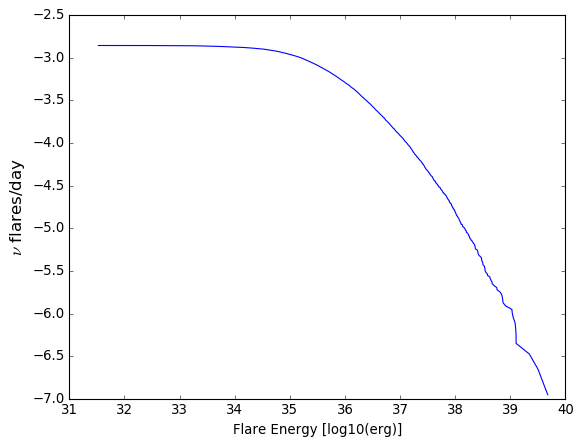

In [38]:
flare_energy = plotenergyfreq(stats_gaia, green_gaia)


In [39]:
flare_energy = cmd_mags(flare_energy)
green_gaia = cmd_mags(green_gaia)

In [40]:
np.max(flare_energy['flare_energy'])

39.68005986022704

# Control Time

## Find nobs per field (control time)

#### Notes:
Field 436 and 437 have a large gap of 42 minutes and 45 minutes respectively. The controltime function was adjusted to exclude the ~45 minute gap. 

Fields 488 and 489 there is only one day so the controltime funtion was adjusted to just look at the one day.

Field 541 starts with one observation then a gap of 67 minutes. The first point and the 67 minute gap are left out. 

Fields 685 and 686 have a small gap of 10 minutes. The gap is included in the control time.


#### Calculations:
For each field I took lightcurves that had the max amount of n_obs (# of observations in the lightcurve for the section we are using). For 4 light curves per field I calculated the control time to ensure it was consistent. To make that calculation I opened the light curve for that source and looked at the 'mjd'. To make it easier to understand I subtracted the 'mjd' by time of the first obervation so that the time is in days after the first observation. For the most part we had two nights of data. To get the control time of each night I seperate the two nights and then subtract the end time by the start time for each night. 

If there was only one night of data the controltime code was just adjusted to take out the second night (t2). 

If there was a gap, the location of the gap was determined by using the for loop below and interating through the time difference between observations. Using the index for the gap, that night was seperated into two sections and counted seperately, excluding the gap in the control time count.

Fields 591 and 592 have the exact same control time. I double checked and their start and stop times are different (58343.18984951111, 58344.29820601111), (58343.190312511106, 58344.29866901111) respectively. 



In [41]:
data = {'field': [436, 437, 488, 489, 538, 539, 540, 541, 591, 592, 638, 639, 685, 686], 
        'nobs':  [215, 212, 118, 118, 236, 160, 171, 170, 236, 236, 236, 236, 222, 223],
        'ctime': [0.19383099999686237, 0.19060180000087712, 0.10797460000321735, 0.1079745000024559,
                  0.16141200000129174, 0.12668989999656333, 0.15962949999811826, 0.15500010000687325, 
                  0.2183565000013914, 0.2183565000013914, 0.22236119999433868, 0.2223610000073677,
                  0.23268530000495957, 0.23174760000256356]
       }
fields = pd.DataFrame(data=data)
fields

field  nobs     ctime
0     436   215  0.193831
1     437   212  0.190602
2     488   118  0.107975
3     489   118  0.107975
4     538   236  0.161412
5     539   160  0.126690
6     540   171  0.159629
7     541   170  0.155000
8     591   236  0.218357
9     592   236  0.218357
10    638   236  0.222361
11    639   236  0.222361
12    685   222  0.232685
13    686   223  0.231748

In [42]:
def controltime(lightcurve):
    time = lightcurve['mjd']-np.min(lightcurve['mjd'].values[:])
    t1 = time.loc[time < .5]
    t2 = time.loc[(time > .5) & (time<1.5)]
    nobs = len(t1) + len(t2)
    t11 = lightcurve['mjd'][:len(t1)]
    t12 = lightcurve['mjd'][len(t1):len(t1) + len(t2)]
    #t11 = np.max(t11) -np.min(t11)
    #t12 = np.max(t12) -np.min(t12)
    
    #t1 = np.max(t1) -np.min(t1)
    #t2 = np.max(t2) -np.min(t2)
    return nobs, lightcurve['mjd'].values[0],lightcurve['mjd'].values[len(t1) + len(t2)-1]


In [43]:
def scale_control_time(df_full_field, control_time, field_n_obs):
    '''
    Input
    df_full_field: Have the fields seperated into their own data frame
    Insert the control time and field_n_obs calculated for that field for our lightcurve section
    
    Output
    Adds 2 columns to the dataframe:
    Use mode of zft_n_obs as the number of observations 
    nobs: This is the # of obs for our section of the lightcurve. 
            Scales the field_n_obs (total obs for the field) by the zft_n_obs / mode
    ctime: This is control time for our section of lightcurve
            Scales the control_time (time for our full section) by the zft_n_obs / mode
            
    '''

    mode = df_full_field['ztf_n_obs'].mode()
    df_full_field['nobs'] = df_full_field['ztf_n_obs'] 
    df_full_field.loc[df_full_field['nobs'].values > mode.values[-1], 'nobs'] = mode.values[-1] 
    
    df_full_field['nobs'] = round(df_full_field['nobs'] /mode.values[-1] * field_n_obs, 0)
    
    df_full_field['ctime'] = df_full_field['nobs'] / mode.values[-1] * control_time
    
    return df_full_field
    

In [44]:
def seperate_fields(df):
    f436 = df.loc[(df['unique_matchids_exploded'] > 10436000000000) & (df['unique_matchids_exploded'] < 10437000000000)]
    f437 = df.loc[(df['unique_matchids_exploded'] > 10437000000000) & (df['unique_matchids_exploded'] < 10438000000000)]
    f488 = df.loc[(df['unique_matchids_exploded'] > 10488000000000) & (df['unique_matchids_exploded'] < 10489000000000)]
    f489 = df.loc[(df['unique_matchids_exploded'] > 10489000000000) & (df['unique_matchids_exploded'] < 10490000000000)]
    f538 = df.loc[(df['unique_matchids_exploded'] > 10538000000000) & (df['unique_matchids_exploded'] < 10539000000000)]
    f539 = df.loc[(df['unique_matchids_exploded'] > 10539000000000) & (df['unique_matchids_exploded'] < 10540000000000)]
    f540 = df.loc[(df['unique_matchids_exploded'] > 10540000000000) & (df['unique_matchids_exploded'] < 10541000000000)]
    f541 = df.loc[(df['unique_matchids_exploded'] > 10541000000000) & (df['unique_matchids_exploded'] < 10542000000000)]
    f591 = df.loc[(df['unique_matchids_exploded'] > 10591000000000) & (df['unique_matchids_exploded'] < 10592000000000)]
    f592 = df.loc[(df['unique_matchids_exploded'] > 10592000000000) & (df['unique_matchids_exploded'] < 10593000000000)]
    f638 = df.loc[(df['unique_matchids_exploded'] > 10638000000000) & (df['unique_matchids_exploded'] < 10639000000000)]
    f639 = df.loc[(df['unique_matchids_exploded'] > 10639000000000) & (df['unique_matchids_exploded'] < 10640000000000)]
    f685 = df.loc[(df['unique_matchids_exploded'] > 10685000000000) & (df['unique_matchids_exploded'] < 10686000000000)]
    f686 = df.loc[(df['unique_matchids_exploded'] > 10686000000000) & (df['unique_matchids_exploded'] < 10687000000000)]
    return f436, f437, f488, f489, f538, f539, f540, f541, f591, f592, f638, f639, f685, f686


In [45]:
f436, f437, f488, f489, f538, f539, f540, f541, f591, f592, f638, f639, f685, f686 = seperate_fields(flare_energy)
fall436, fall437, fall488, fall489, fall538, fall539, fall540, fall541, fall591, fall592, fall638, fall639, fall685, fall686 = seperate_fields(green_gaia)


In [46]:
nobs436 = scale_control_time(fall436,fields.loc[fields['field']==436]['ctime'].values, fields.loc[fields['field']==436]['nobs'].values)
nobs437 = scale_control_time(fall437,fields.loc[fields['field']==437]['ctime'].values, fields.loc[fields['field']==437]['nobs'].values)
nobs488 = scale_control_time(fall488,fields.loc[fields['field']==488]['ctime'].values, fields.loc[fields['field']==488]['nobs'].values)
nobs489 = scale_control_time(fall489,fields.loc[fields['field']==489]['ctime'].values, fields.loc[fields['field']==489]['nobs'].values)
nobs538 = scale_control_time(fall538,fields.loc[fields['field']==538]['ctime'].values, fields.loc[fields['field']==538]['nobs'].values)
nobs539 = scale_control_time(fall539,fields.loc[fields['field']==539]['ctime'].values, fields.loc[fields['field']==539]['nobs'].values)
nobs540 = scale_control_time(fall540,fields.loc[fields['field']==540]['ctime'].values, fields.loc[fields['field']==540]['nobs'].values)
nobs541 = scale_control_time(fall541,fields.loc[fields['field']==541]['ctime'].values, fields.loc[fields['field']==541]['nobs'].values)
nobs591 = scale_control_time(fall591,fields.loc[fields['field']==591]['ctime'].values, fields.loc[fields['field']==591]['nobs'].values)
nobs592 = scale_control_time(fall592,fields.loc[fields['field']==592]['ctime'].values, fields.loc[fields['field']==592]['nobs'].values)
nobs638 = scale_control_time(fall638,fields.loc[fields['field']==638]['ctime'].values, fields.loc[fields['field']==638]['nobs'].values)
nobs639 = scale_control_time(fall639,fields.loc[fields['field']==639]['ctime'].values, fields.loc[fields['field']==639]['nobs'].values)
nobs685 = scale_control_time(fall685,fields.loc[fields['field']==685]['ctime'].values, fields.loc[fields['field']==685]['nobs'].values)
nobs686 = scale_control_time(fall686,fields.loc[fields['field']==686]['ctime'].values, fields.loc[fields['field']==686]['nobs'].values)


/epyc/opt/anaconda/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/epyc/opt/anaconda/lib/python3.7/site-packages/pandas/core/indexing.py:964: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
/epyc/opt/anaconda/lib/python3.7/site-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documenta

In [47]:
green_gaia = pd.concat([nobs436, nobs437, nobs488, nobs489, nobs538, nobs539, nobs540, nobs541, 
                        nobs591, nobs592, nobs638, nobs639, nobs685, nobs686])

In [48]:
nobs436 = scale_control_time(f436,fields.loc[fields['field']==436]['ctime'].values, fields.loc[fields['field']==436]['nobs'].values)
nobs437 = scale_control_time(f437,fields.loc[fields['field']==437]['ctime'].values, fields.loc[fields['field']==437]['nobs'].values)
nobs488 = scale_control_time(f488,fields.loc[fields['field']==488]['ctime'].values, fields.loc[fields['field']==488]['nobs'].values)
nobs489 = scale_control_time(f489,fields.loc[fields['field']==489]['ctime'].values, fields.loc[fields['field']==489]['nobs'].values)
nobs538 = scale_control_time(f538,fields.loc[fields['field']==538]['ctime'].values, fields.loc[fields['field']==538]['nobs'].values)
nobs539 = scale_control_time(f539,fields.loc[fields['field']==539]['ctime'].values, fields.loc[fields['field']==539]['nobs'].values)
nobs540 = scale_control_time(f540,fields.loc[fields['field']==540]['ctime'].values, fields.loc[fields['field']==540]['nobs'].values)
nobs541 = scale_control_time(f541,fields.loc[fields['field']==541]['ctime'].values, fields.loc[fields['field']==541]['nobs'].values)
nobs591 = scale_control_time(f591,fields.loc[fields['field']==591]['ctime'].values, fields.loc[fields['field']==591]['nobs'].values)
nobs592 = scale_control_time(f592,fields.loc[fields['field']==592]['ctime'].values, fields.loc[fields['field']==592]['nobs'].values)
nobs638 = scale_control_time(f638,fields.loc[fields['field']==638]['ctime'].values, fields.loc[fields['field']==638]['nobs'].values)
nobs639 = scale_control_time(f639,fields.loc[fields['field']==639]['ctime'].values, fields.loc[fields['field']==639]['nobs'].values)
nobs685 = scale_control_time(f685,fields.loc[fields['field']==685]['ctime'].values, fields.loc[fields['field']==685]['nobs'].values)
nobs686 = scale_control_time(f686,fields.loc[fields['field']==686]['ctime'].values, fields.loc[fields['field']==686]['nobs'].values)


/epyc/opt/anaconda/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/epyc/opt/anaconda/lib/python3.7/site-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/epyc/opt/anaconda/lib/python3.7/site-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pyd

In [49]:
flare_energy = pd.concat([nobs436, nobs437, nobs488, nobs489, nobs538, nobs539, nobs540, nobs541, 
                        nobs591, nobs592, nobs638, nobs639, nobs685, nobs686])

#Forget extra data frames to save memory:
del df_idxmatch437
del df_idxmatch488
del df_idxmatch489
del df_idxmatch538
del df_idxmatch539
del df_idxmatch540
del df_idxmatch541
del df_idxmatch591
del df_idxmatch592
del df_idxmatch638
del df_idxmatch639
del df_idxmatch685
del df_idxmatch686
del df_g19_xmatch436
del df_g19_xmatch437
del df_g19_xmatch488
del df_g19_xmatch489
del df_g19_xmatch538
del df_g19_xmatch539
del df_g19_xmatch540
del df_g19_xmatch541
del df_g19_xmatch591
del df_g19_xmatch592
del df_g19_xmatch638
del df_g19_xmatch639
del df_g19_xmatch685
del df_g19_xmatch686
del df_xmatch436
del df_xmatch437
del df_xmatch488
del df_xmatch489
del df_xmatch538
del df_xmatch539
del df_xmatch540
del df_xmatch541
del df_xmatch591
del df_xmatch592
del df_xmatch638
del df_xmatch639
del df_xmatch685
del df_xmatch686
del in_gaia
del in_g19

# Cuts on Data frames

Flares:
- Cut on not being too close to the end of the lightcurve make it 0.005 days
- Must have at least 10 data points in the flare part of the light curve
- E>0



Full sources:
- Cut on nobs, maybe 30


In [52]:
#... Looking at probability for duplicates observations 
#... Average # events per ccd per obseration
lambda_rate = len(flare_energy) / 64 / 14 / np.average(fields['nobs'])

print(r'lambda = {}, SD = {}'.format(lambda_rate, lambda_rate**.5))

prob_less = 1
#... Prob for a given number of peaks on a given observation 
for k in range(43):
    prob = ( (lambda_rate**k) * (np.e ** (-1 * lambda_rate)) ) / np.math.factorial(k)
    prob_less -= prob
    print(r'Probaility(k={}) = {}'.format(k,prob*100))
    print(r'Probaility(k>{}) = {}'.format(k,prob_less*100))
    print()
##... Prob for a given number or higher of peaks on a given observation
#for x in range(1,10):
#    prob = ( ( (lambda_rate * np.e) ** x ) * (np.e ** (-1 * lambda_rate)) ) / (x ** x)
#    print(r'Probability(x>={}) = {}'.format(x,prob))
    

lambda = 0.06953096988167802, SD = 0.26368725771579865
Probaility(k=0) = 93.2831243263967
Probaility(k>0) = 6.716875673603296

Probaility(k=1) = 6.486066108007515
Probaility(k>1) = 0.2308095655957798

Probaility(k=2) = 0.2254912336032216
Probaility(k>2) = 0.005318331992558217

Probaility(k=3) = 0.005226208057416008
Probaility(k>3) = 9.212393514220916e-05

Probaility(k=4) = 9.084582875889384e-05
Probaility(k>4) = 1.2781063833153178e-06

Probaility(k=5) = 1.2633197166621453e-06
Probaility(k>5) = 1.4786666653172442e-08

Probaility(k=6) = 1.4639974195027608e-08
Probaility(k>6) = 1.46692458144834e-10

Probaility(k=7) = 1.4541880068900113e-10
Probaility(k>7) = 1.2736574558328615e-12

Probaility(k=8) = 1.2638887813670845e-12
Probaility(k>8) = 9.768674465777006e-15

Probaility(k=9) = 9.764379199002834e-15
Probaility(k>9) = 4.295266774172636e-18

Probaility(k=10) = 6.789267559991493e-17
Probaility(k>10) = -6.359740882574229e-17

Probaility(k=11) = 4.291494165749293e-19
Probaility(k>11) = -6.402

In [55]:
#... Take out duplicated start times
time_share = flare_energy.pivot_table(index=['match_file','peak_time'], aggfunc='size')
dups = time_share.loc[time_share>3]
flare_energy_lim = flare_energy.copy()
flare_energy_lim = flare_energy_lim.reset_index(drop=True)

for i in range(len(dups)):
    index = flare_energy_lim[(flare_energy_lim['match_file'] == dups.index[i][0]) & 
                 (flare_energy_lim['peak_time'] >= dups.index[i][1] - 0.00001) &
                 (flare_energy_lim['peak_time'] <= dups.index[i][1] + 0.00001) ].index
    flare_energy_lim = flare_energy_lim.drop(index)
print(len(flare_energy), len(flare_energy_lim), len(flare_energy)-len(flare_energy_lim))


12411 11436 975


In [56]:
flare_energy_lim.head()

Unnamed: 0                            match_file      id  median_flux  \
0           0  ztf_000436_zr_c10_q1_match_programid   42093   240.019135   
1           0  ztf_000436_zr_c10_q1_match_programid  128206  1395.876953   
2           0  ztf_000436_zr_c08_q2_match_programid   69805   235.879608   
3           0  ztf_000436_zr_c02_q2_match_programid  158894  1279.103516   
4           0  ztf_000436_zr_c08_q3_match_programid  103566   170.065338   

   median_mag    start_time      end_time  duration      peak_flux  \
0   20.353888  58348.295579  58348.326817  0.031238  159656.421875   
1   18.442961  58348.220208  58348.258831  0.038623  186547.031250   
2   20.252689  58348.264792  58348.308438  0.043646   53353.054688   
3   18.498152  58348.314410  58348.324977  0.010567   17663.513672   
4   20.580235  58348.284549  58348.325440  0.040891    3526.831787   

      peak_time  peak_flux_index  frac_increase      fwhm       equivdur  \
0  58348.312569              129     664.182068  0.017410  945394.016942   
1  58348.222500               99     132.641464  0.007292   77953.970367   
2  58348.266181              121     225.187653  0.008472   83411.499229   
3  58348.321759              192      12.809292  0.007768    8511.895042   
4  58348.299248               61      19.738098  0.015588   25856.310660   

   equivdur_err  peak_to_start_time  peak_to_end_time        st_dev  \
0      0.325691            0.091910          0.014248  44376.671875   
1      0.026298            0.002292          0.104780  34012.855469   
2      0.049462            0.045972          0.061100   9289.862305   
3      0.001288            0.101551          0.003218   3826.008301   
4      0.014778            0.078588          0.026192   1057.480103   

   ave_flux_err  rel_ave_flux_err  ave_flux_err_flare  rel_ave_flux_err_flare  \
0    239.652256          0.998471         2605.028711               10.853421   
1    161.674829          0.115823          587.780561                0.421083   
2     76.756270          0.325404          206.612112                0.875922   
3     93.464256          0.073070          506.430106                0.395926   
4     48.235135          0.283627           73.143677                0.430092   

   med_flux_err  rel_med_flux_err  med_flux_err_flare  rel_med_flux_err_flare  \
0     46.914364          0.195461         3177.693359               13.239333   
1     76.771530          0.054999           98.860764                0.070823   
2     39.355942          0.166848           34.569298                0.146555   
3     78.353195          0.061256          542.374146                0.424027   
4     41.323116          0.242984           45.038277                0.264829   

                     fl_indx  \
0  [124 125 126 127 128 129]   
1                 [97 98 99]   
2              [120 121 122]   
3      [190 191 192 193 194]   
4           [58 59 60 61 62]   

                                             isflare  width_flag    AIC_flare  \
0          [123 124 125 126 127 128 129 130 131 132]           0  8578.809173   
1  [ 96  97  98  99 100 101 102 103 104 105 106 1...           1  7804.773196   
2  [120 121 122 123 124 125 126 127 128 129 130 1...           0  1519.337137   
3                      [189 190 191 192 193 194 195]           2   291.152617   
4  [56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71]           0   382.084372   

   loglike_flare  chisq_err_flare  chisq_exp_flare  dof_flare    AIC_gauss  \
0   -4285.404586      8570.809159     6.030378e+06          6  8944.274485   
1   -3898.386598      7796.773138     5.146326e+07         30  7642.395651   
2    -755.668568      1511.337124     1.179667e+07         34  1818.477194   
3    -141.576308       283.152615     9.560263e+03          3          NaN   
4    -187.042186       374.084371     1.818252e+03         12    14.238475   

   loglike_gauss  chisq_err_gauss  chisq_exp_gauss  dof_gauss    AIC_const  \
0   -4468.137243      8936.274434     4.

In [57]:
flare_energy_lim = flare_energy_lim.loc[(flare_energy_lim['width_flag']==0) 
                                        &(flare_energy_lim['E_50']>0) 
                                        &(flare_energy_lim['dof_flare']>6)
                                        &(flare_energy_lim['rel_ave_flux_err']<.25) 
                                        &(flare_energy_lim['frac_increase']<100)
                                        ]   

In [151]:
flare_energy_mod = flare_energy_lim.loc[(flare_energy_lim['width_flag']==0) 
                                        &(flare_energy_lim['E_50']>0) 
                                        &(flare_energy_lim['dof_flare']>6)
                                        &(flare_energy_lim['equivdur']>0)
                                        &(pd.notnull(flare_energy_lim['bp_rp_mag']))
                                        &(flare_energy_lim['rel_ave_flux_err']<.25) 
                                        &(flare_energy_lim['frac_increase']<100)
                                        &((flare_energy_lim['AIC_flare'] < flare_energy_lim['AIC_const'])) 
                                        &((flare_energy_lim['AIC_gauss'] < flare_energy_lim['AIC_const']))
                                        &((flare_energy_lim['chisq_err_flare'] < flare_energy_lim['chisq_err_gauss']))
                                       ]   
print(len(flare_energy_mod))

1478


In [59]:
green_gaia_lim = green_gaia.loc[(green_gaia['E_50']>0)
                                &(green_gaia['E_50']<1)
                                &(green_gaia['nobs']>30)]

(array([  1.,  21., 205., 243., 533., 385.,  98.,  12.]),
 array([31, 32, 33, 34, 35, 36, 37, 38, 39]),
 <a list of 8 Patch objects>)

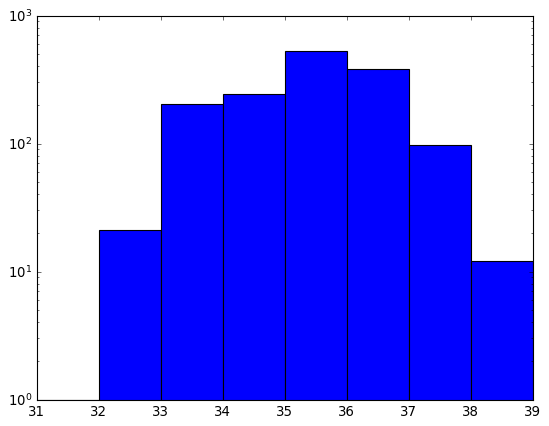

In [62]:
plt.hist(flare_energy_mod['flare_energy'], log =True, bins=np.arange(31,40,1))

(array([  10.,   80.,  312.,  693., 2089., 2755., 1758.,  669.,  184.,
          33.]),
 array([31.91122198, 32.63066965, 33.35011733, 34.06956501, 34.78901269,
        35.50846036, 36.22790804, 36.94735572, 37.6668034 , 38.38625108,
        39.10569875]),
 <a list of 10 Patch objects>)

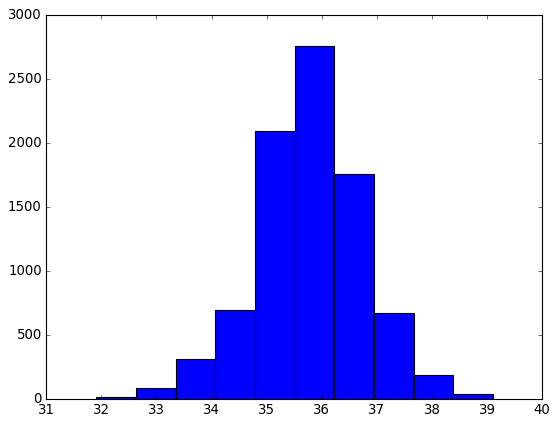

In [63]:
plt.hist(flare_energy_lim['flare_energy'])

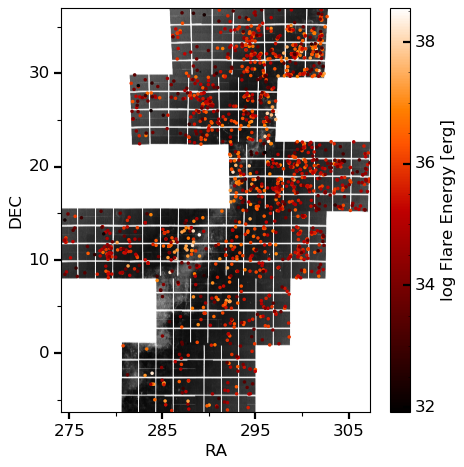

In [153]:
fig = plt.figure(figsize=(6,6))

#make the ra and dec the same ratio:
ax = plt.gca() #you first need to get the axis handle
ax.set_aspect(1)

plt.tick_params(which='major',length=6, width=2, direction='out')
plt.tick_params(which='minor', length=4, width=1, direction='out')
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_minor_locator(MultipleLocator(5))
ax.yaxis.set_minor_locator(MultipleLocator(5))

plt.xticks((275,285,295,305))

mpl.rcParams['xtick.labelsize'] = 15.0
mpl.rcParams['ytick.labelsize'] = 15.0          
    
    
plt.hexbin(df_idxmatch_final['ra'],df_idxmatch_final['dec'], bins='log', cmap='Greys',gridsize=1000)

plt.scatter(flare_energy_mod['ra'], flare_energy_mod['dec'], 
            alpha=1, s=10, c=flare_energy_mod['flare_energy'],edgecolors='none',
            cmap=plt.cm.get_cmap('gist_heat'), label='Flares')

cb = plt.colorbar(ticks=[32, 34, 36, 38])
cb.set_label('log Flare Energy [erg]',fontsize=15)

cb.ax.tick_params(labelsize=15, length=6, width=2) 
cb.ax.minorticks_on()


plt.xlim(np.min(df_idxmatch_final['ra']), np.max(df_idxmatch_final['ra']))
plt.ylim(np.min(df_idxmatch_final['dec']), np.max(df_idxmatch_final['dec']))
plt.xlabel('RA',fontsize=15)
plt.ylabel('DEC',fontsize=15)

plt.tight_layout()

plt.savefig('paper_plots/coords.png', dpi = 300)



### Make CMD

#### Bins

In [74]:
def Bins(df,column='Mr_50',n_bins=5): 
    df_sort = df.sort_values(by=[column],ascending=True)
    df_sort = df_sort.reset_index()
    bins = [df_sort[column].values[0]]
    len_df = len(df_sort)
    for i in np.arange(n_bins)+1:
        bin_edge = df_sort[column].values[int(len_df / n_bins * i - 1)]
        bins = np.append(bins, bin_edge)
    return bins

In [75]:
#  MIST isochrones
Mnames = ('EEP', 'log10_isochrone_age_yr', 'initial_mass', 'star_mass', 'log_Teff', 
          'log_g', 'log_L', '[Fe/H]_init', '[Fe/H]', 'Bessell_U', 'Bessell_B', 'Bessell_V', 
          'Bessell_R', 'Bessell_I', '2MASS_J', '2MASS_H', '2MASS_Ks', 'Kepler_Kp', 'Kepler_D51', 
          'Hipparcos_Hp', 'Tycho_B', 'Tycho_V', 'Gaia_G_DR2Rev', 'Gaia_BP_DR2Rev', 
          'Gaia_RP_DR2Rev', 'TESS', 'phase')

Mfile = 'MIST_v1.1_feh_p0.25_afe_p0.0_vvcrit0.4_UBVRIplus.iso.cmd'
#MIST_v1.1_feh_p0.00_afe_p0.0_vvcrit0.4_UBVRIplus.iso.cmd'
mist = pd.read_table(Mfile, delim_whitespace=True, comment='#', names=Mnames)

mist_ms1 = np.where((mist['phase']==0) & 
                    (mist['log10_isochrone_age_yr'] == 9.))[0][::-1]
                    #&                     (mist['Gaia_G_DR2Rev'] > 2))

In [77]:
#[-0.65, 5.15, 8.85, 10.2, 11.25, 15.9] 5.15


In [166]:
bins_Mrlim = Bins(flare_energy_mod)
bins_Mrlim

array([-0.85,  3.8 ,  5.1 ,  6.25,  9.  , 14.1 ], dtype=float32)

In [169]:
bins_glim = Bins(flare_energy_mod,column='g_mag')
bins_glim

array([ 1.03860538,  5.68335072,  6.60744311,  7.70873949,  9.66405867,
       14.57138593])

In [177]:
mist_mw = mist.loc[((mist['phase']==0) & 
                    (mist['log10_isochrone_age_yr'] == 9.))]
                   #Mass_cuts = np.interp(mist['Bessell_R'], mist['star_mass'], bins_Mrlim)

#Should give 4 masses. Goal: put them on the plot
mist_mw.loc[(mist_mw['Gaia_G_DR2Rev']>12) & (mist_mw['Gaia_G_DR2Rev']<14.5)]['star_mass']

66543    0.183186
66544    0.183467
66545    0.183747
66546    0.212838
66547    0.212994
66548    0.213151
Name: star_mass, dtype: float64

In [178]:
masses = [2.1, 1.3, 1.0, 0.84, 0.53, 0.183747]

In [83]:
mist_ms2 = np.where((mist['star_mass']<=1) & 
                    (mist['log10_isochrone_age_yr'] == 9.))[0][::-1]
                    #&                     (mist['Gaia_G_DR2Rev'] > 2))

In [84]:
mist['Gaia_BP_DR2Rev'].values[mist_ms2]

array([ 1.0101984e+01,  1.0073555e+01,  1.0014084e+01,  9.9542800e+00,
        9.8894920e+00,  9.8298550e+00,  9.7687130e+00,  9.7208320e+00,
        9.6560080e+00,  9.5950590e+00,  9.5585160e+00,  9.4954150e+00,
        9.4401480e+00,  9.3764770e+00,  9.3249460e+00,  9.2641470e+00,
        9.2126750e+00,  9.1803770e+00,  9.1362550e+00,  9.0853630e+00,
        9.0417820e+00,  8.9937830e+00,  8.9533520e+00,  8.9305450e+00,
        8.8863390e+00,  8.8499860e+00,  8.8069930e+00,  8.7698970e+00,
        8.7337360e+00,  8.7005120e+00,  8.6736050e+00,  8.6328410e+00,
        8.5827050e+00,  8.5139980e+00,  8.4661450e+00,  8.3813840e+00,
        8.2876260e+00,  8.1791460e+00,  8.0897730e+00,  7.9853830e+00,
        7.9018600e+00,  7.8251150e+00,  7.7539190e+00,  7.7031200e+00,
        7.6477380e+00,  7.6041390e+00,  7.5602320e+00,  7.5122410e+00,
        7.4697030e+00,  7.4426340e+00,  7.3658190e+00,  7.3163830e+00,
        7.2844340e+00,  7.2102990e+00,  7.1544010e+00,  7.1041940e+00,
      

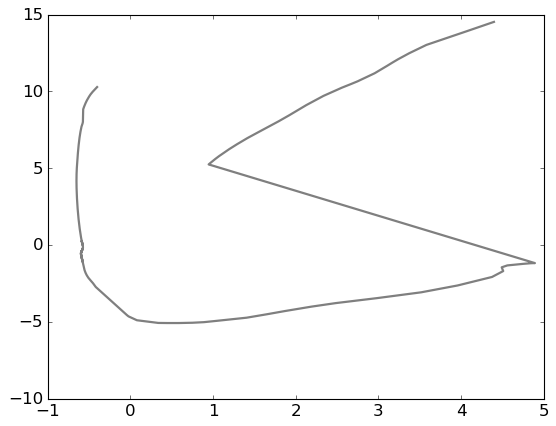

In [85]:
plt.plot(mist['Gaia_BP_DR2Rev'].values[mist_ms2] - mist['Gaia_RP_DR2Rev'].values[mist_ms2], 
         mist['Gaia_G_DR2Rev'].values[mist_ms2], c='black', lw=2, alpha=0.5, label = '1 Gyr MIST')

# Create CMD

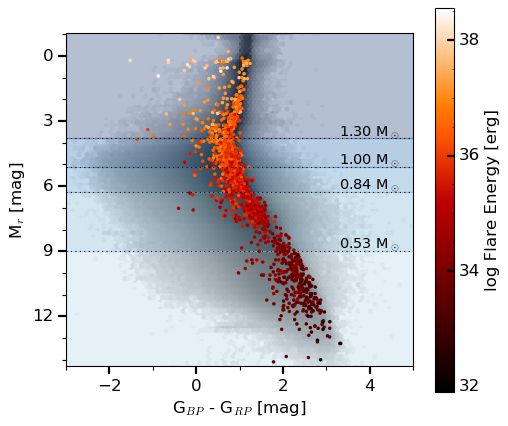

In [183]:
#LL = LUM(df['Mr_50'].values)
#masses = [1.758517, 0.840185, 0.508649, 0.384684, 0.308634, 0.183747]
masses = [2.1, 1.3, 1.0, 0.84, 0.53, 0.183747]

labelsize = 15
bins_Mrlim = Bins(flare_energy_mod)

fig = plt.figure(figsize=(7,6))

ax = plt.gca() #you first need to get the axis handle
ax.set_aspect(.5)


plt.tick_params(which='major',length=6, width=2, direction='out')
plt.tick_params(which='minor', length=4, width=1, direction='out')
plt.xticks(ticks = [-2, 0, 2, 4])
plt.yticks(ticks = [0, 3, 6, 9, 12])
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')

ax.xaxis.set_minor_locator(MultipleLocator(1))
ax.yaxis.set_minor_locator(MultipleLocator(1))

mpl.rcParams['xtick.labelsize'] = 15.0
mpl.rcParams['ytick.labelsize'] = 15.0          

plt.xlabel('G$_{BP}$ - G$_{RP}$ [mag]', size=labelsize)
plt.ylabel('M$_r$ [mag]', size=labelsize)

#make the lines the same color as the 
colormap=cm.Blues_r
normalize = mcolors.Normalize(vmin=0, vmax=len(bins_Mrlim))

plt.axhline(y=bins_Mrlim[1], color='k', linestyle=':')
plt.axhline(y=bins_Mrlim[2], color='k', linestyle=':')
plt.axhline(y=bins_Mrlim[3], color='k', linestyle=':')
plt.axhline(y=bins_Mrlim[4], color='k', linestyle=':')
#legend = plt.legend()
#plt.setp(legend.get_texts(), color='k')

plt.hexbin(green_gaia_lim['bp_rp_mag'], green_gaia_lim['Mr_50'], bins='log', cmap='binary')
plt.fill_between([-3,5], bins_Mrlim[0]-.2, bins_Mrlim[1],color=colormap(normalize(0)), alpha=0.3)
plt.fill_between([-3,5], bins_Mrlim[1], bins_Mrlim[2],color=colormap(normalize(1)), alpha=0.3)
plt.fill_between([-3,5], bins_Mrlim[2], bins_Mrlim[3],color=colormap(normalize(2)), alpha=0.3)
plt.fill_between([-3,5], bins_Mrlim[3], bins_Mrlim[4],color=colormap(normalize(3)), alpha=0.3)
plt.fill_between([-3,5], bins_Mrlim[4], bins_Mrlim[5]+.2,color=colormap(normalize(4)), alpha=0.3)

plt.text(3.3,bins_Mrlim[1]-.1,'1.30 M$_\odot$', fontsize=13)
plt.text(3.3,bins_Mrlim[2]-.1,'1.00 M$_\odot$', fontsize=13)
plt.text(3.3,bins_Mrlim[3]-.1,'0.84 M$_\odot$', fontsize=13)
plt.text(3.3,bins_Mrlim[4]-.1,'0.53 M$_\odot$', fontsize=13)


plt.ylim(bins_Mrlim[0]-.2,bins_Mrlim[5]+.2)
plt.xlim(-3,5)

plt.scatter(flare_energy_mod['bp_rp_mag'], flare_energy_mod['Mr_50'], 
            alpha=1, s=10, c=flare_energy_mod['flare_energy'],edgecolors='none',
            cmap=plt.cm.get_cmap('gist_heat'), label='Flares')

cb = plt.colorbar(ticks=[32, 34, 36, 38])
cb.set_label('log Flare Energy [erg]',fontsize=15)
cb.ax.tick_params(labelsize=15, length=6, width=2) 
cb.ax.minorticks_on()

plt.tick_params(axis='both', labelsize=labelsize, size=7)

plt.gca().invert_yaxis()

#fig.savefig(f'final_plots/final_CMD.png', dpi=350, bbox_inches = "tight", pad_inches=.25)


# Create Color vs Apparent Mag 

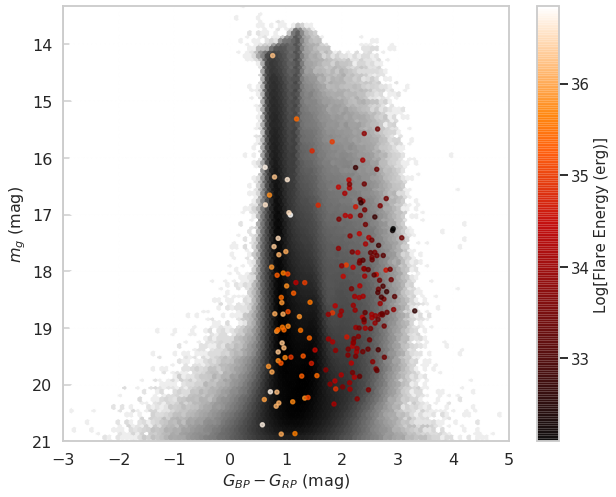

In [198]:
#LL = LUM(df['Mr_50'].values)
labelsize = 16

fig = plt.figure(figsize=(10,8))
plt.xlabel('$G_{BP} - G_{RP}$ (mag)', size=labelsize)
plt.ylabel('$m_g$ (mag)', size=labelsize)

plt.hexbin(green_gaia_lim['bp_rp_mag'], green_gaia_lim['phot_g_mean_mag'], bins='log', cmap='binary')

#plt.ylim(bins_Mrlim[0]-.2,bins_Mrlim[5]+.2)
plt.xlim(-3,5)

plt.scatter(flare_energy_limfinal['bp_rp_mag'], flare_energy_limfinal['phot_g_mean_mag'], 
            alpha=0.75, s=16, c=flare_energy_limfinal['flare_energy'],
            cmap=plt.cm.get_cmap('gist_heat'), label='Flaring Stars')

cb = plt.colorbar()
cb.set_label('Log[Flare Energy (erg)]',fontsize=labelsize-1)

cb.ax.tick_params(labelsize=labelsize-1) 

plt.tick_params(axis='both', labelsize=labelsize, size=7)

plt.gca().invert_yaxis()

#fig.savefig(f'final_plots/final_CMD.png', dpi=350, bbox_inches = "tight", pad_inches=.25)


In [103]:
f436, f437, f488, f489, f538, f539, f540, f541, f591, f592, f638, f639, f685, f686 = seperate_fields(flare_lim)
fall436, fall437, fall488, fall489, fall538, fall539, fall540, fall541, fall591, fall592, fall638, fall639, fall685, fall686 = seperate_fields(green_gaia)

ratef436 = np.arange(1, len(f436) +1) /  np.sum(fall436['ztf_n_obs'])*30
ratef437 = np.arange(1, len(f437) +1) /  np.sum(fall437['ztf_n_obs'])*30
ratef488 = np.arange(1, len(f488) +1) /  np.sum(fall488['ztf_n_obs'])*30
ratef489 = np.arange(1, len(f489) +1) /  np.sum(fall489['ztf_n_obs'])*30
ratef538 = np.arange(1, len(f538) +1) /  np.sum(fall538['ztf_n_obs'])*30
ratef539 = np.arange(1, len(f539) +1) /  np.sum(fall539['ztf_n_obs'])*30
ratef540 = np.arange(1, len(f540) +1) /  np.sum(fall540['ztf_n_obs'])*30
ratef541 = np.arange(1, len(f541) +1) /  np.sum(fall541['ztf_n_obs'])*30
ratef591 = np.arange(1, len(f591) +1) /  np.sum(fall591['ztf_n_obs'])*30
ratef592 = np.arange(1, len(f592) +1) /  np.sum(fall592['ztf_n_obs'])*30
ratef638 = np.arange(1, len(f638) +1) /  np.sum(fall638['ztf_n_obs'])*30
ratef639 = np.arange(1, len(f639) +1) /  np.sum(fall639['ztf_n_obs'])*30
ratef685 = np.arange(1, len(f685) +1) /  np.sum(fall685['ztf_n_obs'])*30
ratef686 = np.arange(1, len(f686) +1) /  np.sum(fall686['ztf_n_obs'])*30

In [1357]:
fall436, fall437, fall488, fall489, fall538, fall539, fall540, fall541, fall591, fall592, fall638, fall639, fall685, fall686 = seperate_fields(green_gaia)

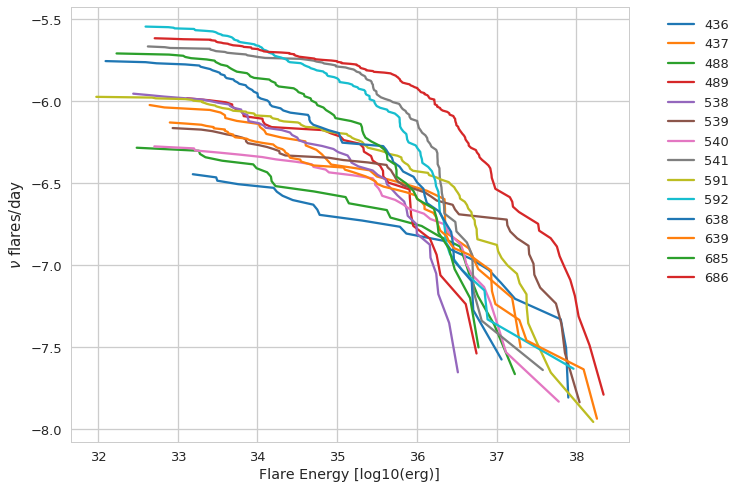

In [104]:
plt.figure(figsize=(10,8))
plt.ylabel('$\\nu$ flares/day', size=15)
plt.xlabel('Flare Energy [log10(erg)]')
plt.plot(f436['flare_energy'],np.log10(ratef436), label="436")
plt.plot(f437['flare_energy'],np.log10(ratef437), label="437")
plt.plot(f488['flare_energy'],np.log10(ratef488), label="488")
plt.plot(f489['flare_energy'],np.log10(ratef489), label="489")
plt.plot(f538['flare_energy'],np.log10(ratef538), label="538")
plt.plot(f539['flare_energy'],np.log10(ratef539), label="539")
plt.plot(f540['flare_energy'],np.log10(ratef540), label="540")
plt.plot(f541['flare_energy'],np.log10(ratef541), label="541")
plt.plot(f591['flare_energy'],np.log10(ratef591), label="591")
plt.plot(f592['flare_energy'],np.log10(ratef592), label="592")
plt.plot(f638['flare_energy'],np.log10(ratef638), label="638")
plt.plot(f639['flare_energy'],np.log10(ratef639), label="639")
plt.plot(f685['flare_energy'],np.log10(ratef685), label="685")
plt.plot(f686['flare_energy'],np.log10(ratef686), label="686")

plt.legend(bbox_to_anchor = (1.2, 1.0))

In [138]:
def ffdiagram_binned(df_flare, df_all, xaxis='flare_energy', bins=None, n_bins=5, bin_column='Mr_50', 
                     legendlabel='M$_r$',colormap=cm.Blues_r):
    
    '''
    df_flare: the 
    df_all:

    '''   
    #use bin function to get equal bins of flares
    if np.all(bins)==None:
        bins_flare = Bins(df_flare, column=bin_column, n_bins=n_bins)
    else:
        bins_flare = bins
    
    #make bins for all sources, 
    #dont want to miss max and min values outside of flare bins
    bins_all = [df_all[bin_column].min()]
    bins_all = np.append(bins_all, bins_flare[1:-1])
    bins_all = np.append(bins_all, df_all[bin_column].max())

    #set up plots CMRmap
    plt.figure(figsize=(7,7))
    plt.ylabel('log10($\\nu$ flares/day)', size=16)
    plt.xlabel(xaxis, size=15)
    
    #play with colors of plots, pick color based on bins
    normalize = mcolors.Normalize(vmin=0, vmax=n_bins)

    
    for i in range(n_bins):
        flare_inbin = df_flare.loc[(df_flare[bin_column] >= bins_flare[i]) & (df_flare[bin_column] < bins_flare[i+1])]
        all_inbin = df_all.loc[(df_all[bin_column] >= bins_all[i]) & (df_all[bin_column] < bins_all[i+1])]
        flare_energy = flare_inbin.sort_values(by=[xaxis],ascending=False)
        rate = np.arange(1, len(flare_inbin) +1) / (np.sum(all_inbin['ctime']- 0.005))
        color = colormap(normalize(i))
        plt.plot(flare_energy[xaxis], np.log10(rate), color=color, 
                 label='{} {:.1f} : {:.1f}'.format(legendlabel,bins_all[i],bins_all[i+1]))
        plt.tick_params(axis='both', labelsize=15, size=7)
        #print(len(flare_inbin),np.sum(all_inbin['ztf_n_obs']*30/60/60/24))
    #plt.legend(loc='upper right',fontsize=14)
    #fig.savefig(f'final_plots/final_ff_1plot_5magbin.png', dpi=350, bbox_inches = "tight",pad_inches=.25)


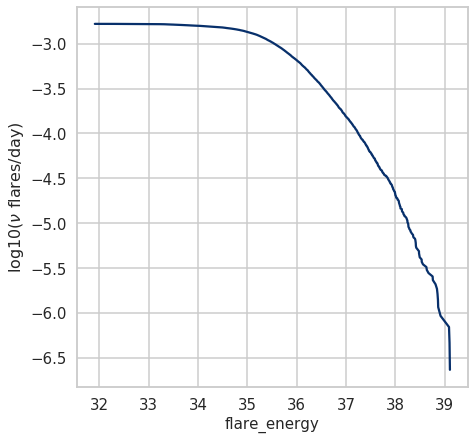

In [139]:
ffdiagram_binned(flare_energy_mod, green_gaia_lim, xaxis='flare_energy', n_bins=1)


(array([2.150239e+06, 6.362982e+06, 1.516497e+06, 2.830190e+05,
        2.662760e+05, 6.906500e+04, 3.988500e+04, 2.007000e+03,
        2.400000e+01, 2.000000e+00]),
 array([1.0000e+00, 1.9340e+02, 3.8580e+02, 5.7820e+02, 7.7060e+02,
        9.6300e+02, 1.1554e+03, 1.3478e+03, 1.5402e+03, 1.7326e+03,
        1.9250e+03]),
 <a list of 10 Patch objects>)

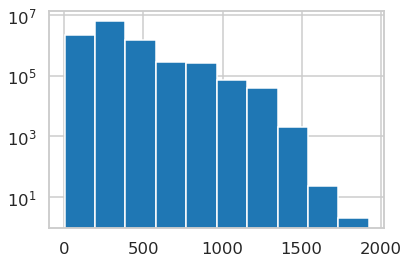

In [342]:
plt.hist(green_gaia_lim['ztf_n_obs'],log=True)

In [53]:
from scipy.optimize import curve_fit

def f(x, A): # this is your 'straight line' y=f(x)
    return -1*x + A
#popt, pcov = curve_fit(f, x, y) # your data x, y to fit
# plt.plot(x , popt[0]*x + popt[1])

In [575]:
median[0]

110.10979044575788

Text(0.5, 0, 'Height')

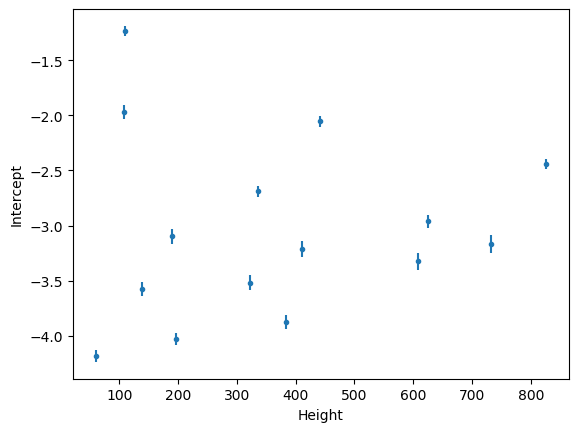

In [573]:
plt.errorbar(median, intercept['int']-36,yerr=intercept['err']*10, marker='.',linestyle='none')
plt.errorbar([median, intercept['int']-36,yerr=intercept['err']*10, marker='.',linestyle='none')
#plt.errorbar(median, intercept['int']-36,yerr=intercept['err']*10, marker='.',linestyle='none')
#plt.errorbar(median, intercept['int']-36,yerr=intercept['err']*10, marker='.',linestyle='none')
#plt.errorbar(median, intercept['int']-36,yerr=intercept['err']*10, marker='.',linestyle='none')

plt.ylabel('Intercept')
plt.xlabel('Height')

In [54]:
m1 = intercept.loc[(intercept['mass_low'] ==intercept['mass_low'].values[0]) &
                   (intercept['mass_low'] ==intercept['mass_low'].values[1]) &
                   (intercept['mass_low'] ==intercept['mass_low'].values[2])]
m2 = intercept.loc[(intercept['mass_low'] ==intercept['mass_low'].values[3]) &
                   (intercept['mass_low'] ==intercept['mass_low'].values[4]) &
                   (intercept['mass_low'] ==intercept['mass_low'].values[5])]
m3 = intercept.loc[(intercept['mass_low'] ==intercept['mass_low'].values[6]) &
                   (intercept['mass_low'] ==intercept['mass_low'].values[7]) &
                   (intercept['mass_low'] ==intercept['mass_low'].values[8])]
m4 = intercept.loc[(intercept['mass_low'] ==intercept['mass_low'].values[9]) &
                   (intercept['mass_low'] ==intercept['mass_low'].values[10]) &
                   (intercept['mass_low'] ==intercept['mass_low'].values[11])]
m5 = intercept.loc[(intercept['mass_low'] ==intercept['mass_low'].values[12]) &
                   (intercept['mass_low'] ==intercept['mass_low'].values[13]) &
                   (intercept['mass_low'] ==intercept['mass_low'].values[14])]



plt.errorbar([median[0],median[1],median[2]],m1['int']-36,yerr=m1['err']*10, marker='.',label='Mr -1.00')
plt.errorbar([median[3],median[4],median[5]],m2['int']-36,yerr=m2['err']*10, marker='.',label='Mr 3.25')
plt.errorbar([median[6],median[7],median[8]],m3['int']-36,yerr=m3['err']*10, marker='.',label='Mr 4.80')
plt.errorbar([median[9],median[10],median[11]],m4['int']-36,yerr=m4['err']*10, marker='.',label='Mr 5.55')
plt.errorbar([median[12],median[13],median[14]],m5['int']-36,yerr=m5['err']*10, marker='.',label='Mr 6.82')
plt.ylabel('Intercept')
plt.xlabel('Height')
plt.legend()

NameError: name 'intercept' is not defined

In [ ]:
def Intercept_function(df_all,df_flare, n_mass=5, n_height=3):
    median = []
    
    massbins_flare = Bins(df_flare, column='Mr_50', n_bins=n_mass)    
    massbins_all = [df_all['Mr_50'].min()]
    massbins_all = np.append(massbins_all, massbins_flare[1:-1])
    massbins_all = np.append(massbins_all, df_all['Mr_50'].max())
    
    for j in range(n_mass):
        flare_inmass = df_flare.loc[(df_flare['Mr_50'] >= massbins_flare[j]) & 
                                    (df_flare['Mr_50'] < massbins_flare[j+1])]
        all_inmass = df_all.loc[(df_all['Mr_50'] >= massbins_all[j]) & 
                                (df_all['Mr_50'] < massbins_all[j+1])]
        
        highbins_flare = Bins(flare_inmass, column='abs_gal_z', n_bins=n_height)
        highbins_all = [all_inmass['abs_gal_z'].min()]
        highbins_all = np.append(highbins_all, highbins_flare[1:-1])
        highbins_all = np.append(highbins_all, df_all['abs_gal_z'].max())
        
        for i in range(n_height):
            flare_inhigh = flare_inmass.loc[(flare_inmass['abs_gal_z'] >= highbins_flare[i]) & 
                                            (flare_inmass['abs_gal_z'] < highbins_flare[i+1])]
            all_inhigh = all_inmass.loc[(all_inmass['abs_gal_z'] >= highbins_all[i]) & 
                                        (all_inmass['abs_gal_z'] < highbins_all[i+1])]
            median = np.append(median, np.median(all_inhigh['abs_gal_z']))
   
    return median

In [572]:
median = Intercept_function(flare_energy_lim_nomodel, green_gaia_lim)

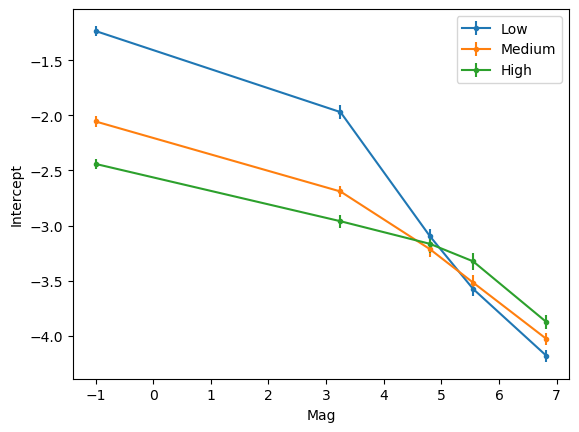

In [585]:
low = intercept.loc[(intercept['height_low'] == intercept['height_low'].values[0])|
                    (intercept['height_low'] == intercept['height_low'].values[3])|
                    (intercept['height_low'] == intercept['height_low'].values[6])|
                    (intercept['height_low'] == intercept['height_low'].values[9])|
                    (intercept['height_low'] == intercept['height_low'].values[12])]

med = intercept.loc[(intercept['height_low'] == intercept['height_low'].values[1]) |
                    (intercept['height_low'] == intercept['height_low'].values[4]) |
                    (intercept['height_low'] == intercept['height_low'].values[7]) |
                    (intercept['height_low'] == intercept['height_low'].values[10])| 
                    (intercept['height_low'] == intercept['height_low'].values[13])]

high = intercept.loc[(intercept['height_low'] == intercept['height_low'].values[2])|
                     (intercept['height_low'] == intercept['height_low'].values[5])|
                     (intercept['height_low'] == intercept['height_low'].values[8])|
                     (intercept['height_low'] == intercept['height_low'].values[11])|
                     (intercept['height_low'] == intercept['height_low'].values[14])]

plt.errorbar(low['mass_low'], low['int']-36, yerr=low['err']*10, marker='.',label='Low')
plt.errorbar(med['mass_low'], med['int']-36, yerr=med['err']*10, marker='.',label='Medium')
plt.errorbar(high['mass_low'],high['int']-36,yerr=high['err']*10,marker='.',label='High')
plt.ylabel('Intercept')
plt.xlabel('Mag')
plt.legend()
plt.show()

In [ ]:
def nplot_ffdiagram_binned(df_flare, df_all, bins=None, n_bins=5, bin_column='abs_gal_z',
                           nplots=1, plot_bin_column='Mr_50',
                           legendlabel='Mr',colormap=cm.viridis):
    
    intercept = []
    error = []
    mass_low=[]
    mass_high=[]
    height_low=[]
    height_high=[]
    
    
    plotbins_flare = Bins(df_flare, column=plot_bin_column, n_bins=nplots)    
    plotbins_all = [df_all[plot_bin_column].min()]
    plotbins_all = np.append(plotbins_all, plotbins_flare[1:-1])
    plotbins_all = np.append(plotbins_all, df_all[plot_bin_column].max())

    #use bin function to get equal bins of flares
    #if np.all(bins)==None:
    #    bins_flare = Bins(df_flare, column=bin_column, n_bins=n_bins)
    #else:
    #    bins_flare = bins


    #bins_mass = [1.75, 0.84, 0.50, 0.38, 0.30, 0.18]

    
    fig, axs = plt.subplots(nplots,1,figsize=(5,15), sharey=True,sharex=True, gridspec_kw={'hspace': .14})
    #plt.legend(loc='upper right', borderaxespad=0.)
    
    #play with colors of plots, pick color based on bins
    normalize = mcolors.Normalize(vmin=0, vmax=n_bins+1)
    

    for j in range(nplots):
        
        flare_inplot = df_flare.loc[(df_flare[plot_bin_column] >= plotbins_flare[j]) & (df_flare[plot_bin_column] < plotbins_flare[j+1])]
        all_inplot = df_all.loc[(df_all[plot_bin_column] >= plotbins_all[j]) & (df_all[plot_bin_column] < plotbins_all[j+1])]

        
        flare_linebin = Bins(flare_inplot, column=bin_column, n_bins=n_bins)
        all_linebin = [df_all[bin_column].min()]
        all_linebin = np.append(all_linebin, flare_linebin[1:-1])
        all_linebin = np.append(all_linebin, df_all[bin_column].max())
        
        
        for i in range(n_bins):
            flare_inbin = flare_inplot.loc[(flare_inplot[bin_column] >= flare_linebin[i]) & (flare_inplot[bin_column] < flare_linebin[i+1])]
            all_inbin = all_inplot.loc[(all_inplot[bin_column] >= all_linebin[i]) & (all_inplot[bin_column] < all_linebin[i+1])]
            flare_energy = flare_inbin.sort_values(by=['flare_energy'],ascending=False)
            rate = np.arange(1, len(flare_inbin) +1) / (np.sum(all_inbin['ctime'] - 0.005))
            color = colormap(normalize(i))
            
            # approximate the Poisson Y errors using Gehrels (1986) eqn 7
            Num = np.arange(1, len(flare_inbin) +1)
            Perror = np.sqrt(Num + 0.75) + 1.0
            ffd_yerr = Perror / (np.sum(all_inbin['ctime'] - 0.005))
            ffd_yerr = np.abs(ffd_yerr / np.log(10.) / rate)
            
            axs[j].errorbar(flare_energy['flare_energy'], np.log10(rate), yerr=ffd_yerr, linestyle='none',marker='*', ms=1,
                            color=color, label='{:.1f}< z <{:.1f}'.format(all_linebin[i],all_linebin[i+1]))
            
            popt, pcov = curve_fit(f, flare_energy['flare_energy'][:int(len(flare_energy)/2)],  np.log10(rate[:int(len(flare_energy)/2)])) # your data x, y to fit
            perr = np.sqrt(np.diag(pcov))
            axs[j].plot(flare_energy['flare_energy'][:int(len(flare_energy)/2)],  -1*flare_energy['flare_energy'][:int(len(flare_energy)/2)] + popt[0], 
                        color=color, linestyle='--',label="{:.2f} $\pm$ {:.4f}".format(popt[0],perr[0]))
            
            intercept = np.append(intercept, popt[0])
            error = np.append(error, perr[0])
            mass_low = np.append(mass_low, plotbins_flare[j])
            mass_high = np.append(mass_high, plotbins_flare[j+1])
            height_low = np.append(height_low, flare_linebin[i])
            height_high = np.append(height_high,flare_linebin[i+1])

        
        axs[j].set_title('{:.0f}< M$_r$ <{:.0f}'.format(plotbins_flare[j],plotbins_flare[j+1]))
        axs[j].legend(bbox_to_anchor=(1., 1.))
    
            #axs[j].set_title('{:.1f}< M$_r$ <{:.1f} ({:.2f}M$_\odot$> Mass >{:.2f}M$_\odot$)'.format(plotbins_flare[j],plotbins_flare[j+1],bins_mass[j],bins_mass[j+1]))
            #axs[j].plot(flare_energy['flare_energy'], np.log10(rate), color=color, 
            #            label='{:.0f}< mr <{:.0f} pc'.format(bins_all[i],bins_all[i+1]))
        axs[j].set_ylabel('log10($\\nu$ flares/day)')
        #axs[j].yaxis.label.set_size(16)
        #axs[j].tick_params(axis='both', size=7)
        axs[j].set_ylim(-7,-1)
    
    axs[-1].set_xlabel('Flare Energy (log10(erg))')
    #axs[-1].xaxis.label.set_size(15)
    #axs[-1].tick_params(axis='both')
    #axs[0].legend()
    #axs[0].legend(labels=('{:.0f}< z <{:.0f} pc'.format(bins_all[0],bins_all[1]),
    #                     '{:.0f}< z <{:.0f} pc'.format(bins_all[1],bins_all[2]),
    #                     '{:.0f}< z '.format(bins_all[2])) ,fontsize=14)    
    #fig.savefig(f'final_plots/final_ff_5plot_3heightbin.png', dpi=350, bbox_inches = "tight",pad_inches=.25)
    intercept = pd.DataFrame(data = {'int': intercept, 'err': error,'mass_low':mass_low,'mass_high':mass_high,
                                     'height_low':height_low,'height_high':height_high})
                                    

    
    return intercept

In [ ]:
def nplot_ffdiagram_powerlaw_constheight(df_flare, df_all, bins=None, n_bins=5, bin_column='abs_gal_z',
                                         nplots=1, plot_bin_column='Mr_50',
                                         legendlabel='Mr',colormap=cm.viridis):
    
    df_flare = df_flare.loc[np.isfinite(df_flare['flare_energy'])]

    
    plotbins_flare = Bins(df_flare, column=plot_bin_column, n_bins=nplots)    
    plotbins_all = [df_all[plot_bin_column].min()]
    plotbins_all = np.append(plotbins_all, plotbins_flare[1:-1])
    plotbins_all = np.append(plotbins_all, df_all[plot_bin_column].max())

    #use bin function to get equal bins of flares
    #if np.all(bins)==None:
    #    bins_flare = Bins(df_flare, column=bin_column, n_bins=n_bins)
    #else:
    #    bins_flare = bins


    #bins_mass = [1.75, 0.84, 0.50, 0.38, 0.30, 0.18]

    
    fig, axs = plt.subplots(nplots,1,figsize=(5,15), sharey=True,sharex=True, gridspec_kw={'hspace': .14})
    #plt.legend(loc='upper right', borderaxespad=0.)
    
    #play with colors of plots, pick color based on bins
    normalize = mcolors.Normalize(vmin=0, vmax=n_bins+1)
    

    for j in range(nplots):
        
        flare_inplot = df_flare.loc[(df_flare[plot_bin_column] >= plotbins_flare[j]) & (df_flare[plot_bin_column] < plotbins_flare[j+1])]
        all_inplot = df_all.loc[(df_all[plot_bin_column] >= plotbins_all[j]) & (df_all[plot_bin_column] < plotbins_all[j+1])]

        
        flare_linebin = Bins(flare_inplot, column=bin_column, n_bins=n_bins)
        print(flare_linebin)
        all_linebin = [df_all[bin_column].min()]
        all_linebin = np.append(all_linebin, flare_linebin[1:-1])
        all_linebin = np.append(all_linebin, df_all[bin_column].max())
        
        
        for i in range(n_bins):
            flare_inbin = flare_inplot.loc[(flare_inplot[bin_column] >= flare_linebin[i]) & (flare_inplot[bin_column] < flare_linebin[i+1])]
            all_inbin = all_inplot.loc[(all_inplot[bin_column] >= all_linebin[i]) & (all_inplot[bin_column] < all_linebin[i+1])]
            color = colormap(normalize(i))
            tot_time = np.sum(all_inbin['ctime'] - 0.005)
            
            #... Full plot
            bins, CCDF = powerlaw.cdf(10**flare_inbin['flare_energy'], survival=True, descrete=False)
            FFD =  CCDF * float(len(bins)) / tot_time

            #... Power Law Plot 
            results = powerlaw.Fit(10**flare_inbin['flare_energy'],descrete=False)
            bins_results, CDF_results = results.cdf(survival=True)
            #ccdf_fit = (results.data/results.power_law.xmin)**(-2+1)
            ccdf_fit = 1-results.power_law._cdf_base_function(results.data)
            FFD_fit = ccdf_fit * float(len(bins_results)) / tot_time
            
            
            axs[j].loglog(bins, FFD, color=color,linestyle='-', label='{:.0f}< |Z| <{:.0f} pc'.format(all_linebin[i],all_linebin[i+1]))
            axs[j].loglog(bins_results, FFD_fit,color=color,linestyle='--', label=r'$\alpha$ = {:.2f}, xmin = {:.2f}'.format(results.power_law.alpha,np.log10(results.power_law.xmin)))

        axs[j].set_title('{:.1f}< M$_r$ <{:.1f}'.format(plotbins_flare[j],plotbins_flare[j+1]))
        axs[j].legend(bbox_to_anchor=(1., 1.),prop={'size': 9})
    
            #axs[j].set_title('{:.1f}< M$_r$ <{:.1f} ({:.2f}M$_\odot$> Mass >{:.2f}M$_\odot$)'.format(plotbins_flare[j],plotbins_flare[j+1],bins_mass[j],bins_mass[j+1]))
            #axs[j].plot(flare_energy['flare_energy'], np.log10(rate), color=color, 
            #            label='{:.0f}< mr <{:.0f} pc'.format(bins_all[i],bins_all[i+1]))
        axs[j].set_ylabel('log10($\\nu$ flares/day)',size=9)
        #axs[j].yaxis.label.set_size(16)
        #axs[j].tick_params(axis='both', size=7)
        axs[j].set_ylim(-7,-1)
    
    axs[-1].set_xlabel('Flare Energy (log10(erg))',size=9)
    #axs[-1].xaxis.label.set_size(15)
    #axs[-1].tick_params(axis='both')
    #fig.savefig(f'final_plots/Power_Laws.png', dpi=350, bbox_inches = "tight", pad_inches=.25)

                                    

In [234]:
def nplot_ffdiagram_powerlaw(df_flare, df_all, bins=None, n_bins=5, bin_column='abs_gal_z',
                           nplots=1, plot_bin_column='Mr_50',
                           legendlabel='Mr',colormap=cm.viridis):
    
    df_flare = df_flare.loc[np.isfinite(df_flare['flare_energy'])]

    
    plotbins_flare = Bins(df_flare, column=plot_bin_column, n_bins=nplots)    
    plotbins_all = [df_all[plot_bin_column].min()]
    plotbins_all = np.append(plotbins_all, plotbins_flare[1:-1])
    plotbins_all = np.append(plotbins_all, df_all[plot_bin_column].max())

    #use bin function to get equal bins of flares
    #if np.all(bins)==None:
    #    bins_flare = Bins(df_flare, column=bin_column, n_bins=n_bins)
    #else:
    #    bins_flare = bins


    #bins_mass = [1.75, 0.84, 0.50, 0.38, 0.30, 0.18]

    
    fig, axs = plt.subplots(nplots,1,figsize=(5,15), sharey=True,sharex=True, gridspec_kw={'hspace': .14})
    #plt.legend(loc='upper right', borderaxespad=0.)
    
    #play with colors of plots, pick color based on bins
    normalize = mcolors.Normalize(vmin=0, vmax=n_bins+1)
    

    for j in range(nplots):
        
        flare_inplot = df_flare.loc[(df_flare[plot_bin_column] >= plotbins_flare[j]) & (df_flare[plot_bin_column] < plotbins_flare[j+1])]
        all_inplot = df_all.loc[(df_all[plot_bin_column] >= plotbins_all[j]) & (df_all[plot_bin_column] < plotbins_all[j+1])]

        
        flare_linebin = Bins(flare_inplot, column=bin_column, n_bins=n_bins)
        #flare_linebin = [0, 800, 1600, 10000]
        all_linebin = [df_all[bin_column].min()]
        all_linebin = np.append(all_linebin, flare_linebin[1:-1])
        all_linebin = np.append(all_linebin, df_all[bin_column].max())
        for i in range(n_bins):
            flare_inbin = flare_inplot.loc[(flare_inplot[bin_column] >= flare_linebin[i]) & (flare_inplot[bin_column] < flare_linebin[i+1])]
            all_inbin = all_inplot.loc[(all_inplot[bin_column] >= all_linebin[i]) & (all_inplot[bin_column] < all_linebin[i+1])]
            color = colormap(normalize(i))
            tot_time = np.sum(all_inbin['ctime'] - 0.005)
            
            #... Spencer Version
            
            x,y,xe,ye = ffd.FFD(10**flare_inbin['flare_energy'].values, edErr=flare_inbin['equivdur_err'].values, TOTEXP=np.sum(all_inbin['ctime']))
            b0, b1, b0_err, b1_err, cutoff = ffd.FFD_powerlaw(x, y, xe, ye, findXmin=True)                        
            xmodel = np.linspace(np.min(x), np.max(x))
            ymodel = b0 * xmodel + b1

            #axs[j].errorbar(10**x,10**y, xerr=10**xe, yerr=10**ye, color=color,linestyle='-', label='{:.0f}< |Z| <{:.0f} pc'.format(all_linebin[i],all_linebin[i+1]),alpha=.5)
            axs[j].plot(10**x,10**y, color=color,linestyle='-', label='{:.0f}< |Z| <{:.0f} pc'.format(all_linebin[i],all_linebin[i+1]),alpha=.5)
            
            axs[j].plot(10**xmodel, 10**ymodel,color=color,linestyle='--') #, label=r'$\alpha$ = {:.2f}, xmin = {:.2f}'.format(b0,cutoff)

        axs[j].set_title('{:.1f}< M$_r$ <{:.1f}'.format(plotbins_flare[j],plotbins_flare[j+1]))
        axs[j].legend(loc=3,prop={'size': 9}) # bbox_to_anchor=(0., 0.)
        axs[j].set_yscale('log')
        axs[j].set_xscale('log')
        axs[j].set_yticks(ticks = [10e-5, 10e-3, 10e-1])
        axs[j].set_xticks(ticks = [10e32, 10e32, 10e36, 10e38])
            #axs[j].set_title('{:.1f}< M$_r$ <{:.1f} ({:.2f}M$_\odot$> Mass >{:.2f}M$_\odot$)'.format(plotbins_flare[j],plotbins_flare[j+1],bins_mass[j],bins_mass[j+1]))
            #axs[j].plot(flare_energy['flare_energy'], np.log10(rate), color=color, 
            #            label='{:.0f}< mr <{:.0f} pc'.format(bins_all[i],bins_all[i+1]))
        axs[j].set_ylabel('log10($\\nu$ flares/day)',size=9)
        #axs[j].yaxis.label.set_size(16)
        #axs[j].tick_params(axis='both', size=7)
        #axs[j].set_ylim(-7,-1)
    
    axs[-1].set_xlabel('Flare Energy (log10(erg))',size=9)
    #axs[-1].xaxis.label.set_size(15)
    #axs[-1].tick_params(axis='both')
    #fig.savefig(f'final_plots/Power_Laws.png', dpi=350, bbox_inches = "tight", pad_inches=.25)
    return flare_inbin,all_inbin
                                    

In [ ]:
flare_inbin,all_inbin = nplot_ffdiagram_powerlaw(flare_energy_mod, green_gaia_lim, n_bins=3, bin_column='abs_gal_z', nplots=5, plot_bin_column='Mr_50')

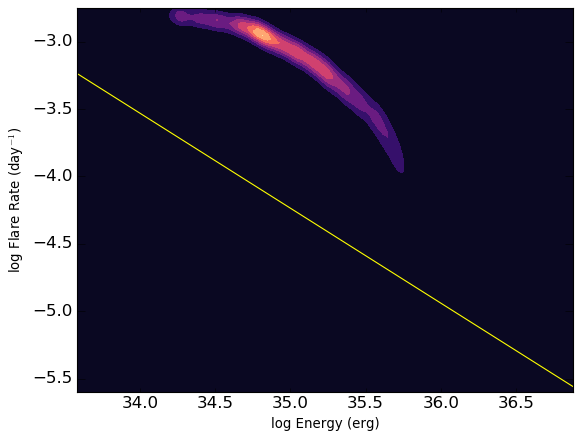

In [461]:
plt.contourf(xx, yy, im,cmap='magma')
#plt.errorbar(x,y, xerr=xe, yerr=ye)
plt.xlabel('log Energy (erg)')
plt.ylabel('log Flare Rate (day$^{-1}$)')
xmodel = np.linspace(np.min(x), np.max(x))
ymodel = b0 * xmodel + b1
#plt.xlim(30,40)
plt.plot(xmodel, ymodel,color='yellow')
#plt.vlines(cutoff, linestyle='--')

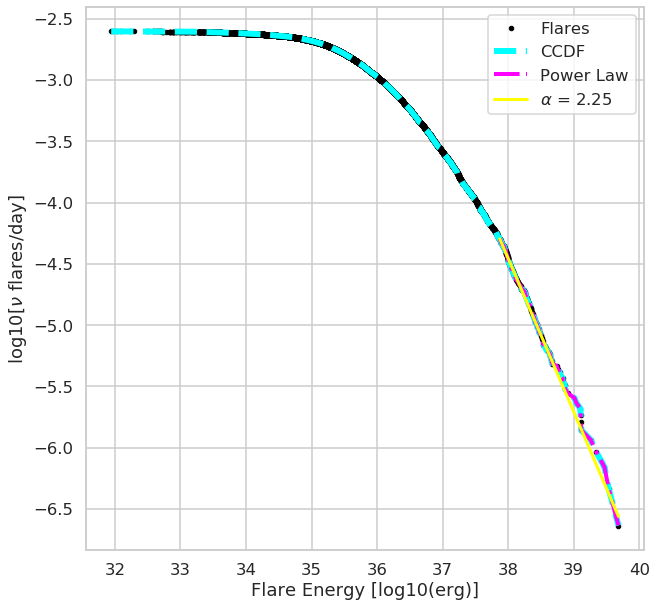

In [245]:
plt.figure(figsize=(10,10))


flare_notnan = flare_notnan.sort_values(by=['flare_energy'],ascending=False)
rate = np.arange(1, len(flare_notnan['flare_energy']) +1) / (np.sum(green_gaia_lim['ctime'] - 0.005))

Num = np.arange(1, len(flare_notnan['flare_energy'])+1)
Perror = np.sqrt(Num + 0.75) + 1.0
ffd_yerr = Perror / (np.sum(green_gaia_lim['ctime'] - 0.005))
#ffd_yerr = np.abs(ffd_yerr / np.log(10.) / rate)

plt.plot(flare_notnan['flare_energy'], np.log10(rate), linestyle='none',marker='.',label='Flares',color='black',linewidth=8)

plt.plot(np.log10(bins), np.log10(CDF*float(len(bins))/ (np.sum(green_gaia_lim['ctime'] - 0.005))), color='cyan',linewidth=6,label='CCDF',linestyle='--')
plt.plot(np.log10(bins_results), np.log10(CDF_results*float(len(bins_results))/ (np.sum(green_gaia_lim['ctime'] - 0.005))), linewidth=4,color='magenta',label='Power Law',linestyle='-.')
plt.plot(np.log10(bins_results), np.log10(cdf_fit*float(len(bins_results))/ (np.sum(green_gaia_lim['ctime'] - 0.005))), linewidth=3,color='yellow',label=r'$\alpha$ = {:.2f}'.format(results.power_law.alpha),linestyle='-')



#popt, pcov = curve_fit(f, flare_notnan['flare_energy'][:1500],  np.log10(rate[:1500])) 
#perr = np.sqrt(np.diag(pcov))
#plt.plot(flare_notnan['flare_energy'][:5000],  -1*flare_notnan['flare_energy'][:5000] + popt[0], label='Model',color='red')


plt.legend()
plt.ylabel('log10[$\\nu$ flares/day]')
plt.xlabel('Flare Energy [log10(erg)]')
plt.show()

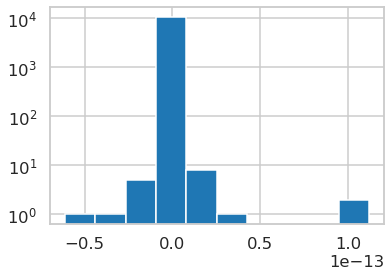

In [178]:
plt.hist(np.log10(rate)[::-1] -  np.log10(CDF*float(len(bins))/ (np.sum(green_gaia_lim['ctime'] - 0.005))))
plt.yscale('log')


In [91]:
results = powerlaw.Fit(10**flare_notnan['flare_energy'],descrete=False)

Calculating best minimal value for power law fit
/astro/users/courtk32/.local/lib/python3.7/site-packages/powerlaw.py:700: RuntimeWarning: invalid value encountered in true_divide
  (Theoretical_CDF * (1 - Theoretical_CDF))


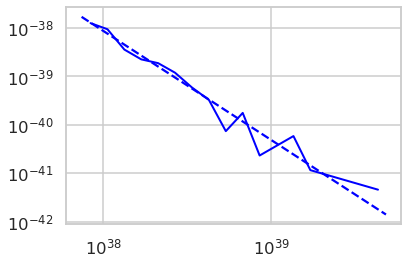

In [252]:
figCCDF = results.plot_pdf(color='b', linewidth=2)
results.power_law.plot_pdf(color='b', linestyle='--', ax=figCCDF)
#figCCDF = results.plot_ccdf(color='r', linewidth=2)
#results.power_law.plot_ccdf(color='r', linestyle='--', ax=figCCDF)

In [207]:
alpha = results.power_law.alpha
xmin = results.power_law.xmin
data = results.data
cdf_fit = (data/xmin)**(-alpha+1)

In [232]:
cdf_fit = 1-results.power_law._cdf_base_function(results.data)

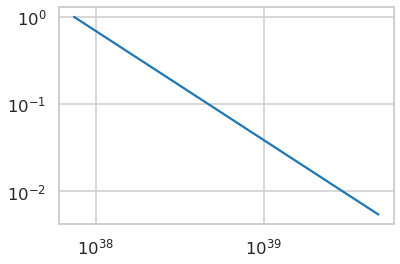

In [182]:
bins_results, CDF_results = results.cdf(survival=True)
#bins_fit, CDF_fit = results.power_law
results.power_law.plot_ccdf()

In [180]:
results.power_law?

In [146]:
bins, CDF = powerlaw.cdf(10**flare_notnan['flare_energy'], survival=True)

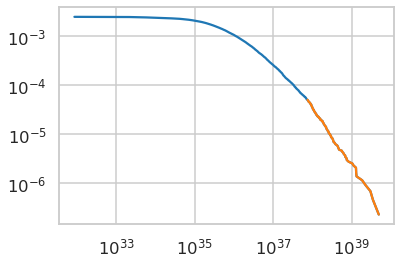

In [158]:
plt.loglog(bins, CDF*float(len(bins))/ (np.sum(green_gaia_lim['ctime'] - 0.005)))
plt.loglog(bins_results, CDF_results*float(len(bins_results))/ (np.sum(green_gaia_lim['ctime'] - 0.005)))

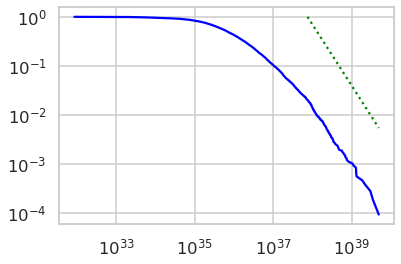

In [104]:
figPDF = powerlaw.plot_ccdf(10**flare_notnan['flare_energy'], color='b')
results.power_law.plot_ccdf(ax=figPDF, linestyle=':', color='g')

In [346]:
#flare_notnan = flare_energy_lim_nomodel.loc[np.isfinite(flare_energy_lim_nomodel['flare_energy'])]
flare_energy.loc[np.isnan(flare_energy['flare_energy'])]
                             

match_file      id   median_flux  median_mag  \
20     ztf_000436_zr_c01_q4_match_programid   22863   9606.695312   16.054089   
27     ztf_000436_zr_c01_q4_match_programid  142303    596.175293   19.036251   
378    ztf_000436_zr_c09_q4_match_programid  102576    582.759949   19.395311   
429    ztf_000436_zr_c10_q4_match_programid   33005   3605.771484   17.455166   
459    ztf_000436_zr_c11_q4_match_programid   43126   2164.701660   18.011709   
617    ztf_000437_zr_c02_q3_match_programid   51921    589.292175   19.229185   
658    ztf_000437_zr_c03_q3_match_programid   28345    396.420929   19.616407   
2179   ztf_000538_zr_c05_q4_match_programid    5438   1211.746216   18.579315   
2384   ztf_000538_zr_c07_q3_match_programid   83595   2763.216309   17.659452   
2476   ztf_000538_zr_c09_q2_match_programid  114519   3408.500732   17.421299   
2500   ztf_000538_zr_c09_q4_match_programid  104941   7497.396484   16.614437   
4175   ztf_000541_zr_c02_q1_match_programid  103985   2008.724243   17.879480   
4185   ztf_000541_zr_c02_q3_match_programid   25670    580.868408   19.175283   
4319   ztf_000541_zr_c05_q2_match_programid   23634   4167.535156   17.085228   
4358   ztf_000541_zr_c06_q1_match_programid   33068   1850.239624   18.007912   
4378   ztf_000541_zr_c06_q1_match_programid   90336   1848.531616   18.006889   
4404   ztf_000541_zr_c06_q2_match_programid   68303    666.742676   19.114719   
4405   ztf_000541_zr_c06_q2_match_programid   68354    711.144104   19.029200   
4580   ztf_000541_zr_c08_q3_match_programid   36072   1150.579956   18.509386   
4643   ztf_000541_zr_c09_q2_match_programid   52075   1142.096680   18.502394   
4649   ztf_000541_zr_c09_q2_match_programid   56962    739.731995   18.975666   
4798   ztf_000541_zr_c10_q4_match_programid   44492   3582.566895   17.315550   
4919   ztf_000541_zr_c12_q3_match_programid   88957  12865.635742   15.972586   
4922   ztf_000541_zr_c12_q3_match_programid   90084   5541.257324   16.883698   
4923   ztf_000541_zr_c12_q3_match_programid   90289   6246.727051   16.754513   
4948   ztf_000541_zr_c12_q4_match_programid   65904   2979.008057   17.513519   
4979   ztf_000541_zr_c13_q3_match_programid   53522    312.687408   19.901535   
5121   ztf_000541_zr_c14_q4_match_programid   66450   6178.010742   16.684593   
5293   ztf_000591_zr_c02_q1_match_programid  101181   4963.299805   17.122530   
7277   ztf_000592_zr_c09_q1_match_programid   58327   5613.246094   16.819483   
9347   ztf_000639_zr_c10_q2_match_programid   23972   6903.758789   16.811695   
9454   ztf_000639_zr_c11_q3_match_programid  130106   1283.249512   18.685883   
11591  ztf_000686_zr_c08_q4_match_programid   19530    395.313293   19.893492   
12191  ztf_000686_zr_c12_q4_match_programid   16286    284.734344   20.236866   

          peak_flux     peak_time  peak_flux_index  frac_increase      fwhm  \
20     15341.169922  58347.273600               35       0.596925  0.004349   
27       813.841797  58347.310787               76       0.365105  0.003537   
378     1150.579956  58347.275440               34       0.974363  0.007190   
429     6048.408691  58347.277732               28       0.677424  0.005018   
459     2839.461182  58347.268090               32       0.311710  0.003340   
617      896.986450  58347.273137               34       0.522142  0.003961   
658      544.540894  58347.309873               70       0.373643  0.003745   
2179    1392.011597  58333.268472               77       0.148765  0.001662   
2384    3148.552002  58333.264815               69       0.139452  0.002505   
2476    3789.896973  58333.277153               96       0.111896  0.001843   
2500    8236.380859  58333.258877               55       0.098565  0.002067   
4175    3343.112061  58341.283889               25       0.664296  0.003333   
4185    1005.182861  58341.281111               22       0.730483  0.003641   
4319    4915.395508  58341.281111               27       0.179449  0.003481   
4358    2123

(array([ 1.,  0.,  0.,  2.,  3.,  4.,  3.,  6.,  5., 39.]),
 array([-268.68334542, -240.82916643, -212.97498743, -185.12080843,
        -157.26662943, -129.41245044, -101.55827144,  -73.70409244,
         -45.84991344,  -17.99573444,    9.85844455]),
 <a list of 10 Patch objects>)

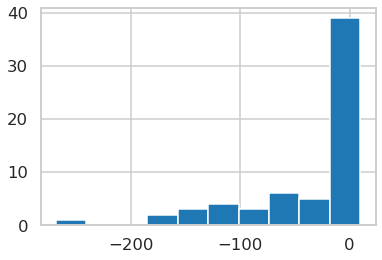

In [351]:
plt.hist(flare_energy.loc[flare_energy['equivdur_new'] <10]['equivdur_new'])

In [88]:
print(len(flare_energy_lim_nomodel),len(flare_notnan))

10880 10775


In [117]:
print(results.power_law.alpha)
print(results.power_law.xmin)
R, p = results.distribution_compare('power_law', 'lognormal')
print(R,p)

2.2506394057929633
7.445753614145581e+37
-0.017153814028290526 0.9039740253609272


In [118]:
results.power_law.

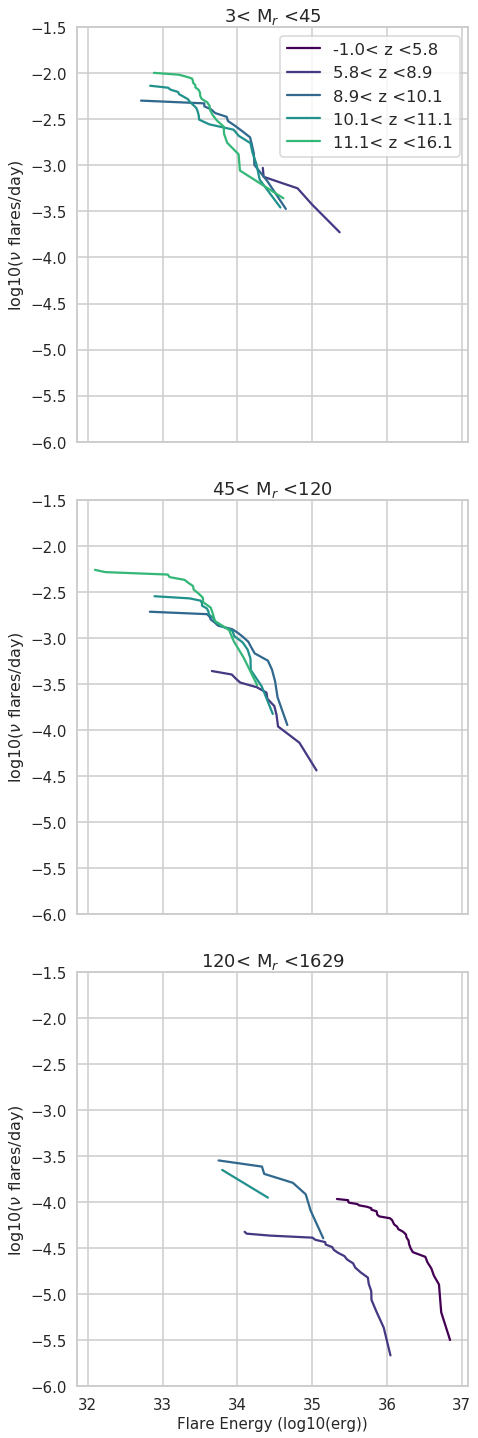

In [125]:
nplot_ffdiagram_binned(flare_energy_limfinal, green_gaia_lim, n_bins=5, bin_column='Mr_50',
                       nplots=3, plot_bin_column='abs_gal_z')

In [796]:
hexbinlim = all_gal.loc[(all_gal['gal_r']/1000 < 11) & (all_gal['gal_r']/1000 > 3.7) &
                        (all_gal['abs_gal_z']/1000 <2)]

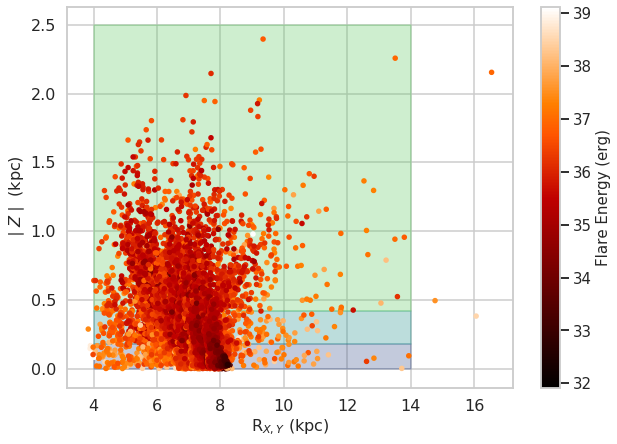

In [195]:
fig = plt.figure(figsize=(10,7))

#plt.hexbin(hexbinlim['gal_r']/1000,hexbinlim['abs_gal_z']/1000, bins='log',cmap='binary')
heightbins_flare = Bins(flare_energy_lim, column='abs_gal_z', n_bins=3)/1000
#print(heightbins_flare)


colormap=cm.viridis
normalize = mcolors.Normalize(vmin=0, vmax=4)

plt.fill_between([4,14], 0, heightbins_flare[1],color=colormap(normalize(1)), alpha=0.3)
plt.fill_between([4,14], heightbins_flare[1], heightbins_flare[2],color=colormap(normalize(2)), alpha=0.3)
plt.fill_between([4,14], heightbins_flare[2], 2.5,color=colormap(normalize(3)), alpha=0.3)

plt.scatter(flare_energy_lim['gal_r']/1000,flare_energy_lim['abs_gal_z']/1000,
            alpha=1, s=16, c=flare_energy_lim['flare_energy'],
            cmap=plt.cm.get_cmap('gist_heat'), label='Flaring Stars') 
cb = plt.colorbar()
cb.ax.tick_params(labelsize=15) 
cb.set_label('Flare Energy (erg)',fontsize=15)
plt.xlabel('R$_{X,Y}$ (kpc)', size=16)
plt.ylabel('$\mid{Z}\mid$ (kpc)', size=16)
#plt.xlim(6,8.5)
#plt.ylim(0,.8)
plt.tick_params(axis='both', labelsize=16, size=7)


#fig.savefig(f'final_plots/final_R_Zplot_flarelim.png', dpi=350, bbox_inches='tight',pad_inches=.25)


/epyc/opt/anaconda/lib/python3.6/site-packages/numpy/lib/histograms.py:824: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/epyc/opt/anaconda/lib/python3.6/site-packages/numpy/lib/histograms.py:825: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


(array([ 4., 23., 69., 53., 25.,  9., 10., 14.,  3.,  1.]),
 array([32.23188458, 32.81169464, 33.39150471, 33.97131477, 34.55112484,
        35.1309349 , 35.71074497, 36.29055504, 36.8703651 , 37.45017517,
        38.02998523]),
 <a list of 10 Patch objects>)

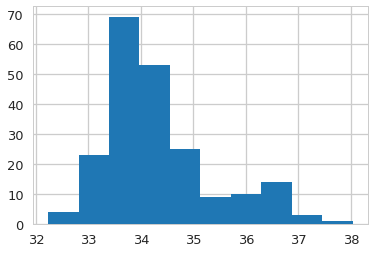

In [853]:
plt.hist(flares_energy_lim['flare_energy'])

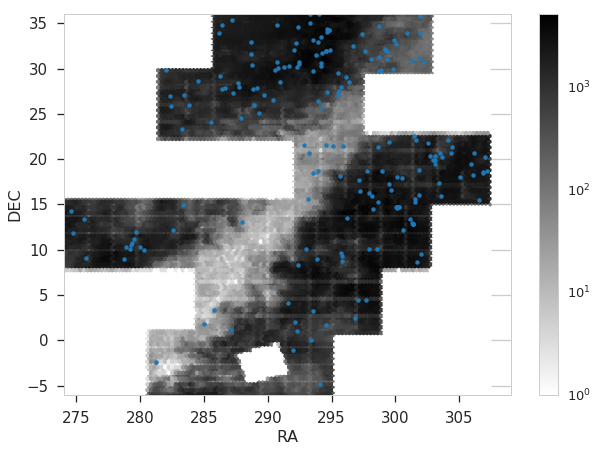

In [714]:
fig = plt.figure(figsize=(10,7))

plt.hexbin(green_gaia_lim['ra'],green_gaia_lim['dec'], bins='log',cmap='binary',gridsize=120)

plt.scatter(flare_energy_limfinal['ra'],flare_energy_limfinal['dec'],
            alpha=1, s=16, c=flare_energy_limfinal['flare_energy'],
            cmap=plt.cm.get_cmap('gist_heat'), label='Flaring Stars') 

cb = plt.colorbar()
cb.ax.tick_params(labelsize=15) 
cb.set_label('Flare Energy (erg)',fontsize=15)
plt.xlabel('RA',size=16)
plt.ylabel('DEC',size=16)
#plt.xlim(3.7,11)
plt.ylim(-6,36)
plt.tick_params(axis='both', labelsize=15, size=7)


 
#fig.savefig(f'final_plots/final_Ra_Decplot_flarelim.png', dpi=350, bbox_inches='tight',pad_inches=.25)

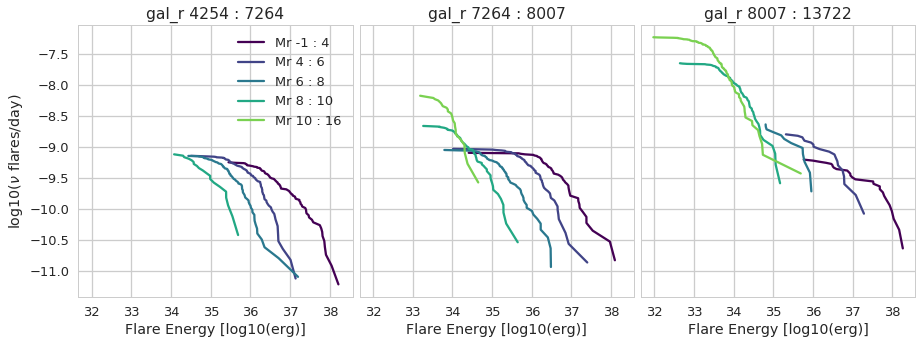

In [474]:
nplot_ffdiagram_binned(galcoordflare, all_gal, nplots=3, plot_bin_column='gal_r')

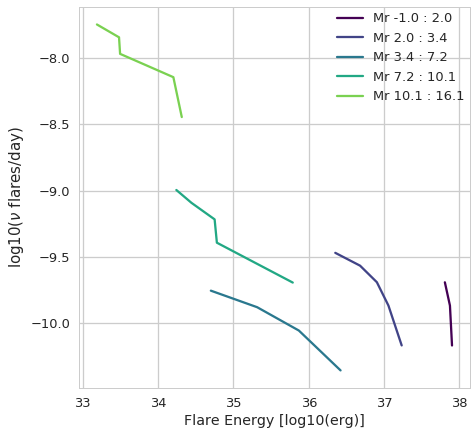

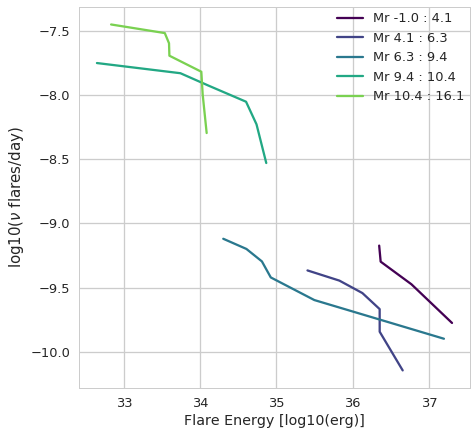

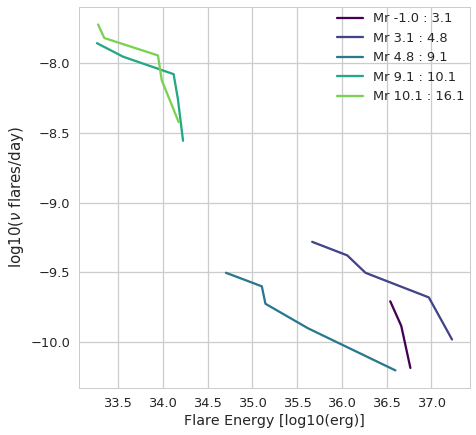

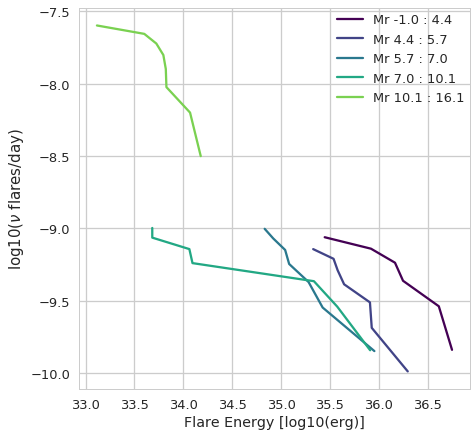

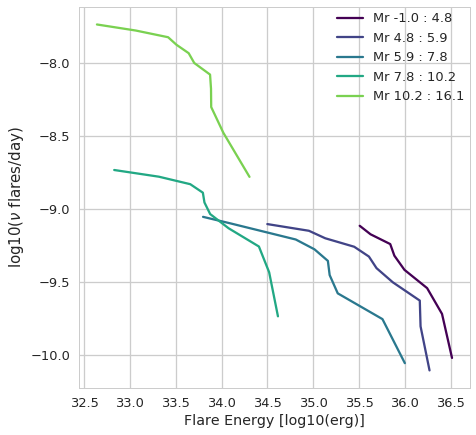

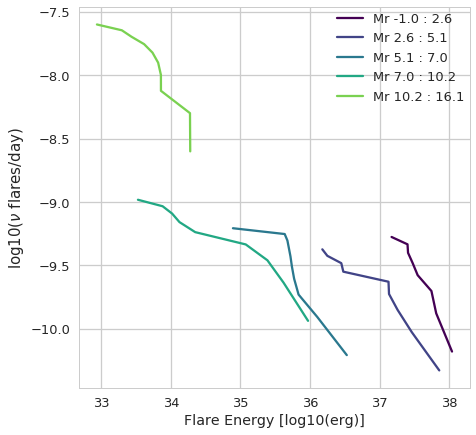

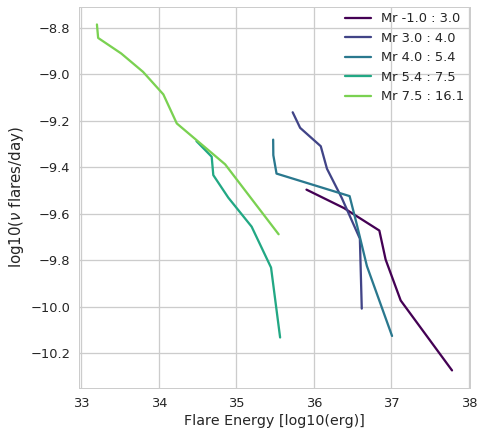

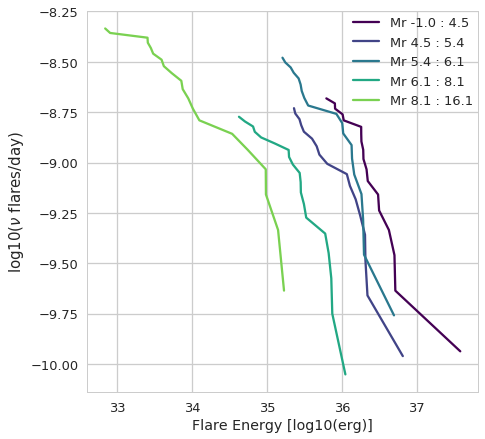

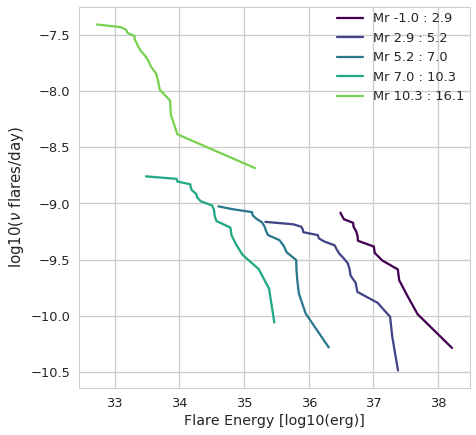

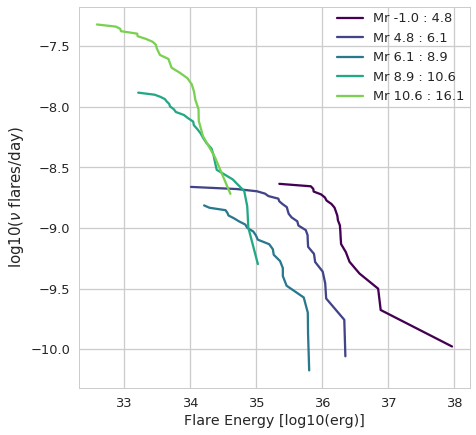

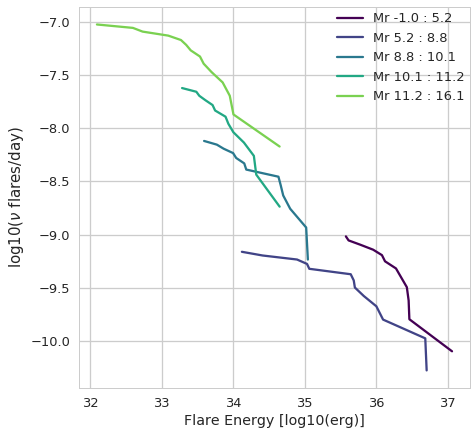

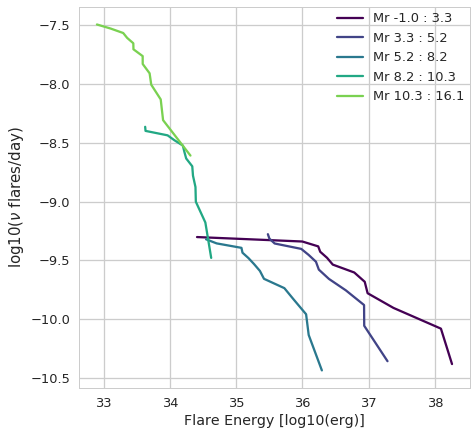

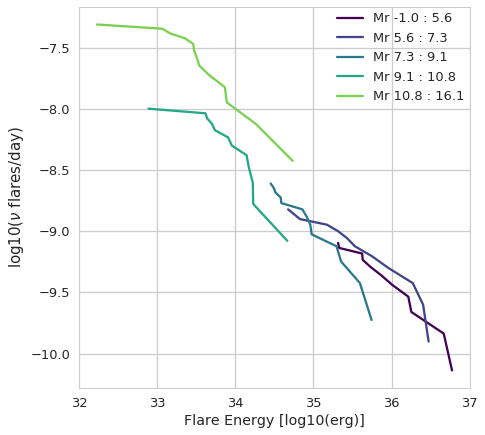

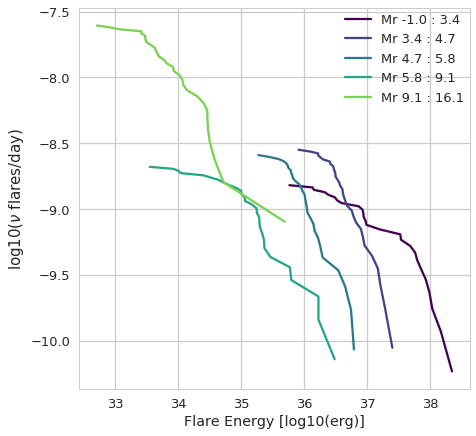

In [326]:
ffdiagram_binned(f436,fall436)
ffdiagram_binned(f437,fall437)
ffdiagram_binned(f488,fall488)
ffdiagram_binned(f489,fall489)
ffdiagram_binned(f538,fall538)
ffdiagram_binned(f539,fall539)
ffdiagram_binned(f540,fall540)
ffdiagram_binned(f541,fall541)
ffdiagram_binned(f591,fall591)
ffdiagram_binned(f592,fall592)
ffdiagram_binned(f638,fall638)
ffdiagram_binned(f639,fall639)
ffdiagram_binned(f685,fall685)
ffdiagram_binned(f686,fall686)

(array([26252266., 21063497., 22883886., 20471948.,  2674924.]),
 array([-0.9  ,  3.85 ,  5.3  ,  6.925,  9.6  , 15.9  ], dtype=float32),
 <a list of 5 Patch objects>)

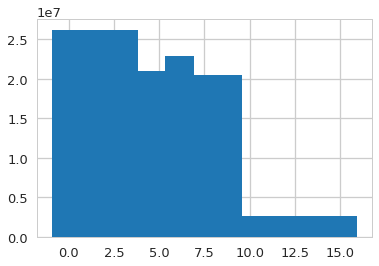

In [86]:
plt.hist(green_ids['Mr_50'],  bins=bins_Mr)


In [340]:
all_gal = galactic_centric_coords(green_gaia)

<Galactocentric Coordinate (galcen_coord=<ICRS Coordinate: (ra, dec) in deg
    (266.4051, -28.936175)>, galcen_distance=8.3 kpc, galcen_v_sun=(11.1, 232.24, 7.25) km / s, z_sun=27.0 pc, roll=0.0 deg): (x, y, z) in pc
    [(-2771.62848324, 3252.66054065, 142.54741016),
     (-6300.66576286, 1176.1182818 ,  68.67790588),
     (-3520.76523737, 2812.77760229, 127.16724096), ...,
     (-6138.57597258, 6807.51186443,  89.02590247),
     (-7343.86875457, 3011.63180309,  54.4715658 ),
     (-7526.14672991, 2437.48056677,  49.19882298)]>


TypeError: text() missing 1 required positional argument: 's'

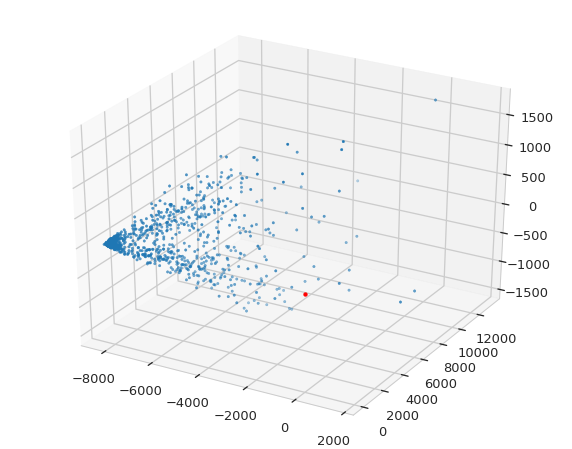

In [212]:
fig = plt.figure(figsize=(10,8))

ax = fig.add_subplot(111, projection='3d')


ax.scatter(galcoordflare['gal_x'], galcoordflare['gal_y'], galcoordflare['gal_z'], s=6)
ax.scatter(0,0,0, s=15, c='red', label='Galactic Center')
ax.text(0, 0, 0 'Galactic Center')

ax.set_xlabel('X PC')
ax.set_ylabel('Y PC')
ax.set_zlabel('Z PC')

plt.show()

In [336]:
zbins = Bins(galcoordflare,column='abs_gal_z',n_bins=3)
zbins

array([3.59741242e-02, 7.36080531e+01, 3.00772050e+02, 1.69604975e+03])

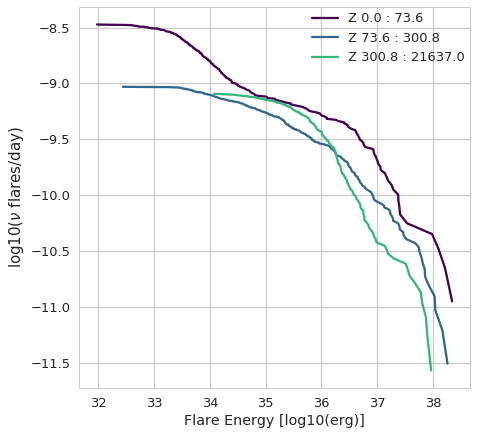

In [337]:
ffdiagram_binned(galcoordflare, all_gal, n_bins=3, bin_column='abs_gal_z', legendlabel='Z')

In [343]:

height1_flare = galcoordflare.loc[(galcoordflare['abs_gal_z'].values > zbins[0]) & (galcoordflare['abs_gal_z'].values < zbins[1])]
height2_flare = galcoordflare.loc[(galcoordflare['abs_gal_z'].values > zbins[1]) & (galcoordflare['abs_gal_z'].values < zbins[2])]
height3_flare = galcoordflare.loc[(galcoordflare['abs_gal_z'].values > zbins[2]) & (galcoordflare['abs_gal_z'].values < zbins[3])]

height1_all = all_gal.loc[(all_gal['abs_gal_z'].values < zbins[1])]
height2_all = all_gal.loc[(all_gal['abs_gal_z'].values > zbins[1]) & (all_gal['abs_gal_z'].values < zbins[2])]
height3_all = all_gal.loc[(all_gal['abs_gal_z'].values > zbins[2])]


In [354]:
mr_galbins= Bins(galcoordflare)

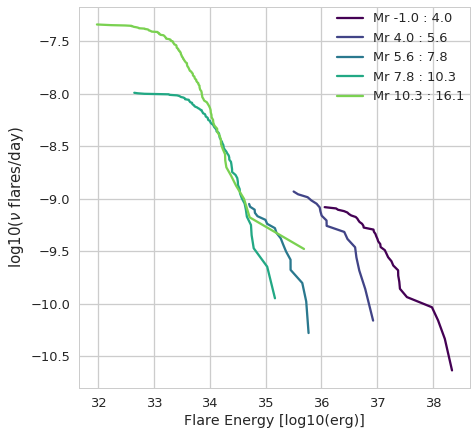

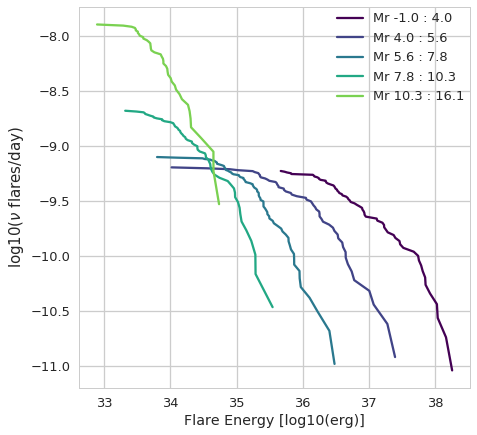

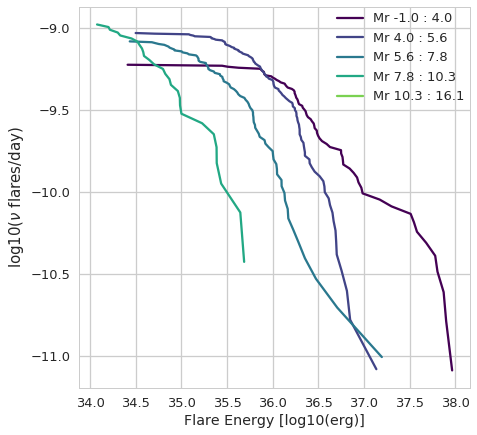

In [361]:
ffdiagram_binned(height1_flare, height1_all, bins=mr_galbins)
ffdiagram_binned(height2_flare, height2_all, bins=mr_galbins)
ffdiagram_binned(height3_flare, height3_all, bins=mr_galbins)

## Plot Flare for Poster 

In [ ]:
Double flare?? 592, id 20449
101553
look at 105228 double flare 638

In [215]:
flare_energy.head()

match_file      id  median_flux  median_mag  \
385  ztf_000436_zr_c10_q1_match_programid   42093   240.019135   20.353888   
394  ztf_000436_zr_c10_q1_match_programid  128206  1395.876953   18.442961   
310  ztf_000436_zr_c08_q2_match_programid   69805   235.879608   20.252689   
67   ztf_000436_zr_c02_q2_match_programid  158894  1279.103516   18.498152   
319  ztf_000436_zr_c08_q3_match_programid  103566   170.065338   20.580235   

         peak_flux     peak_time  peak_flux_index  frac_increase      fwhm  \
385  159656.421875  58348.312569              129     664.182068  0.017410   
394  186547.031250  58348.222500               99     132.641464  0.007292   
310   53353.054688  58348.266181              121     225.187653  0.008472   
67    17663.513672  58348.321759              192      12.809292  0.007768   
319    3526.831787  58348.299248               61      19.738098  0.015588   

      equivdur_new  peak_to_start_time  peak_to_end_time        st_dev  \
385  945394.016942            0.091910          0.014248  44376.671875   
394   77953.970367            0.002292          0.104780  34012.855469   
310   83411.499229            0.045972          0.061100   9289.862305   
67     8511.895042            0.101551          0.003218   3826.008301   
319   25856.310660            0.078588          0.026192   1057.480103   

     ave_flux_err  rel_flux_err                fl_indx_new  \
385    239.652256      0.998471  [124 125 126 127 128 129]   
394    161.674829      0.115823                 [97 98 99]   
310     76.756270      0.325404              [120 121 122]   
67      93.464256      0.073070      [190 191 192 193 194]   
319     48.235135      0.283627           [58 59 60 61 62]   

                       isflare  width_flag    aic_flare    chi_flare  \
385  [124 125 126 127 128 129]           0  8683.010411  8675.010337   
394                 [97 98 99]           0  4033.274745  4025.274760   
310              [120 121 122]           0  1807.935898  1799.935881   
67       [190 191 192 193 194]           2  1340.626195  1332.626199   
319           [58 59 60 61 62]           0   328.530290   320.530284   

     dof_flare   red_flare   aic_gauss   chi_gauss  dof_gauss  red_gauss  \
385         13  667.308487  186.698169  178.698169         13  13.746013   
394         11  365.934069  322.114354  314.114353         11  28.555850   
310         12  149.994657   43.657220   35.657220         12   2.971435   
67          17   78.389776  122.927105  114.927104         17   6.760418   
319         15   21.368686   14.866094    6.866094         15   0.457740   

          exp_comp    perc_comp                fl_indx_old   equivdur_old  \
385   0.000000e+00 -8496.312242  [124 125 126 127 128 129]  582818.995841   
394   0.000000e+00 -3711.160391                 [97 98 99]   77614.526639   
310   0.000000e+00 -1764.278678              [120 121 122]   83010.916554   
67   3.801915e-265 -1217.699089      [190 191 192 193 194]    8414.152661   
319   7.739008e-69  -313.664196           [58 59 60 61 62]   26137.374274   

             ra       dec      xpos      ypos    flare_time      end_time  \
385  285.543599 -1.478959  2238.372  2257.195  58348.308264  58348.326643   
394  285.550656 -1.468194  2207.455  2235.024  58348.220486  58348.327107   
310  280.829078 -3.475827  2692.057  2595.457  58348.264618  58348.327107   
67   285.166336 -5.409366   491.710  2602.937  58348.319745  58348.324803   
319  281.505006 -4.064455   287.844  1592.388  58348.295857  58348.325266   

     flare_end_diff  n_catflags          axs_id         matchid  ztf_n_obs  \
385        0.014248           2  10436362042093  10436361107415        178   
394        0.104780           1  10436362128206  10436361131401        324   
310        0.060648           1  10436292069805  10435162043417        289   
67         0.001377           9  10436052158894  10436052158894        305   
319        0.025729           1  10436302103566  10436302103566      

(array([11669.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,   742.]),
 array([0. , 0.2, 0.4, 0.6, 0.8, 1. , 1.2, 1.4, 1.6, 1.8, 2. ]),
 <a list of 10 Patch objects>)

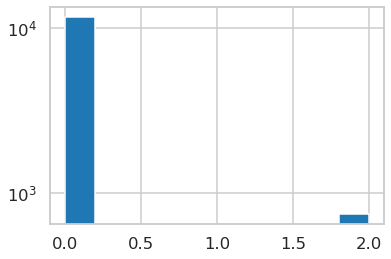

In [216]:
plt.hist(flare_energy['width_flag'], log=True)

(0, 0.001)

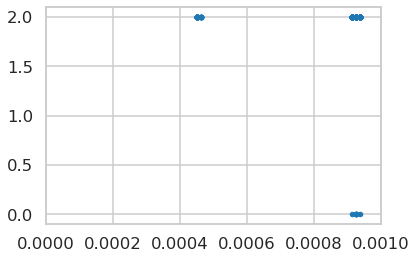

In [175]:
plt.plot(flare_energy['peak_to_end_time'],flare_energy['width_flag'], 
         linestyle='none', marker='.'
        )
plt.xlim(0,0.001)

In [176]:
0.001

1.296

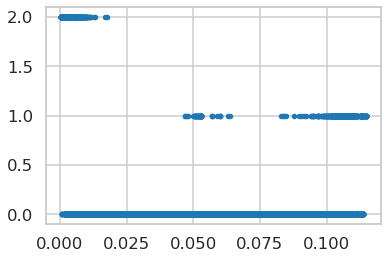

In [255]:
plt.plot(flare_energy['peak_to_end_time'],flare_energy['width_flag'], 
         linestyle='none', marker='.'
        )

In [392]:
flare_energy.loc[(flare_energy['id']==128206)]# &
                 #(flare_energy['peak_to_end_time']>0.075)]

match_file      id  median_flux  median_mag  \
394  ztf_000436_zr_c10_q1_match_programid  128206  1395.876953   18.442961   

        peak_flux   peak_time  peak_flux_index  frac_increase      fwhm  \
394  186547.03125  58348.2225               99     132.641464  0.007292   

     equivdur_new  peak_to_start_time  peak_to_end_time        st_dev  \
394  77953.970367            0.002292           0.10478  34012.855469   

     ave_flux_err  rel_flux_err fl_indx_new     isflare  width_flag  \
394    161.674829      0.115823  [97 98 99]  [97 98 99]           0   

       aic_flare   chi_flare  dof_flare   red_flare   aic_gauss   chi_gauss  \
394  4033.274745  4025.27476         11  365.934069  322.114354  314.114353   

     dof_gauss  red_gauss  exp_comp    perc_comp fl_indx_old  equivdur_old  \
394         11   28.55585       0.0 -3711.160391  [97 98 99]  77614.526639   

             ra       dec      xpos      ypos    flare_time      end_time  \
394  285.550656 -1.468194  2207.455  2235.024  58348.220486  58348.327107   

     flare_end_diff  n_catflags          axs_id         matchid  ztf_n_obs  \
394         0.10478           1  10436362128206  10436361131401        324   

     exploded_unique_matchids_index  unique_matchids_exploded  \
394                               1            10436362128206   

               source_id     bp_rp  phot_g_mean_mag  \
394  4262073863820774272  2.172035        18.480354   

     phot_g_mean_flux_over_error  phot_bp_mean_mag  phot_rp_mean_mag  a_g_val  \
394                   376.852753           19.3118         17.139765      NaN   

     parallax  parallax_error  lum_val   axsdist     dm_16      E_16  Mr_16  \
394  0.576118        0.267289      NaN  0.000001  10.58662  0.908375    1.0   

     FeH_16      dm_50      E_50  Mr_50  FeH_50      dm_84     E_84  Mr_84  \
394   -0.75  13.779629  0.988078  2.175  -0.475  15.164804  1.06487    5.4   

     FeH_84              gaia_id        gal_x        gal_y       gal_z  \
394   -0.25  4262073863820774272 -3518.807379  3087.983171 -293.282911   

      abs_gal_z        gal_r        lum  flare_energy  bp_rp_mag   g_mag  \
394  293.282911  4681.628502  34.454447     39.346285   0.879068  5.4434   

          A_g      A_bp      A_rp   nobs     ctime  
394  1.843124  2.899098  1.606131  215.0  0.154921

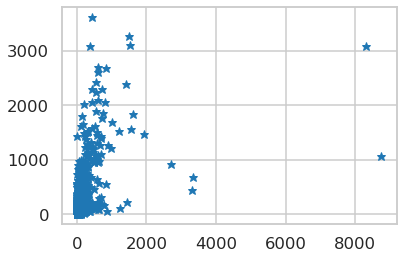

In [111]:
plt.plot(-1*flare_energy_lim['loglike_flare'], -1*flare_energy_lim['loglike_const'], linestyle='none', marker='*')
#plt.xlim(0,5000)
#plt.ylim(0,5000)

(array([1412., 3610., 3452., 1938., 1055.,  551.,  232.,  102.,   47.,
          12.]),
 array([  0. ,  10.1,  20.2,  30.3,  40.4,  50.5,  60.6,  70.7,  80.8,
         90.9, 101. ]),
 <a list of 10 Patch objects>)

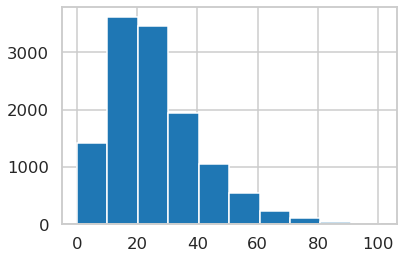

In [103]:
plt.hist(flare_energy['dof_flare'])

In [69]:
flare_energy_lim.head()

Unnamed: 0                            match_file      id  median_flux  \
5           0  ztf_000436_zr_c12_q3_match_programid    9854   174.887115   
6           0  ztf_000436_zr_c04_q1_match_programid   73711   690.024292   
7           0  ztf_000436_zr_c11_q3_match_programid  124732   158.606308   
8           0  ztf_000436_zr_c04_q1_match_programid   73652   693.232422   
9           0  ztf_000436_zr_c08_q2_match_programid   29812  1656.116089   

   median_mag    start_time      end_time  duration     peak_flux  \
5   20.561226  58348.292361  58348.327280  0.034919   1340.240723   
6   19.127897  58348.262500  58348.326817  0.064317   3775.941895   
7   20.812290  58348.227558  58348.294201  0.066644   1397.167847   
8   19.129578  58348.256991  58348.319919  0.062928   3885.451416   
9   18.140282  58347.299317  58347.326852  0.027535  52863.867188   

      peak_time  peak_flux_index  frac_increase      fwhm      equivdur  \
5  58348.305220              134       6.663462  0.013012   6179.104552   
6  58348.272153              147       4.472187  0.010944   3970.734246   
7  58348.233056               70       7.809031  0.012347   5626.423442   
8  58348.266632              140       4.604832  0.010924   3970.026093   
9  58347.308947               72      30.920387  0.010197  18651.001904   

   equivdur_err  peak_to_start_time  peak_to_end_time        st_dev  \
5      0.006870            0.085012          0.022060    243.539307   
6      0.002147            0.051944          0.055127    739.456238   
7      0.002858            0.012847          0.094225    340.547363   
8      0.002192            0.046424          0.060648    796.664978   
9      0.004980            0.042697          0.017905  11330.685547   

   ave_flux_err  rel_ave_flux_err  ave_flux_err_flare  rel_ave_flux_err_flare  \
5     41.816570          0.239106           68.511755                0.391748   
6     73.438679          0.106429           89.059837                0.129068   
7     35.661019          0.224840           37.961304                0.239343   
8     72.113647          0.104025           90.974152                0.131232   
9    100.390796          0.060618          286.206188                0.172818   

   med_flux_err  rel_med_flux_err  med_flux_err_flare  rel_med_flux_err_flare  \
5     33.631111          0.192302           30.015827                0.171630   
6     66.750320          0.096736           74.868011                0.108501   
7     34.133091          0.215206           35.017193                0.220781   
8     64.354469          0.092832           69.400703                0.100112   
9     77.996971          0.047096           86.513878                0.052239   

                                 fl_indx  \
5              [131 132 133 134 135 136]   
6      [146 147 148 149 150 151 152 153]   
7              [64 65 66 67 68 69 70 71]   
8  [136 137 138 139 140 141 142 143 144]   
9                             [72 73 74]   

                                             isflare  width_flag    AIC_flare  \
5  [125 126 127 128 129 130 131 132 133 134 135 1...           0   138.544044   
6  [138 139 140 141 142 143 144 145 146 147 148 1...           0   675.248359   
7  [ 64  65  66  67  68  69  70  71  72  73  74  ...           0   527.519901   
8  [132 133 134 135 136 137 138 139 140 141 142 1...           0   719.735847   
9  [66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 ...           0  3133.698864   

   loglike_flare  chisq_err_flare  chisq_exp_flare  dof_flare    AIC_gauss  \
5     -65.272022       130.544044     1.852082e+04         23    58.893281   
6    -333.624180       667.248368     3.216087e+04         60    90.163332   
7    -259.759950       519.519902     2.718679e+03         56    80.057637   
8    -355.867924       711.735846     1.249396e+04         59    92.852303   
9   -1562.849432      3125.698936     3.253734e+06         18  1463.071486   

   loglike_gauss  chisq_err_gauss  chisq_exp_gauss  dof_ga

In [139]:
def veiwlimitedcurves(flare_energy):
    #dflim = flare_energy.iloc[:100]
    #dflim = flare_energy.loc[((flare_energy['AIC_flare'] - flare_energy['AIC_const']) > 0) & 
    #                         ((flare_energy['AIC_gauss'] - flare_energy['AIC_const']) > 0) ]
    dflim = flare_energy.loc[np.isnan(flare_energy['bp_rp_mag'])]
    #dflim = flare_energy.loc[(flare_energy['chisq_err_flare']/flare_energy['chisq_err_const']>1) & 
    #                         (flare_energy['chisq_err_gauss']/flare_energy['chisq_err_const']>1)]
    
   # dflim = flare_energy.loc[(flare_energy['chisq_exp_flare']/flare_energy['chisq_exp_gauss']<1)]
                            
    
    
    #dflim = flare_energy.loc[flare_energy['chisq_exp_flare']/flare_energy['chisq_exp_gauss']>5]

    #dflim = flare_energy.loc[(flare_energy['dof_flare'])<8]#&(flare_energy['peak_to_end_time']<0.0025)]
    #dflim = flare_energy.loc[(flare_energy['match_file']=='ztf_000436_zr_c02_q1_match_programid')]
    #dflim = flare_energy.loc[(flare_energy['flare_energy']>38)]# &(flare_energy['rel_flux_err']>=.25)]
    #dflim = flare_energy.loc[flare_energy['frac_increase']*100 / (flare_energy['fwhm']*24*60) > 100]
    #Show
    #dflim = flare_energy.loc[(flare_energy['peak_time']  >= 58343.291654)&(flare_energy['peak_time']  < 58343.291656) &
    #                         (flare_energy['match_file']  == 'ztf_000592_zr_c12_q2_match_programid')]

    #dflim = flare_energy.loc[((flare_energy['red_gauss'] - flare_energy['red_flare']) / flare_energy['red_flare'] > 2)&
     #                         (flre_energy['dof_flare']>15)&
      #                        (flare_energy['E_50']>0) ]
                              #(flare_energy['flare_energy']>38)]
    
    #dflim = flare_energy.loc[(flare_energy['flare_end_diff']>0.05)
    #                         &(flare_energy['E_50']>0) 
    ##                         &(flare_energy['A_bp']<1) 
     #                        &(flare_energy['A_rp']<1) 
     #                        &(flare_energy['dof_flare']>15) 
     ##                        #(flare_energy['red_gauss']<.3)
      #                       #&((flare_energy['red_gauss'] - flare_energy['red_flare']) / flare_energy['red_gauss'] < -3) 
      #                      &(flare_energy['red_gauss'] >10)
      #                      &(flare_energy['red_flare'] >10)
      #                      #(flare_energy['phot_g_mean_mag']>20)
      #                      ]                         

    
    print(len(flare_energy)-len(dflim),'dlim:',len(dflim))
    dflim = dflim.iloc[:100]

    for i in range(len(dflim)):
        folder = 'found_flares_' + dflim['match_file'].values[i].split('_')[1][3:] + '/'
        filepath = folder + dflim['match_file'].values[i] + '_id_' + str(dflim['id'].values[i]) + '*'
        filepath = glob.glob(filepath)
        print((dflim['chisq_err_flare'].values[i]/dflim['chisq_err_const'].values[i]),
              (dflim['chisq_err_gauss'].values[i]/dflim['chisq_err_const'].values[i]))
        for j in filepath:
            display(Image(filename=j)) 

            
            

1478 dlim: 21
0.22495561673060865 0.2522597897374213


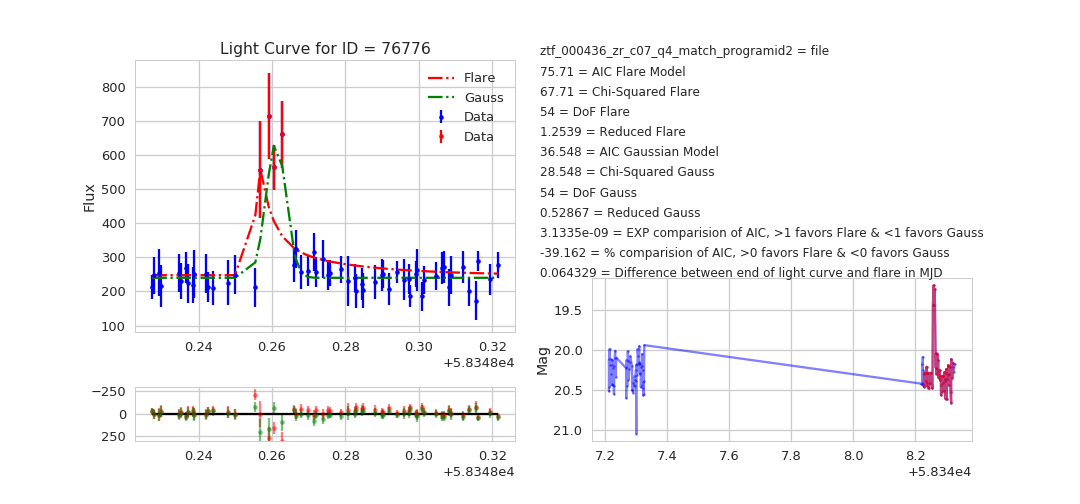

0.21193533782462573 0.2233288629410342


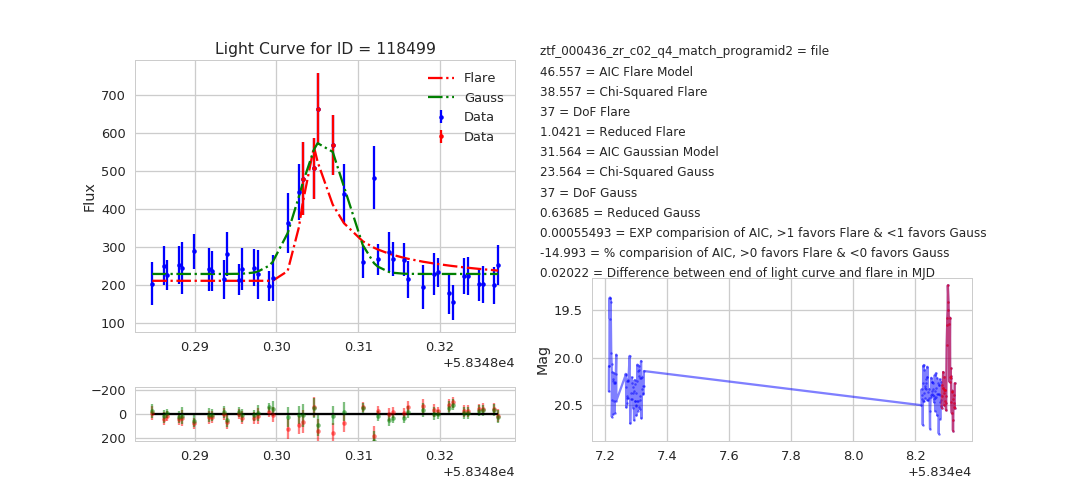

0.04959794488141617 0.4434859189743007


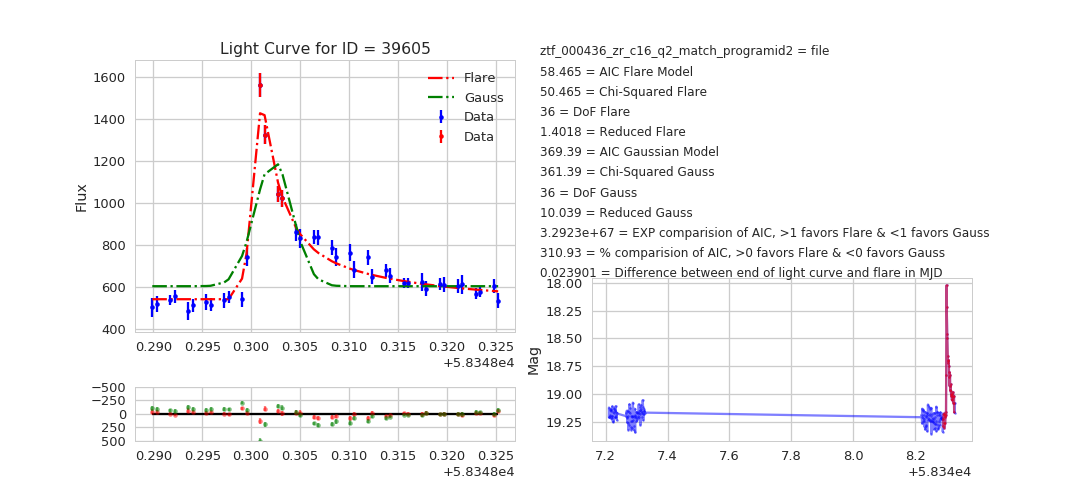

0.30365399051713593 0.3774241723742856


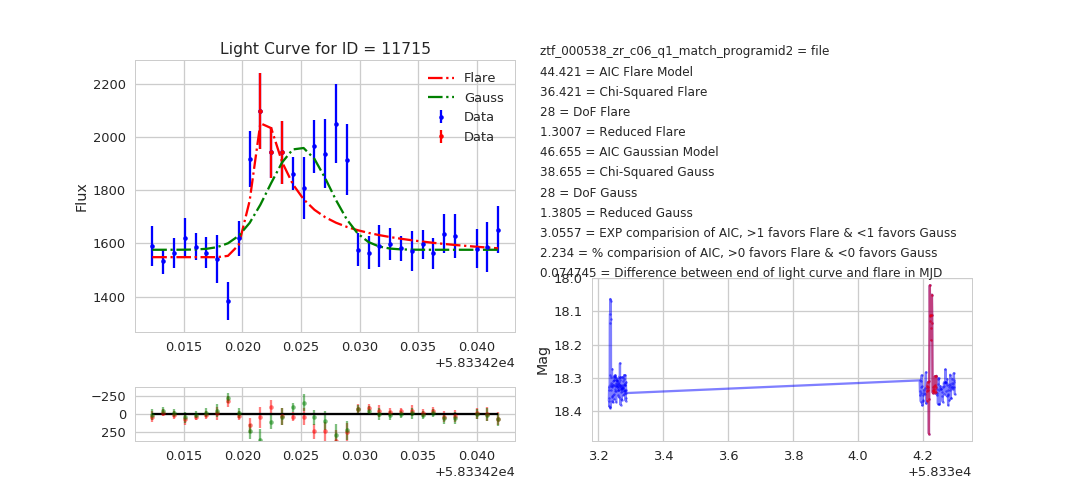

0.5208193481216438 0.7936166130694049


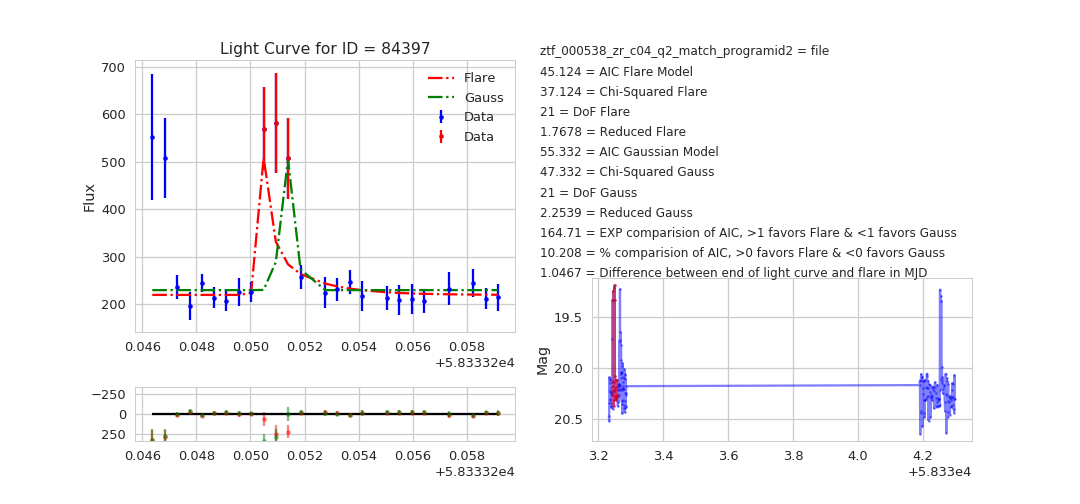

0.6552685538775704 0.688286253827214


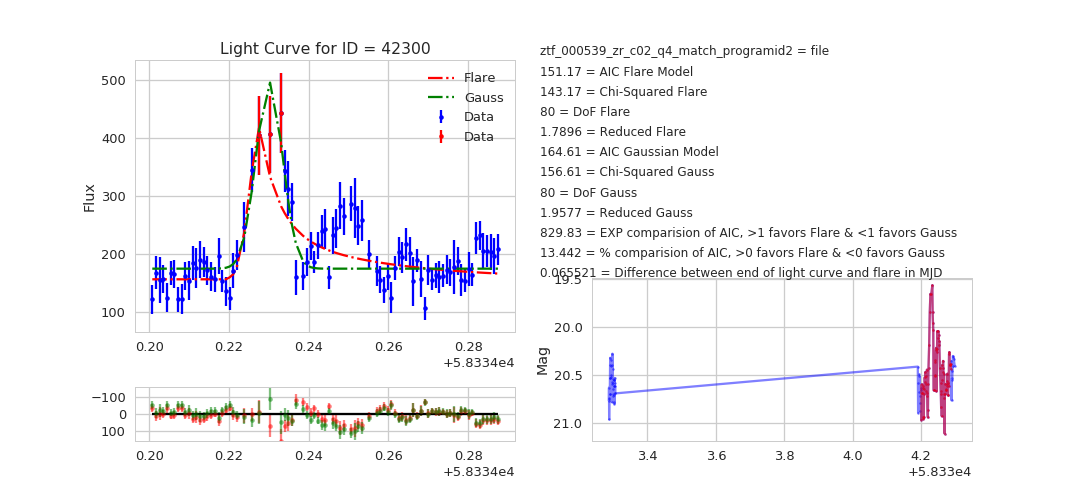

0.5346551684622846 0.8000272050259909


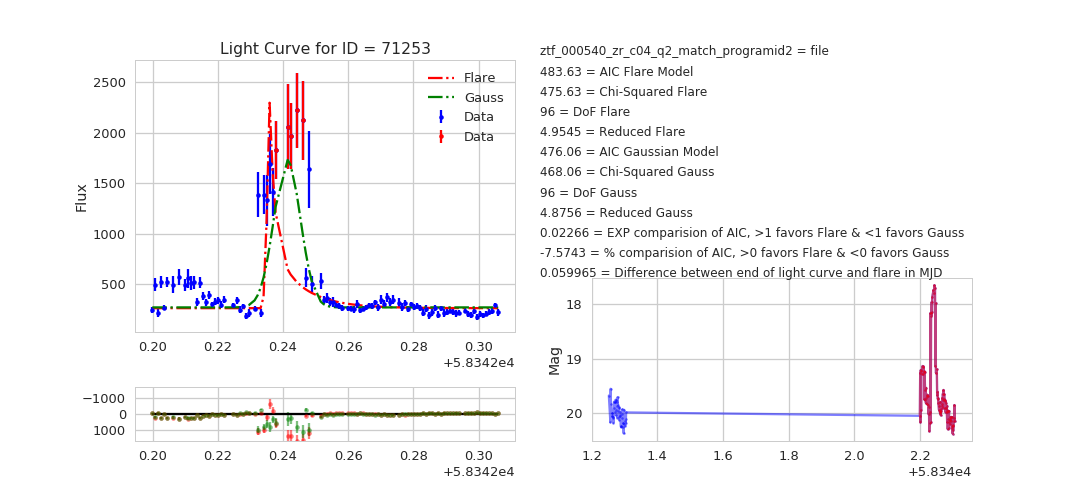

0.6190385721566665 0.7507674849663409


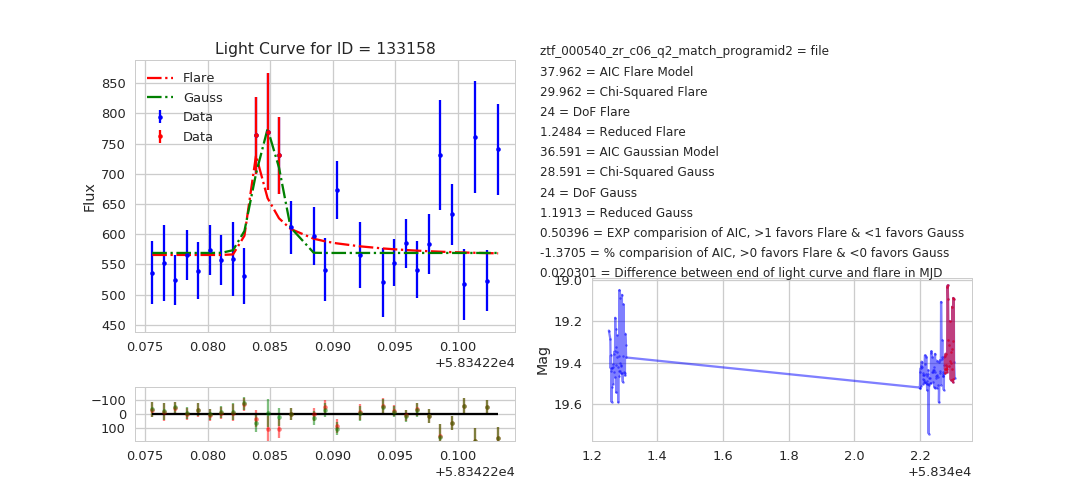

0.14748528504140532 0.39506147231444017


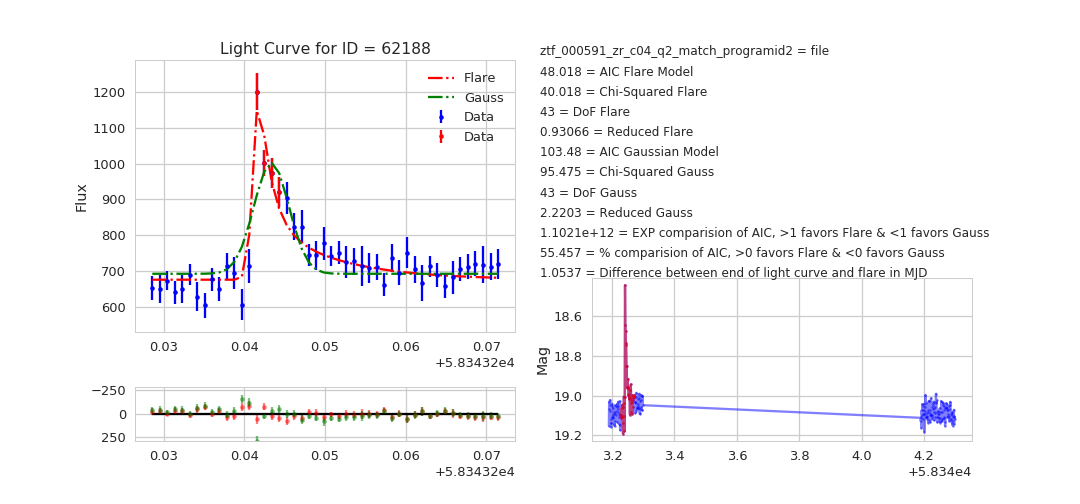

0.10733371986284095 0.335746115217833


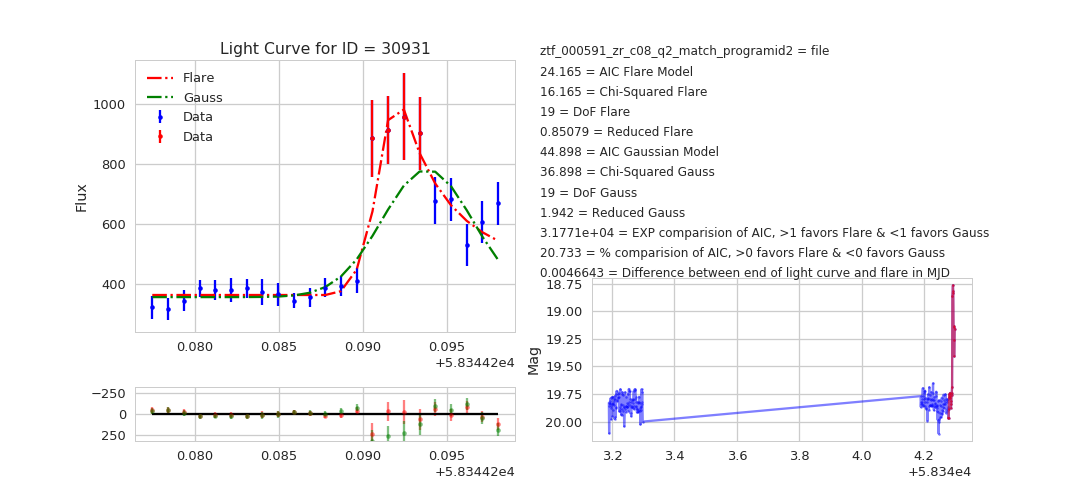

0.26781000118870907 0.33232630822746423


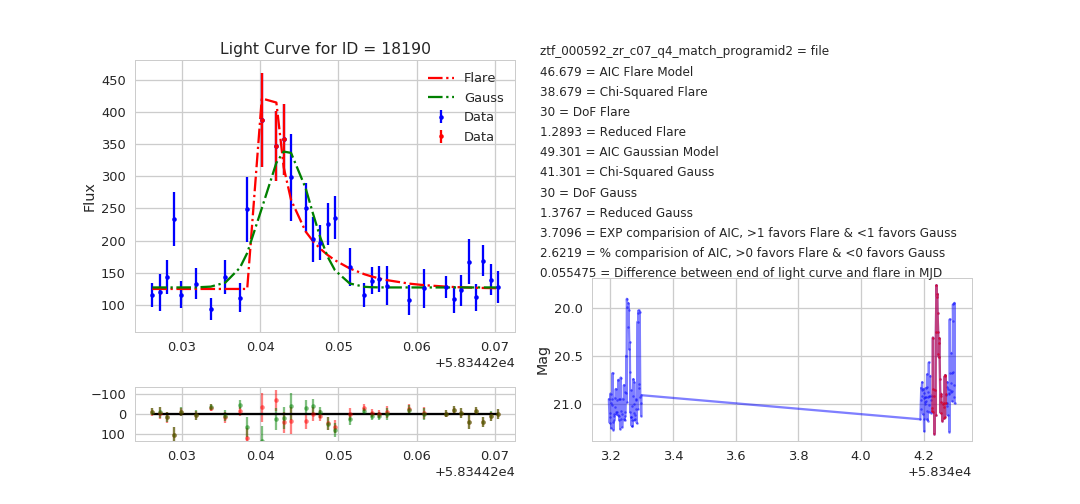

0.4602602940684436 0.5316675759559784


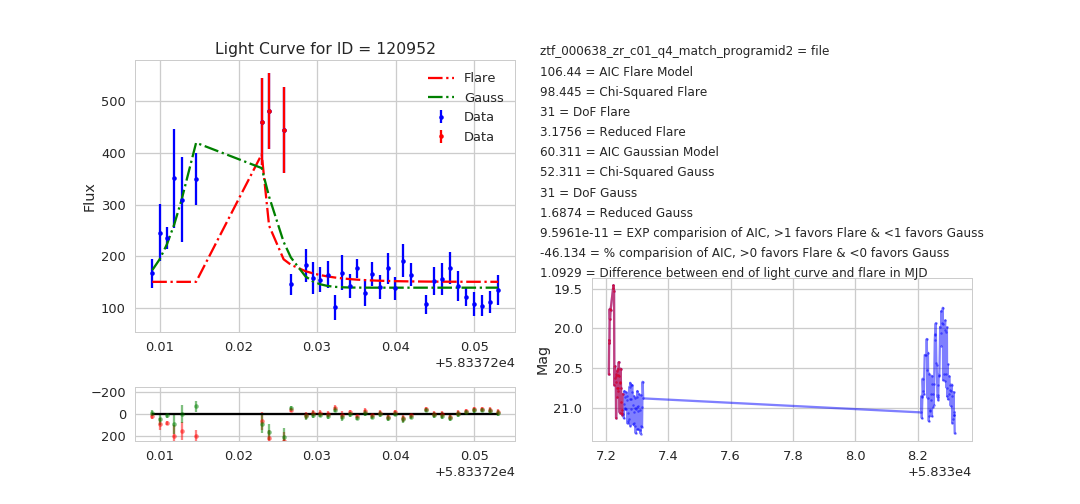

0.2312713429952038 0.2537912826144567


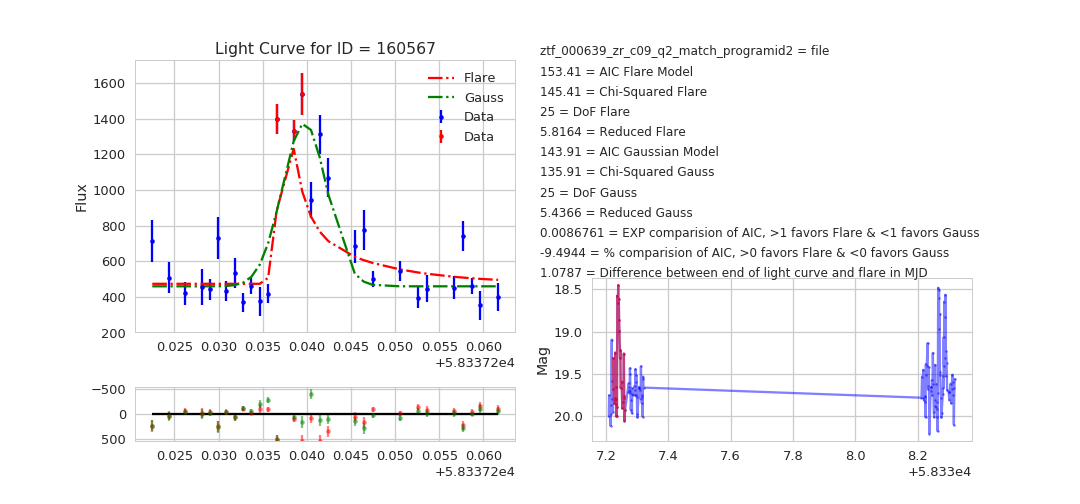

0.444193436490699 0.4500781297226261


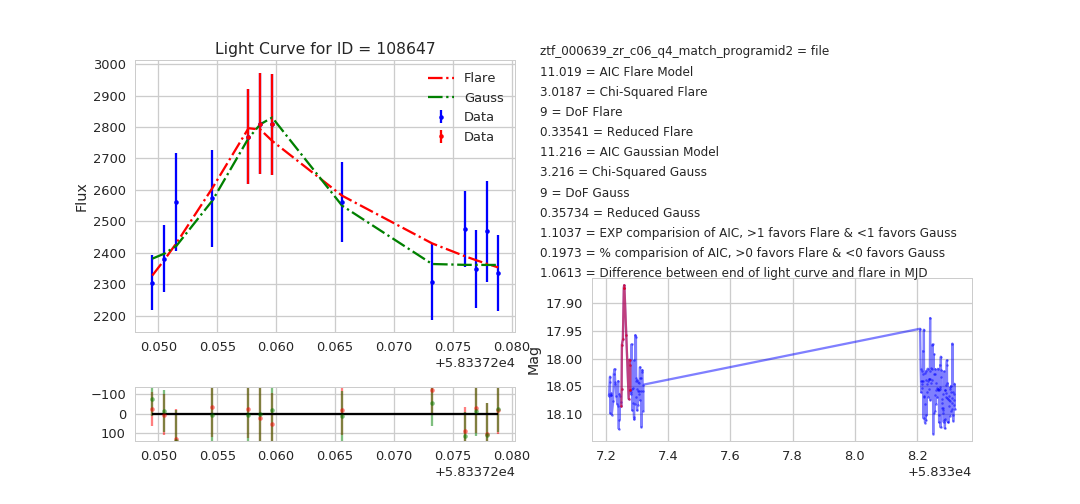

0.23464115558638868 0.4432125538784803


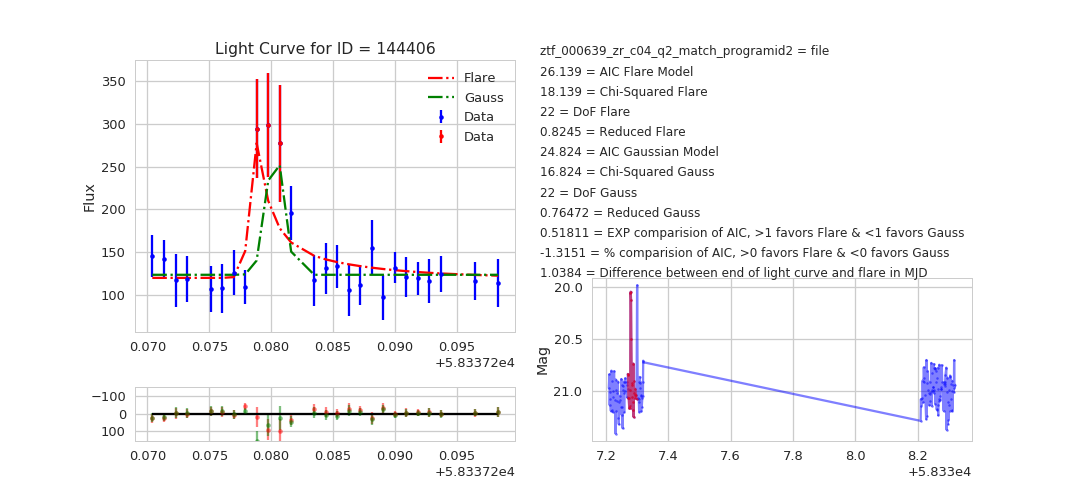

0.2832797851081319 0.6336646951403825


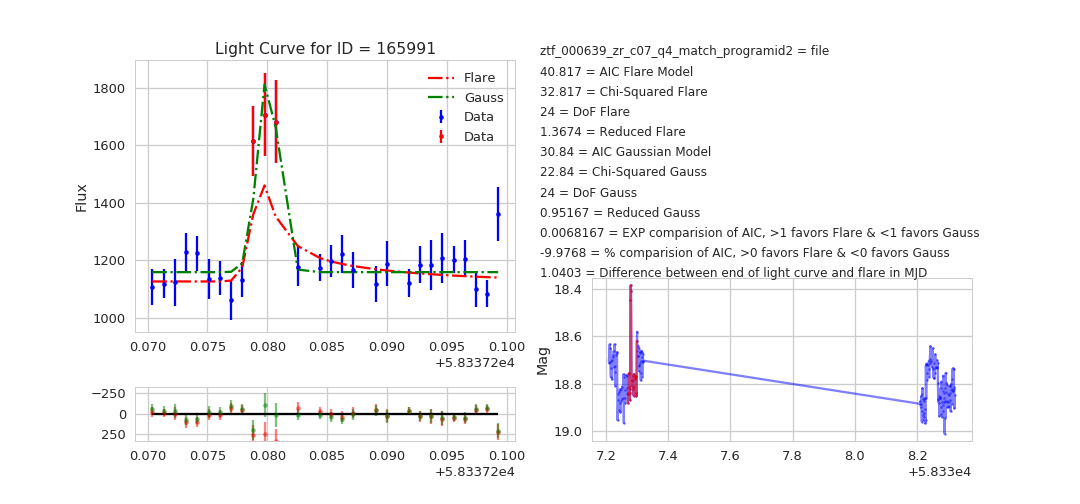

0.5645550492613933 0.7133217726196854


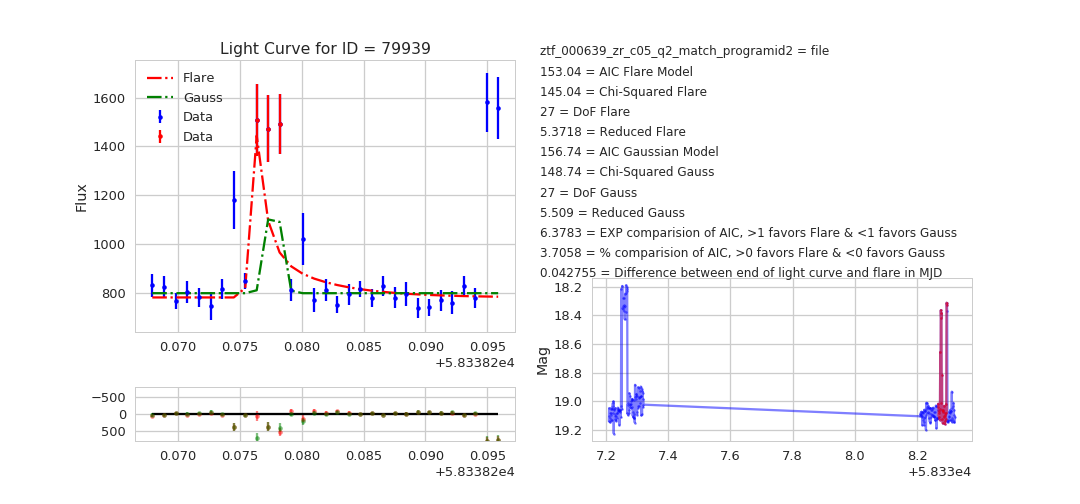

0.019757960244771725 0.19785772442569086


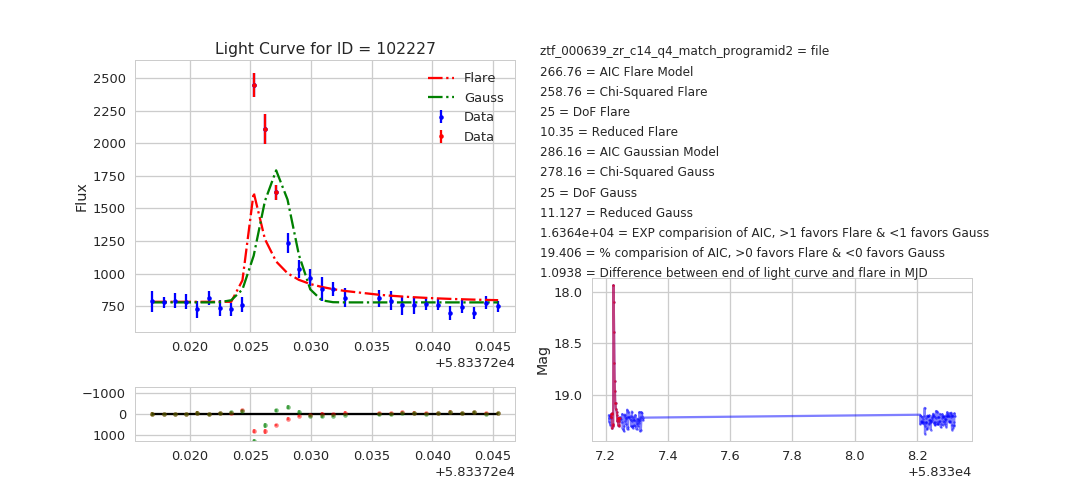

0.4740058981612462 0.5873430692157744
0.4178579346655218 0.48594516896802337
0.33302418076415974 0.48111664369168905


In [141]:
veiwlimitedcurves(flare_energy_mod)  

In [286]:
flare_12400 = flare_energy_lim.loc[flare_energy_lim['id']==12400]

In [290]:
print((flare_12400['chisq_err_flare'].values/flare_12400['chisq_err_const'].values),
      (flare_12400['chisq_err_gauss'].values/flare_12400['chisq_err_const'].values))

[1.17794263] [0.57621901]


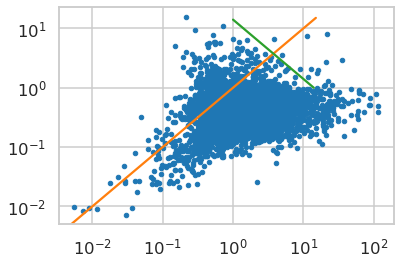

In [251]:
plt.loglog(flare_energy_lim['chisq_exp_flare']/flare_energy_lim['chisq_exp_gauss'],flare_energy_lim['chisq_err_flare']/flare_energy_lim['chisq_err_const'],linestyle='none',marker='.')


#plt.xlim(0,1)
#plt.ylim(0,1)

In [253]:
flare_energy_lim['chisq_exp_flare'].values

array([1.85208201e+04, 3.21608714e+04, 2.71867869e+03, ...,
       2.60558034e+01, 3.14401472e+01, 4.32292817e+02])

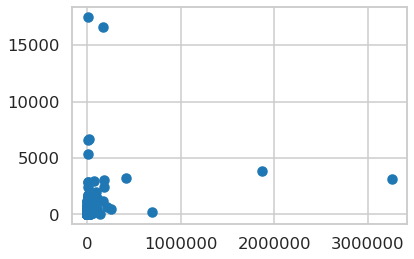

In [241]:
plt.scatter(flare_energy_lim['chisq_exp_flare']flare_energy_lim['chisq_err_flare'])
#plt.scatter(flare_energy_lim['chisq_exp_const'],flare_energy_lim['chisq_err_const'])


In [155]:
flare_energy_lim.head()

Unnamed: 0                            match_file      id  median_flux  \
5           0  ztf_000436_zr_c12_q3_match_programid    9854   174.887115   
6           0  ztf_000436_zr_c04_q1_match_programid   73711   690.024292   
7           0  ztf_000436_zr_c11_q3_match_programid  124732   158.606308   
8           0  ztf_000436_zr_c04_q1_match_programid   73652   693.232422   
9           0  ztf_000436_zr_c08_q2_match_programid   29812  1656.116089   

   median_mag    start_time      end_time  duration     peak_flux  \
5   20.561226  58348.292361  58348.327280  0.034919   1340.240723   
6   19.127897  58348.262500  58348.326817  0.064317   3775.941895   
7   20.812290  58348.227558  58348.294201  0.066644   1397.167847   
8   19.129578  58348.256991  58348.319919  0.062928   3885.451416   
9   18.140282  58347.299317  58347.326852  0.027535  52863.867188   

      peak_time  peak_flux_index  frac_increase      fwhm      equivdur  \
5  58348.305220              134       6.663462  0.013012   6179.104552   
6  58348.272153              147       4.472187  0.010944   3970.734246   
7  58348.233056               70       7.809031  0.012347   5626.423442   
8  58348.266632              140       4.604832  0.010924   3970.026093   
9  58347.308947               72      30.920387  0.010197  18651.001904   

   equivdur_err  peak_to_start_time  peak_to_end_time        st_dev  \
5      0.006870            0.085012          0.022060    243.539307   
6      0.002147            0.051944          0.055127    739.456238   
7      0.002858            0.012847          0.094225    340.547363   
8      0.002192            0.046424          0.060648    796.664978   
9      0.004980            0.042697          0.017905  11330.685547   

   ave_flux_err  rel_ave_flux_err  ave_flux_err_flare  rel_ave_flux_err_flare  \
5     41.816570          0.239106           68.511755                0.391748   
6     73.438679          0.106429           89.059837                0.129068   
7     35.661019          0.224840           37.961304                0.239343   
8     72.113647          0.104025           90.974152                0.131232   
9    100.390796          0.060618          286.206188                0.172818   

   med_flux_err  rel_med_flux_err  med_flux_err_flare  rel_med_flux_err_flare  \
5     33.631111          0.192302           30.015827                0.171630   
6     66.750320          0.096736           74.868011                0.108501   
7     34.133091          0.215206           35.017193                0.220781   
8     64.354469          0.092832           69.400703                0.100112   
9     77.996971          0.047096           86.513878                0.052239   

                                 fl_indx  \
5              [131 132 133 134 135 136]   
6      [146 147 148 149 150 151 152 153]   
7              [64 65 66 67 68 69 70 71]   
8  [136 137 138 139 140 141 142 143 144]   
9                             [72 73 74]   

                                             isflare  width_flag    AIC_flare  \
5  [125 126 127 128 129 130 131 132 133 134 135 1...           0   138.544044   
6  [138 139 140 141 142 143 144 145 146 147 148 1...           0   675.248359   
7  [ 64  65  66  67  68  69  70  71  72  73  74  ...           0   527.519901   
8  [132 133 134 135 136 137 138 139 140 141 142 1...           0   719.735847   
9  [66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 ...           0  3133.698864   

   loglike_flare  chisq_err_flare  chisq_exp_flare  dof_flare    AIC_gauss  \
5     -65.272022       130.544044     1.852082e+04         23    58.893281   
6    -333.624180       667.248368     3.216087e+04         60    90.163332   
7    -259.759950       519.519902     2.718679e+03         56    80.057637   
8    -355.867924       711.735846     1.249396e+04         59    92.852303   
9   -1562.849432      3125.698936     3.253734e+06         18  1463.071486   

   loglike_gauss  chisq_err_gauss  chisq_exp_gauss  dof_ga

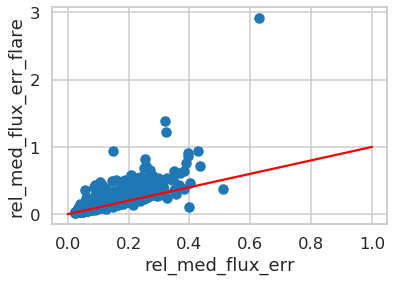

In [359]:
plt.scatter(flare_energy_lim['rel_ave_flux_err'], flare_energy_lim['rel_ave_flux_err_flare'])

plt.plot([0,1],[0,1], color='red')
plt.xlabel('rel_med_flux_err')
plt.ylabel('rel_med_flux_err_flare')
plt.show()




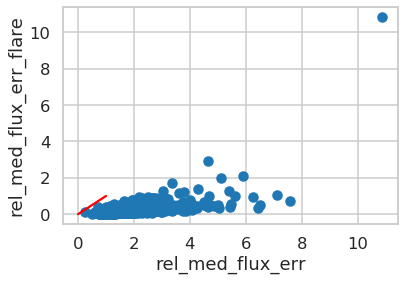

In [328]:
plt.scatter(flare_energy['rel_ave_flux_err_flare']/flare_energy['rel_ave_flux_err'], flare_energy['rel_ave_flux_err_flare'])

plt.plot([0,1],[0,1], color='red')
plt.xlabel('rel_med_flux_err')
plt.ylabel('rel_med_flux_err_flare')
plt.show()


(array([452., 179.,  24.,   6.,   6.,   2.,   1.,   0.,   1.,   1.]),
 array([0.72625679, 1.19547473, 1.66469267, 2.13391061, 2.60312855,
        3.07234649, 3.54156443, 4.01078237, 4.48000031, 4.94921825,
        5.41843619]),
 <a list of 10 Patch objects>)

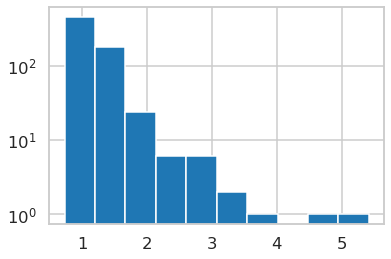

In [251]:
plt.hist(statspractice_4362['ave_flux_err_flare']/statspractice_4362['ave_flux_err'], log=True)

In [ ]:
plt.hist(statspractice_4362['med_flux_err_flare']/statspractice_4362['med_flux_err'], log=True)

In [236]:
statspractice_4362 = statspractice_436.loc[statspractice_436['rel_med_flux_err_flare'] /
                                           statspractice_436['rel_med_flux_err'] <50]


Two sources given to thomas
1772 (285.128883, 7.348190) 58340.27442131111

54288 (295.302942,18.775016)58343.19447921111 

38664 (275.647239 14.669014) 58334.212476

In [ ]:
look at 105228 double flare 638

In [413]:
#ids used: 36262, 12173, 4720
#idflare =2286, 54288, 12173, 38211
idflare = 112132

In [282]:
flare_nan.head()

matchid          ra       dec  ztf_n_obs  \
70   10436422002553  283.360287 -1.747409        370   
93   10436291036674  281.170522 -3.030427        277   
127  10436331084151  286.961997 -0.884781        216   
181  10436391029494  285.880449 -2.223797        357   
189  10436192079952  287.648830 -4.309308        318   

     exploded_unique_matchids_index  unique_matchids_exploded  \
70                                0            10436422002553   
93                                1            10436292056445   
127                               0            10436332136162   
181                               0            10436392033005   
189                               0            10436192079952   

                               match_file      id   aic_flare   chi_flare  \
70   ztf_000436_zr_c11_q3_match_programid    2553  166.759411  158.759412   
93   ztf_000436_zr_c08_q2_match_programid   56445   60.500177   52.500178   
127  ztf_000436_zr_c09_q2_match_programid  136162  148.985282  140.985281   
181  ztf_000436_zr_c10_q4_match_programid   33005  688.016321  680.016325   
189  ztf_000436_zr_c05_q4_match_programid   79952   57.556521   49.556521   

     dof_flare  red_flare   aic_gauss   chi_gauss  dof_gauss  red_gauss  \
70          61   2.602613  159.500806  151.500807         61   2.483620   
93          23   2.282616   48.052388   40.052389         23   1.741408   
127         23   6.129795  154.840954  146.840953         23   6.384389   
181         25  27.200653  261.501848  253.501847         25  10.140074   
189         29   1.708846   31.223350   23.223350         29   0.800805   

         exp_comp   perc_comp           fl_indx    equivdur      xpos  \
70   2.653468e-02   -7.258605  [52 53 54 55 56]  -44.884977   347.951   
93   1.981513e-03  -12.447789           [5 6 7]  -41.770163  1486.033   
127  1.868715e+01    5.855672  [16 17 18 19 20] -160.556837   731.409   
181  2.418572e-93 -426.514473        [28 29 30]  -94.020590  1042.122   
189  1.913483e-06  -26.333171     [2 3 4 5 6 7] -390.746796  1375.406   

         ypos    flare_time      end_time  flare_end_diff  n_catflags  \
70    396.071  58347.286285  58348.327107        1.037141           7   
93   1256.981  58347.216482  58348.327107        1.107419           1   
127   395.024  58347.225660  58348.327107        1.097778           0   
181  2079.081  58347.277558  58348.327107        1.047708          38   
189  2697.260  58347.212801  58348.327107        1.109248           1   

             axs_id            source_id     bp_rp  phot_g_mean_mag  \
70   10436422002553  4265190738776925568  1.866411        18.000988   
93   10436292056445  4258657131385123712  2.212767        19.635504   
127  10436332136162  4262531157522874880  1.114628        20.541986   
181  10436392033005  4261772387130734336  1.481882        17.479877   
189  10436192079952  4212408889196025088  1.642178        19.328209   

     phot_g_mean_flux_over_error  phot_bp_mean_mag  phot_rp_mean_mag  a_g_val  \
70                    517.177063         18.879023         17.012611      NaN   
93                    202.284012         20.500528         18.287762      NaN   
127                    64.989136         20.492418         19.377790      NaN   
181                   302.981171         18.105474         16.623592      NaN   
189                   219.814392         20.126112         18.483934      NaN   

     parallax  parallax_error  lum_val       axsdist      dm_16      E_16  \
70   0.980935        0.189605      NaN  3.430661e-07  13.137630  0.577104   
93   0.188442        0.515208      NaN  9.164342e-07  10.246515  0.576381   
127 -1.739898        1.762583      NaN  2.280105e-07  13.147808  0.565990   
181  0.741314        0.199605      NaN  5.197638e-07  10.849063  0.278354   
189 -0.010759        0.344708      NaN  8.814565e-07  11.822124  0.416163   

        Mr_16  FeH_16      dm_50      E_50  Mr_50  FeH_50      dm_84  \
70   0.850000   -0.65  14.508989  0.662799 

In [590]:
flare_energy.head()

matchid          ra       dec  ztf_n_obs  \
344  10436122003144  281.913685 -4.657667        104   
53   10436361107415  285.543569 -1.479326        178   
55   10436361131401  285.550429 -1.468019        324   
260  10435162043417  280.828946 -3.476133        289   
202  10435162098109  280.794308 -3.115852        390   

     exploded_unique_matchids_index  unique_matchids_exploded  \
344                               0            10436122003144   
53                                0            10436362042093   
55                                1            10436362128206   
260                               2            10436292069805   
202                               1            10436292101316   

                               match_file      id    aic_flare    chi_flare  \
344  ztf_000436_zr_c04_q1_match_programid    3144  1167.996764  1159.996785   
53   ztf_000436_zr_c10_q1_match_programid   42093  8683.010411  8675.010337   
55   ztf_000436_zr_c10_q1_match_programid  128206  4033.274745  4025.274760   
260  ztf_000436_zr_c08_q2_match_programid   69805  1807.935898  1799.935881   
202  ztf_000436_zr_c08_q2_match_programid  101316   177.405205   169.405203   

     dof_flare   red_flare   aic_gauss   chi_gauss  dof_gauss  red_gauss  \
344         16   72.499799  119.897410  111.897411         16   6.993588   
53          13  667.308487  186.698169  178.698169         13  13.746013   
55          11  365.934069  322.114354  314.114353         11  28.555850   
260         12  149.994657   43.657220   35.657220         12   2.971435   
202          5   33.881041   11.427821    3.427821          5   0.685564   

          exp_comp    perc_comp                    fl_indx       equivdur  \
344  2.559275e-228 -1048.099354                [1 2 3 4 5]   18618.947202   
53    0.000000e+00 -8496.312242  [124 125 126 127 128 129]  582818.995841   
55    0.000000e+00 -3711.160391                 [97 98 99]   77614.526639   
260   0.000000e+00 -1764.278678              [120 121 122]   83010.916554   
202   9.088012e-37  -165.977384                    [1 2 3]    9396.557690   

         xpos      ypos    flare_time      end_time  flare_end_diff  \
344  1905.064   230.482  58347.214641  58347.326678        0.108368   
53   2238.372  2257.195  58348.308264  58348.326643        0.014248   
55   2207.455  2235.024  58348.220486  58348.327107        0.104780   
260  2692.057  2595.457  58348.264618  58348.327107        0.060648   
202  2821.847  1563.277  58347.221979  58348.327107        1.103287   

     n_catflags          axs_id            source_id     bp_rp  \
344           1  10436122003144  4255167728222976384  3.671677   
53            2  10436362042093  4262073829462188288  1.237688   
55            1  10436362128206  4262073863820774272  2.172035   
260           1  10436292069805  4258501035094427520  2.255949   
202           1  10436292101316  4258652144927073792  2.272371   

     phot_g_mean_mag  phot_g_mean_flux_over_error  phot_bp_mean_mag  \
344        18.951912                   358.329407         20.950253   
53         20.225714                   108.845680         20.311474   
55         18.480354                   376.852753         19.311800   
260        19.967255                    99.904900         20.913309   
202        18.725906                   354.998138         19.785688   

     phot_rp_mean_mag  a_g_val  parallax  parallax_error  lum_val  \
344         17.278576      NaN  0.013225        0.291805      NaN   
53          19.073786      NaN -0.377211        1.369174      NaN   
55          17.139765      NaN  0.576118        0.267289      NaN   
260         18.657360      NaN  0.577328        0.681141      NaN   
202         17.513317      NaN  0.294059        0.259517      NaN   

          axsdist      dm_16      E_16     Mr_16  FeH_16      dm_50      E_50  \
344  2.858226e-07  13.102784  2.387583 -0.550000   -0.60  13.696074  2.436318   
53   4.716854e-07  13.126266  0.608647  3.450000   -0.75  13.

In [414]:
def pathlightcurve(df,idflare):
    dflim = df.loc[df['id']==idflare]
    file = 'high_cadence_matchfiles/' + dflim['match_file'].values[0].split('_')[1][3:] + '.csv'
    pathcsv = pd.read_csv(file, header=None) 
    matchfilepath = pathcsv[pathcsv[0].str.contains(dflim['match_file'].values[0])].values[0]
    matchfilepath = '/epyc/data/ztf_matchfiles' + matchfilepath[0][1:]
    source, sourcedata = mf.loaddata(matchfilepath)  
    lightcurve = sourcedata[sourcedata["matchid"] == idflare]
    return lightcurve

In [652]:
lightcurve_flare = pathlightcurve(flare_energy,81692)

In [653]:
noflag = lightcurve_flare.loc[(lightcurve_flare['catflags'] == 0)
                              &(lightcurve_flare['mjd']-np.min(lightcurve_flare['mjd']) < 2)]

In [654]:
middle_perc = np.percentile(noflag['psfflux'],[15.9,84.1])


In [655]:
ave_data = noflag.loc[(noflag['psfflux'] >= middle_perc[0]) & (noflag['psfflux'] <= middle_perc[1]) ]


(array([ 7.,  6., 11., 14., 17., 15., 18., 19., 21., 14.]),
 array([514.5173 , 528.5741 , 542.63086, 556.6876 , 570.74445, 584.8013 ,
        598.85803, 612.9148 , 626.9716 , 641.02844, 655.0852 ],
       dtype=float32),
 <a list of 10 Patch objects>)

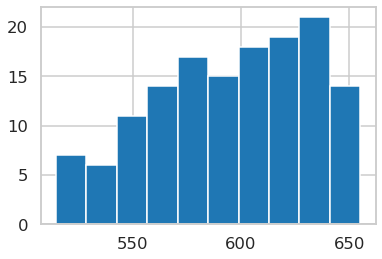

In [656]:
plt.hist(ave_data['psfflux'])

(array([  8.,  88., 104.,   1.,   0.,   0.,   0.,   1.,   1.,   6.]),
 array([ 333.84415,  463.03946,  592.2348 ,  721.4301 ,  850.6254 ,
         979.82074, 1109.0161 , 1238.2114 , 1367.4067 , 1496.602  ,
        1625.7974 ], dtype=float32),
 <a list of 10 Patch objects>)

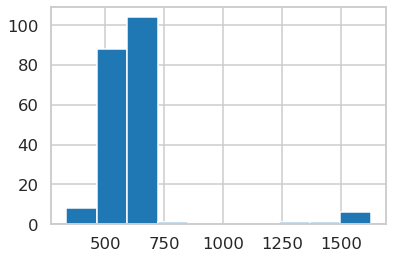

In [657]:
plt.hist(noflag['psfflux'])

(array([  5.,  54., 321.,   0.,   0.,   1.,   3.,   4.,   0.,   1.]),
 array([ 130.26953,  335.11612,  539.9627 ,  744.80927,  949.6559 ,
        1154.5024 , 1359.349  , 1564.1956 , 1769.0422 , 1973.8888 ,
        2178.7354 ], dtype=float32),
 <a list of 10 Patch objects>)

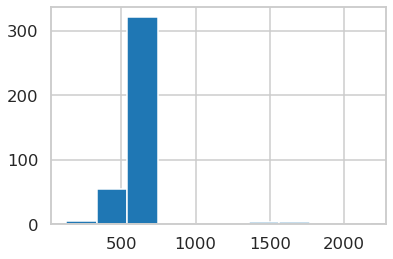

In [658]:
plt.hist(lightcurve_flare['psfflux'])

In [659]:
sig_i = np.nanmedian(pd.Series(noflag['psfflux']).rolling(100, center=True).std())

In [660]:
print(ff.FINDflare(lightcurve_flare['psfflux'],lightcurve_flare['psffluxerr']))
print(ff.FINDflare(noflag['psfflux'],noflag['psffluxerr']))


[[163]
 [170]]
[[163]
 [170]]


In [661]:
stand = np.nanstd(ave_data['psfflux'])
stdv_median = ( np.sum( (ave_data['psfflux'] - np.median(ave_data['psfflux']) )**2 ) / len(ave_data['psfflux']) ) **.5
stdv_mean = ( np.sum( (ave_data['psfflux'] - np.mean(ave_data['psfflux']) )**2 ) / len(ave_data['psfflux']) ) **.5
print(stdv_median, stdv_mean)

36.76739492030068 36.600216041173354


In [662]:
stdv_median_full = ( np.sum( (noflag['psfflux'] - np.median(noflag['psfflux']) )**2 ) / len(noflag['psfflux']) ) **.5
stdv_mean_full = ( np.sum( (noflag['psfflux'] - np.mean(noflag['psfflux']) )**2 ) / len(noflag['psfflux']) ) **.5
print(stdv_median_full,stdv_mean_full)

195.69959768963545 194.33487966534844


In [ ]:
inner_sigma = np.where( (flux > np.percentile(flux,15.9)) & (flux > np.percentile(flux,84.1))
#average_flux = flux[inner_sigma]   
sig_i = np.nanstd(average_flux)

Text(0.5, 1.0, 'Sigma from full data')

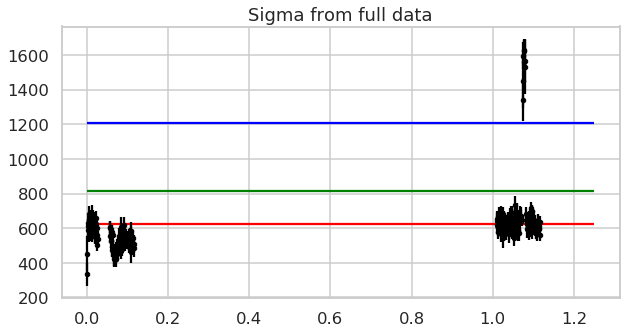

In [663]:
fig = plt.figure(figsize=(10,5))

y_full = noflag['psfflux']
err_full = noflag['psffluxerr']
t_sec_full = (noflag['mjd']-np.min(noflag['mjd']))

plt.hlines(np.mean(noflag['psfflux']),0,1.25,color='red',label='mean')

plt.hlines(np.mean(noflag['psfflux']) + stdv_mean_full,0,1.25,color='green',label='1 sigma')

plt.hlines(np.mean(noflag['psfflux'])+ 3*stdv_mean_full,0,1.25,color='blue', label='3 sigma')


plt.errorbar(t_sec_full,y_full,err_full, color='black', label='ZTF Data', fmt='.')
plt.title('Sigma from full data')

#plt.xlim(0,0.05)

Text(0.5, 1.0, 'Sigma from part of data')

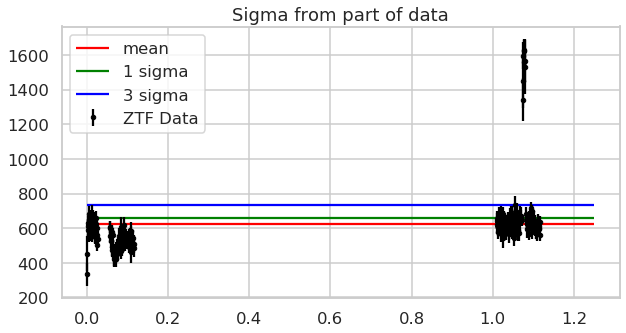

In [664]:
fig = plt.figure(figsize=(10,5))

y_full = noflag['psfflux']
err_full = noflag['psffluxerr']
t_sec_full = (noflag['mjd']-np.min(noflag['mjd']))

plt.hlines(np.mean(noflag['psfflux']),0,1.25,color='red',label='mean')

plt.hlines(np.mean(noflag['psfflux']) + stdv_mean,0,1.25,color='green',label='1 sigma')

plt.hlines(np.mean(noflag['psfflux'])+ 3*stdv_mean,0,1.25,color='blue', label='3 sigma')


plt.errorbar(t_sec_full,y_full,err_full, color='black', label='ZTF Data', fmt='.')
plt.legend()
peak_start = 74
peak_end =81
plt.title('Sigma from part of data')
#plt.xlim(0,0.05)

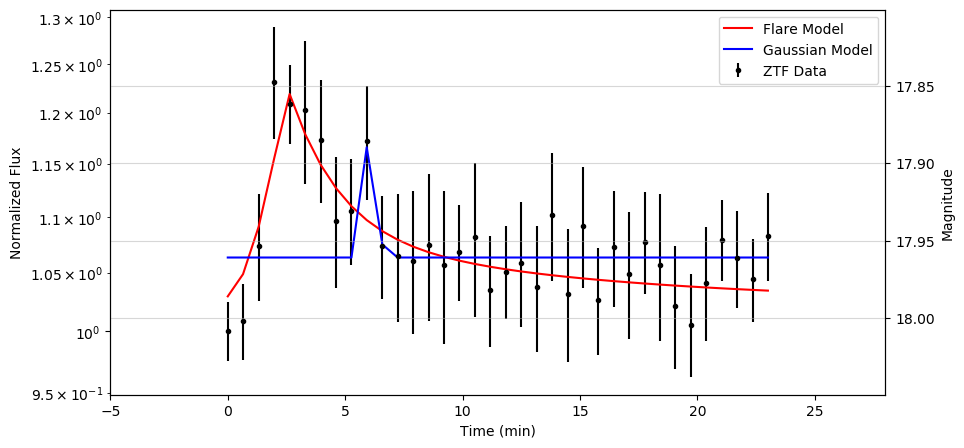

In [446]:

transient = mf.findtransient(lightcurve_flare)
fl_indx = transient['fl_indx'].values[0]
offset, amp, sigma, timepeak, isflare = mf.parameters_guess(lightcurve_flare, fl_indx)
y = lightcurve_flare['psfflux'].values[isflare]
err = lightcurve_flare['psffluxerr'].values[isflare]
t_sec = (lightcurve_flare['mjd'].values[isflare]-np.min(lightcurve_flare['mjd'].values[isflare])) *24*60



y_full = lightcurve_flare['psfflux']
err_full = lightcurve_flare['psffluxerr']
t_sec_full = (lightcurve_flare['mjd']-np.min(lightcurve_flare['mjd'])) *24*60


fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot()

fluxscale = min(y)
ax.errorbar(t_sec,(y/fluxscale),err/fluxscale, color='black', label='ZTF Data', fmt='.')
ax.set_yscale('log')
ax.grid(False)

x_f,y_f,para_f,err_f = mf.fit_flaremodel(lightcurve_flare,fl_indx)
x_g,y_g,para_g,err_g = mf.fit_gauss(lightcurve_flare,fl_indx)
ax.plot(t_sec,y_f/fluxscale,color='red', linestyle='-',label='Flare Model')
ax.plot(t_sec,y_g/fluxscale,color='blue', linestyle='-',label='Gaussian Model')
ax.set_ylabel('Normalized Flux')
ax.set_xlabel('Time (min)')
ax.set_xlim(np.min(t_sec)-5, np.max(t_sec)+5)
#ax.yaxis.set_ticks(np.arange(.9, 1.5, .1))



ax2 = ax.twinx()
ax2.plot(t_sec, lightcurve_flare['mag'].values[isflare], linestyle='none')
ax2.invert_yaxis()
ax2.grid(alpha=.5, linestyle='-')
ax2.set_axisbelow(True)
ax2.set_ylabel('Magnitude')
ax.legend() 


plt.show()

#fig.savefig(f'final_plots/final_lightcurve_{idflare}_final.png', dpi=350)


<ErrorbarContainer object of 3 artists>

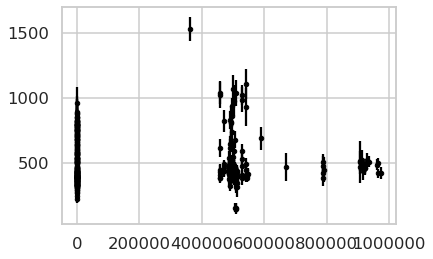

In [394]:
y_full = lightcurve_flare['psfflux']
err_full = lightcurve_flare['psffluxerr']
t_sec_full = (lightcurve_flare['mjd']-np.min(lightcurve_flare['mjd'])) *24*60

plt.errorbar(t_sec_full,y_full,err_full, color='black', label='ZTF Data', fmt='.')
#ax.set_yscale('log')

/epyc/opt/anaconda/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1113: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/epyc/opt/anaconda/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1667: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)


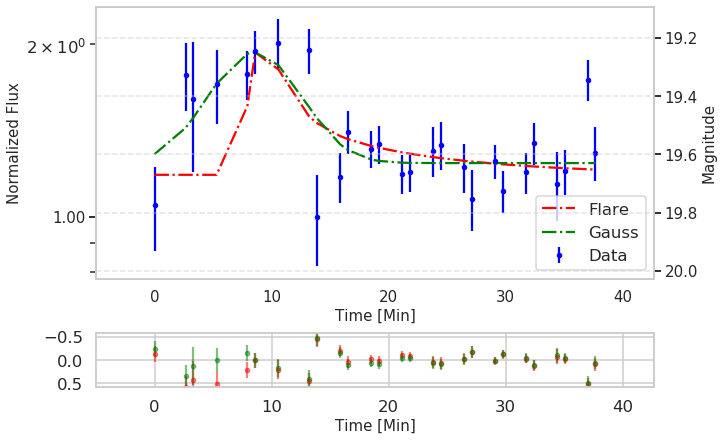

In [377]:
#ids used: 36262, 12173, 4720
#idflare =2286, 54288, 38211
#12173, 38211

transient = mf.findtransient(lightcurve_flare)
fl_indx = transient['fl_indx'].values[0]
offset, amp, sigma, timepeak, isflare = mf.parameters_guess(lightcurve_flare, fl_indx)
y = lightcurve_flare['psfflux'].values[isflare]
err = lightcurve_flare['psffluxerr'].values[isflare]
t_sec = (lightcurve_flare['mjd'].values[isflare]-np.min(lightcurve_flare['mjd'].values[isflare])) *24*60

fig = plt.figure(figsize=(10, 7))
grid = plt.GridSpec(4, 2, hspace=1, wspace=.5)
ax = fig.add_subplot(grid[0:3, 0:2])

fluxscale = min(y)
ax.errorbar(t_sec,(y/fluxscale),err/fluxscale, color='blue',linestyle='none', marker='.', label='Data')
ax.set_yscale('log')
ax.grid(False)

x_f,y_f,para_f,err_f = mf.fit_flaremodel(lightcurve_flare,fl_indx)
x_g,y_g,para_g,err_g = mf.fit_gauss(lightcurve_flare,fl_indx)
ax.plot(t_sec,y_f/fluxscale,color='red', linestyle='-.',label='Flare')
ax.plot(t_sec,y_g/fluxscale,color='green', linestyle='-.',label='Gauss')
#ax.set_title(f'Light Curve for ID = {idflare}')
ax.set_ylabel('Normalized Flux',size=15)
ax.set_xlabel('Time [Min]',size=15)
ax.set_xlim(np.min(t_sec)-5, np.max(t_sec)+5)

ax.tick_params(which='major', length=7, axis='both', labelsize=15)

ax.yaxis.set_major_formatter(ScalarFormatter(useOffset=True))
#ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('%0.1f'))
#ax.yaxis.set_major_formatter(ticker.ScalarFormatter(useOffset=True))
#ax.yaxis.set_major_locator(ticker.IndexLocator(base=1, offset=0))
#ax.yaxis.set_major_locator(ticker.MultipleLocator(2))
#ax.yaxis.set_major_locator(ticker.FixedFormatter(['1', '2']))
#plt.ticklabel_format(style='plain', axis='y')
#ax.yaxis.set_major_formatter(ticker.FixedFormatter(['1', '2']))
ax.legend() 


ax2 = ax.twinx()
ax2.plot(t_sec, lightcurve_flare['mag'].values[isflare], linestyle='none')
ax2.invert_yaxis()
ax2.tick_params(axis='both', labelsize=15, which='major', length=7)
ax2.grid(alpha=0.5, linestyle='--')
ax2.set_axisbelow(True)
ax2.set_ylabel('Magnitude',size=15)


#residuals:
ax_res = fig.add_subplot(grid[3:4, 0:2])
ax_res.errorbar(t_sec, (y - y_f)/fluxscale, err/fluxscale, color='red',linestyle='none', marker='.',label='Flare', alpha=.5)
ax_res.errorbar(t_sec, (y - y_g)/fluxscale, err/fluxscale, color='green',linestyle='none', marker='.',label='Gauss', alpha=.5)
ax_res.hlines(0, np.min(lightcurve_flare['mjd'].values[isflare]), np.max(lightcurve_flare['mjd'].values[isflare]))
maxresid = np.max([np.abs(y - y_f)/fluxscale, np.abs(y - y_g)/fluxscale])
ax_res.set_ylim(maxresid, -1 * maxresid)
ax_res.set_xlabel('Time [Min]',size=15)
ax_res.set_xlim(np.min(t_sec)-5, np.max(t_sec)+5)

plt.show()

#fig.savefig(f'final_plots/final_lightcurve_{idflare}_final.png', dpi=350)


In [290]:
print(lightcurve_flare['psfflux'].values[isflare], np.nanmedian(lightcurve_flare['psfflux']))

[1935.8859 1979.2665 1928.7485 1986.5903 1865.6821 1724.8164 1872.5867
 1799.6792 1736.0049 1665.3212 1600.4619 1676.125  1575.52   1519.7548
 1973.7914 1968.3313 2324.1636 2490.744  2703.9438 2729.0093 2873.7239
 2919.1523 2921.847  2943.4924 2911.0837 2829.001  2416.029  2447.449
 1953.8447 1919.8638 1846.8252 1918.0917 1860.5204 1855.3729 1884.7311
 1946.6414 1935.8859 1926.9683 1977.4398 1957.4563 1981.095  1900.4607
 1821.4172 1824.7848 1833.2306 1903.974  1953.8447 1874.3168 1882.9913
 1884.7311 1988.4254 1896.954  1853.6602 1903.974  1876.0486 1833.2306
 1930.5304 1860.5204 1766.74   1736.0049 1845.1205 1833.2306 1798.0177
 1783.1338 1836.6199] 2065.1414


No handles with labels found to put in legend.


NameError: name 'dirFile' is not defined

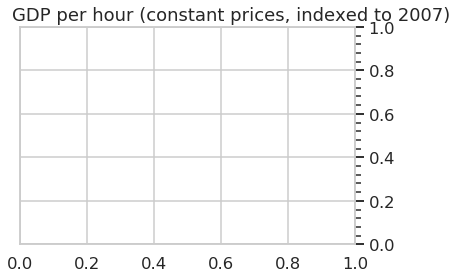

In [329]:
plt.close('all')
fig, ax = plt.subplots()




ax.set_xlabel('')
ax.yaxis.set_major_formatter(ScalarFormatter())
ax.yaxis.major.formatter._useMathText = True
ax.yaxis.set_minor_locator(  AutoMinorLocator(5))
ax.xaxis.set_minor_locator(  AutoMinorLocator(5))
ax.yaxis.set_label_coords(0.63,1.01)
ax.yaxis.tick_right()
nameOfPlot = 'GDP per hour (constant prices, indexed to 2007)'
plt.ylabel(nameOfPlot,rotation=0)
ax.legend(frameon=False, loc='upper left',ncol=2,handlelength=4)
plt.show()

58340.19275461111


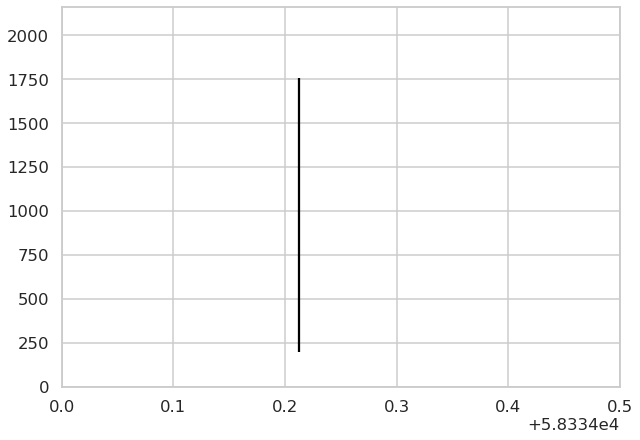

In [243]:
y = lightcurve_flare['psfflux'].values[:]
err = lightcurve_flare['psffluxerr'].values[:]
t_sec = (lightcurve_flare['mjd'].values[:]-np.min(lightcurve_flare['mjd'].values[:])) 

fig = plt.figure(figsize=(10, 7))
#grid = plt.GridSpec(4, 2, hspace=1, wspace=.5)
#ax = fig.add_subplot(grid[0:3, 0:2])

#plt.errorbar(t_sec,y,err, color='blue',linestyle='none', marker='.', label='Data')
plt.errorbar(lightcurve_flare['mjd'].values[:],y,err, color='blue',linestyle='none', marker='.', label='Data')


#plt.ylim(0,50000)
plt.xlim(58334,58334.5)
#i=28
#ax.errorbar(t_sec[:i],y[:i],err[:i], color='blue',linestyle='none', marker='.', label='Data')
#ax.errorbar(t_sec[i:],y[i:],err[i:], color='red',linestyle='none', marker='.', label='Data')
plt.vlines(58334.212476,200,1759)
i=4
plt.scatter(lightcurve_flare['mjd'].values[i],y[i],color='red')
print(lightcurve_flare['mjd'].values[i])
#ax.set_xlim(-.01,.2)
#ax.invert_yaxis()
#ax.set_xlabel('Time (days)')
#ax.set_ylabel('Mag')

ax.grid(False)
plt.show()

In [390]:
f436, f437, f488, f489, f538, f539, f540, f541, f591, f592, f638, f639, f685, f686 = seperate_fields(flare_energy)

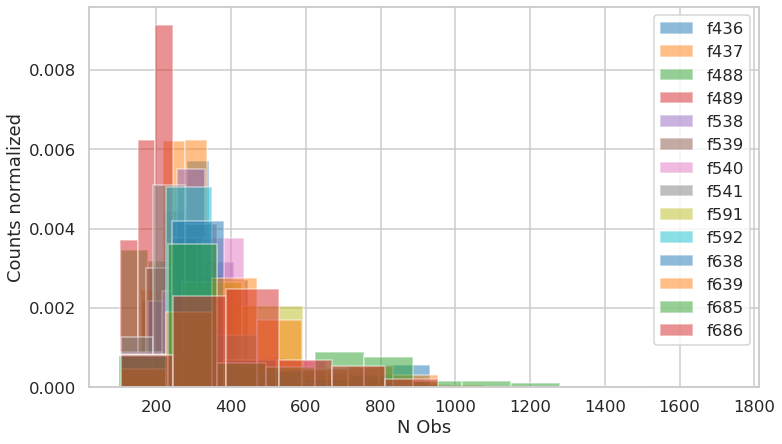

In [624]:
fig = plt.figure(figsize=(12,7))

for i,j in zip([f436, f437, f488, f489, f538, f539, f540, f541, f591, f592, f638, f639, f685, f686],['f436', 'f437', 'f488', 'f489', 'f538', 'f539', 'f540', 'f541', 'f591', 'f592', 'f638', 'f639', 'f685', 'f686']):
    plt.hist(i['ztf_n_obs'],label=j, alpha=.5, density=True)
plt.legend()
plt.xlabel('N Obs')
plt.ylabel('Counts normalized')
plt.show()
    

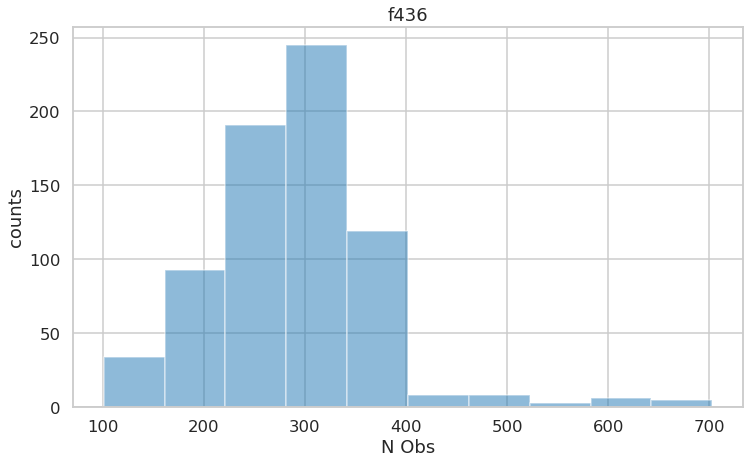

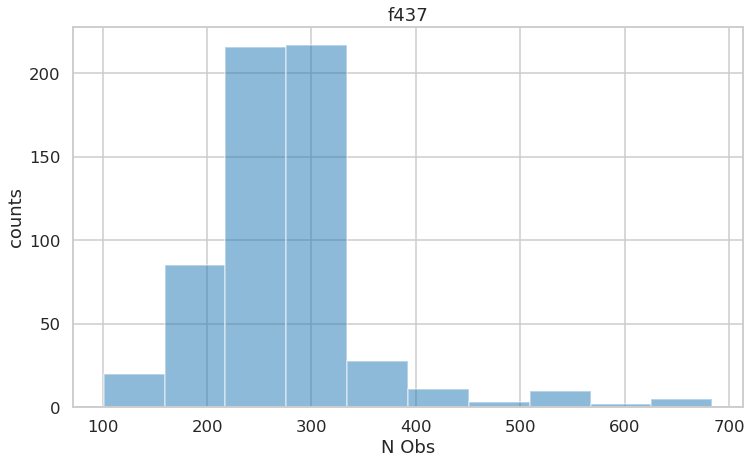

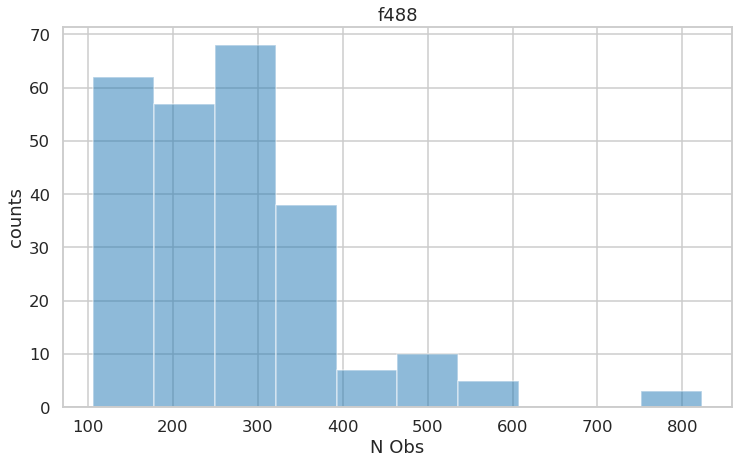

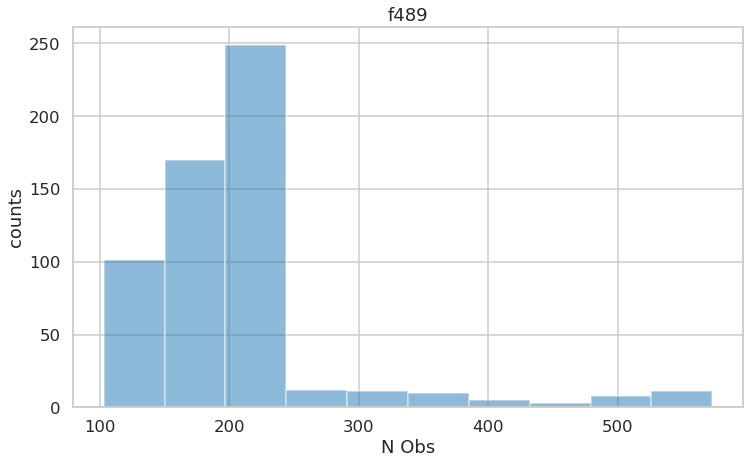

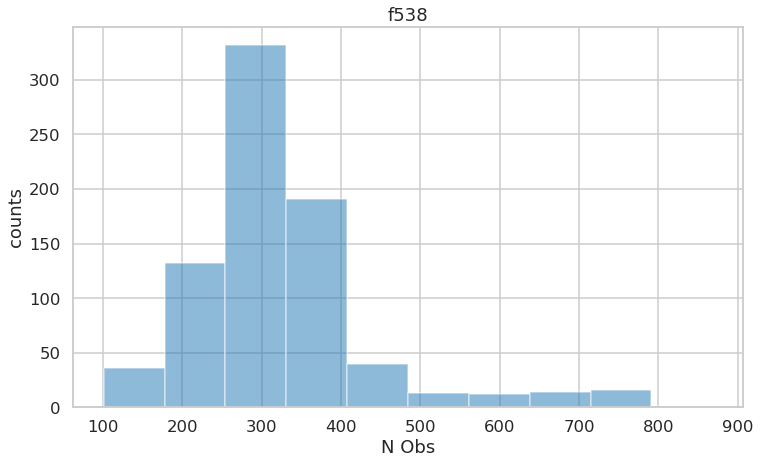

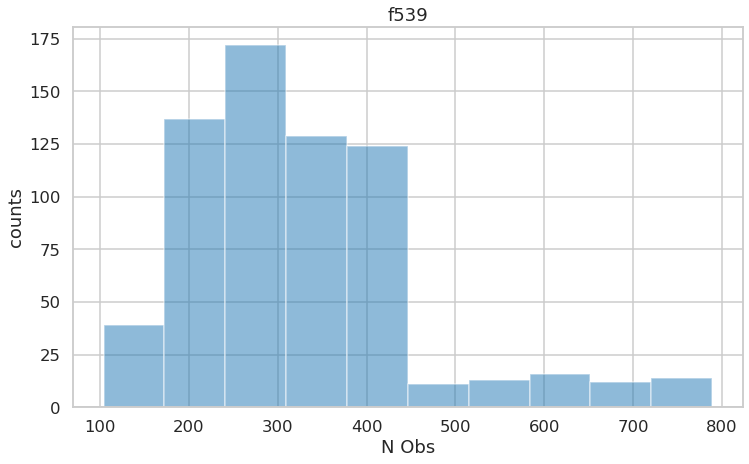

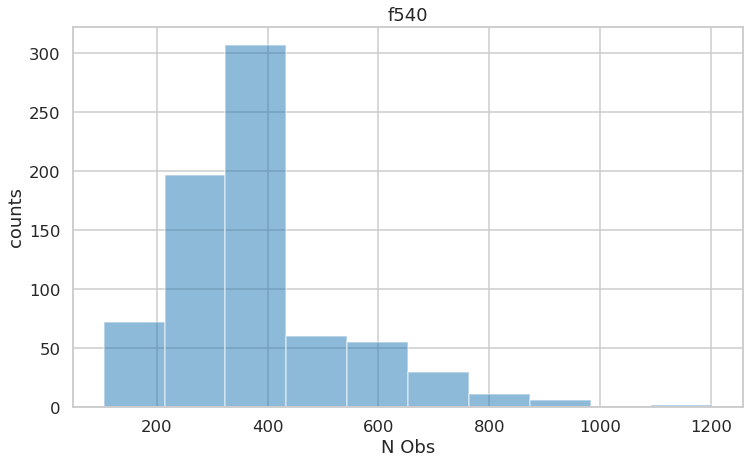

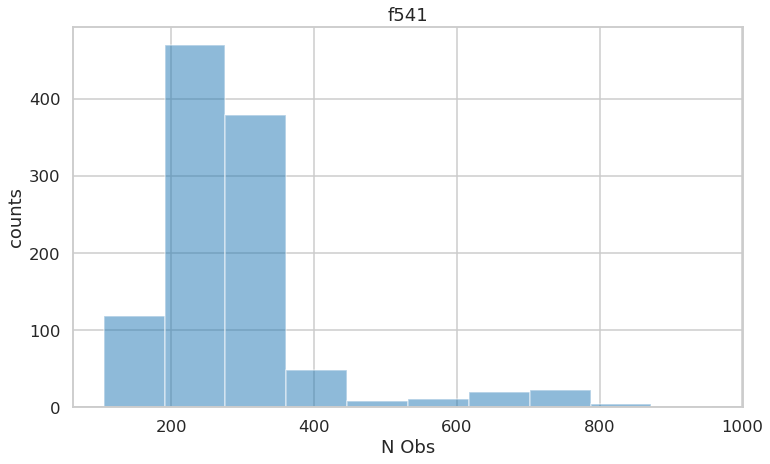

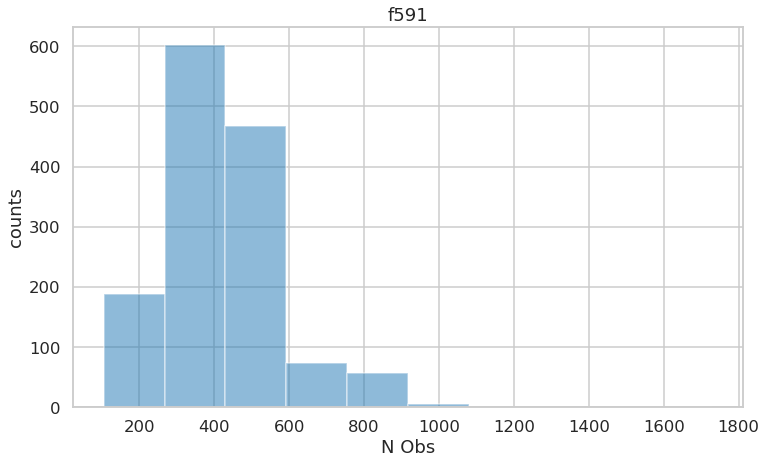

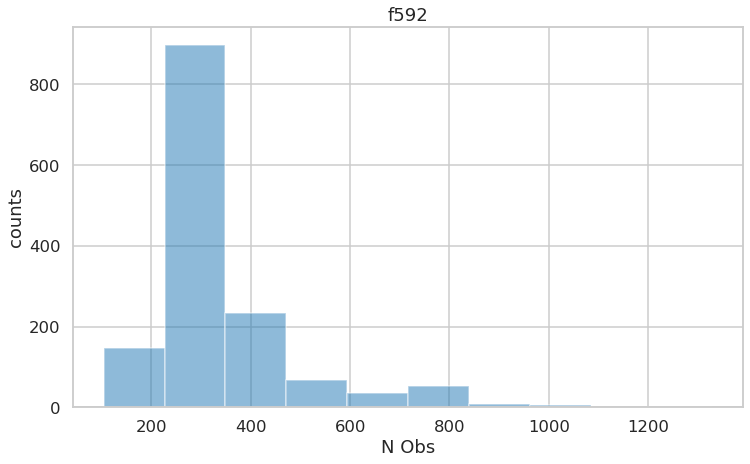

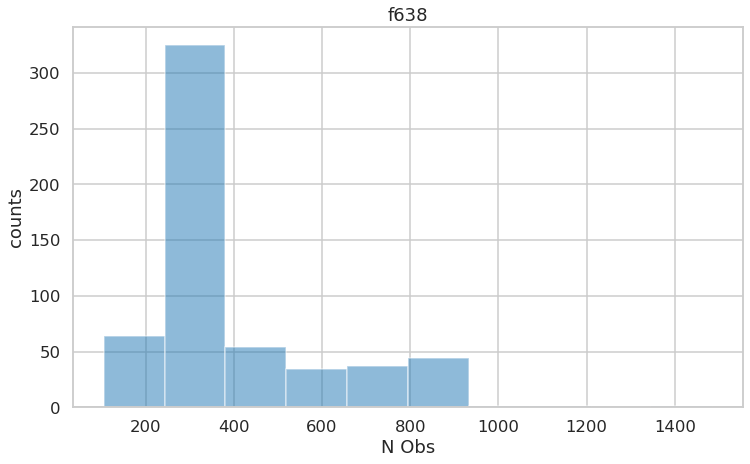

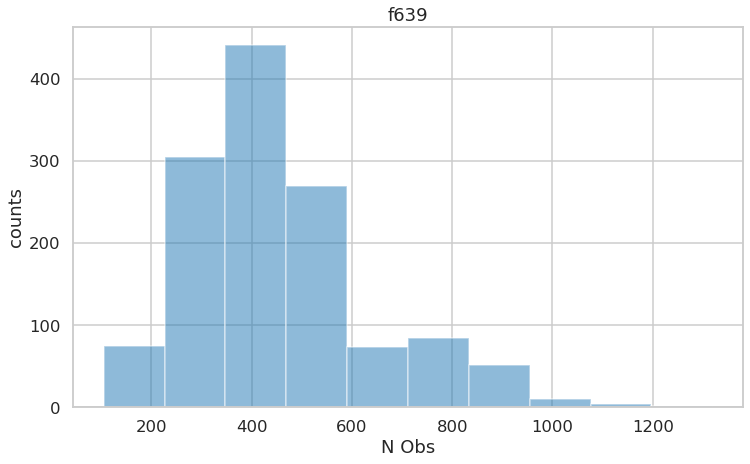

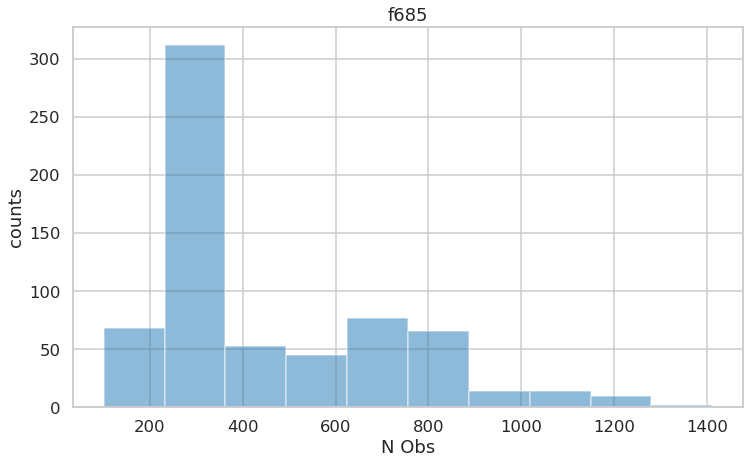

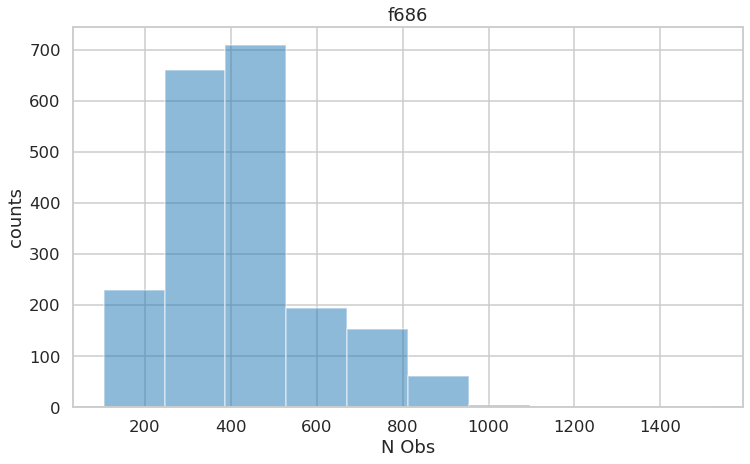

In [623]:

for i,j in zip([f436, f437, f488, f489, f538, f539, f540, f541, f591, f592, f638, f639, f685, f686],['f436', 'f437', 'f488', 'f489', 'f538', 'f539', 'f540', 'f541', 'f591', 'f592', 'f638', 'f639', 'f685', 'f686']):
    fig = plt.figure(figsize=(12,7))
    plt.hist(i['ztf_n_obs'],label=j, alpha=.5)
    plt.title(j)
    plt.xlabel('N Obs')
    plt.ylabel('counts')
    plt.show()
    
    

In [1343]:
print(controltime(lc))

(236, 58343.18984951111, 58344.29820601111)


In [1262]:
#f540.loc[(f540['n_obs'] == 171)]

In [1333]:
lc = pathlightcurve(f591,76236)

In [1284]:
lc2 = pathlightcurve(f592,1952)

In [1344]:
print(controltime(lc2))

(236, 58343.190312511106, 58344.29866901111)


In [1327]:
lc['mjd'].head()

15638638    58343.189850
15638617    58343.190776
15638621    58343.191701
15638629    58343.192627
15638626    58343.193553
Name: mjd, dtype: float64

In [1290]:
lc2['mjd']

405037    58343.190313
405038    58343.191238
405019    58343.192164
405190    58343.193090
405200    58343.194016
              ...     
405127    58486.086296
405171    58486.091204
405130    58486.096111
405103    58846.077801
405076    58846.082651
Name: mjd, Length: 249, dtype: float64

In [ ]:
#take out gap ~45 gap in day 1 (i=30), 2 nights
f436_1 = [117367, 215, 0.19383099999686237]
f436_2 = [12400, 215, 0.19383099999686237]
f436_3 = [112132, 215, 0.19383099999686237]
f436_4 = [97430, 215, 0.19383099999686237]

#take out gap ~45 gap in day 1 (i=28), 2 nights
f437_1 = [12899, 212, 0.19060180000087712]
f437_2 = [81415, 212, 0.19060180000087712]
f437_3 = [11013, 212, 0.19060180000087712]
f437_4 = [64911, 212, 0.19060180000087712]

# 1 night only use t1
f488_1 = [140614, 118, 0.10797460000321735]
f488_2 = [497, 118, 0.10797460000321735]
f488_3 = [144740, 116, 0.10797460000321735]
f488_4 = [81860, 114, 0.10797460000321735]

# 1 night only use t1
f489_1 = [64109, 118, 0.1079745000024559]
f489_2 = [32224, 118, 0.1079745000024559]
f489_3 = [98894, 114, 0.1079745000024559]
f489_4 = [66059, 110, 0.1079745000024559]

#full 2 nights
f538_1 = [34430, 236, 0.16141200000129174]
f538_2 = [77152, 236, 0.16141200000129174]
f538_3 = [62400, 230, 0.16141200000129174]
f538_4 = [3641, 225, 0.16141200000129174]

#full 2 nights, night one was 26.95003200089559 min
f539_1 = [95202, 160, 0.12668989999656333]
f539_2 = [3712, 160, 0.12668989999656333]
f539_3 = [78340, 159, 0.12668989999656333]
f539_4 = [48147, 150, 0.12577549999696203]

#full 2 nights
f540_1 = [116362, 171, 0.15962949999811826]
f540_2 = [38355, 171, 0.15962949999811826]
f540_3 = [184237, 165, 0.15962949999811826]
f540_4 = [139066, 166, 0.15962949999811826]

# Cut the first point corresponding 67 min gap
f541_1 = [42037, 170, 0.15500010000687325]
f541_2 = [33068, 170, 0.15500010000687325]
f541_3 = [29256, 169, 0.15500010000687325]
f541_4 = [74054, 169, 0.15500010000687325]

#full 2 nights
f591_1 = [76236, 236, 0.2183565000013914]
f591_2 = [18167, 236, 0.2183565000013914]
f591_3 = [54847, 235, 0.2183565000013914]
f591_4 = [16326, 235, 0.2183565000013914]

#full 2 nights
f592_1 = [1952, 236, 0.2183565000013914]
f592_2 = [20449, 236, 0.2183565000013914]
f592_3 = [101553, 230, 0.2183565000013914]
f592_4 = [50440, 230, 0.2183565000013914]

#full 2 nights
f638_1 = [86719, 236, 0.22236119999433868]
f638_2 = [55041, 236, 0.22236119999433868]
f638_3 = [70201, 230, 0.22236119999433868]
f638_4 = [41906, 230, 0.22236119999433868]

#full 2 nights
f639_1 = [79100, 236, 0.2223610000073677]
f639_2 = [106738, 236, 0.2223610000073677]
f639_3 = [122330, 236, 0.2223610000073677]
f639_4 = [30012, 236, 0.2223610000073677]

#full 2 nights
f685_1 = [52134, 217, 0.23268530000495957]
f685_2 = [70835, 222, 0.23268530000495957]
f685_3 = [56385, 219, 0.23268530000495957]
f685_4 = [46787, 222, 0.23268530000495957]

#full 2 nights
f686_1 = [19577, 223, 0.23174760000256356]
f686_2 = [66997, 221, 0.23174760000256356]
f686_3 = [27614, 223, 0.23174760000256356]
f686_4 = [19106, 222, 0.23174760000256356]

In [308]:
flare_energy.head()

matchid          ra       dec  ztf_n_obs  \
344  10436122003144  281.913685 -4.657667        104   
53   10436361107415  285.543569 -1.479326        178   
55   10436361131401  285.550429 -1.468019        324   
260  10435162043417  280.828946 -3.476133        289   
202  10435162098109  280.794308 -3.115852        390   

     exploded_unique_matchids_index  unique_matchids_exploded  \
344                               0            10436122003144   
53                                0            10436362042093   
55                                1            10436362128206   
260                               2            10436292069805   
202                               1            10436292101316   

                               match_file      id    aic_flare    chi_flare  \
344  ztf_000436_zr_c04_q1_match_programid    3144  1167.996764  1159.996785   
53   ztf_000436_zr_c10_q1_match_programid   42093  8683.010411  8675.010337   
55   ztf_000436_zr_c10_q1_match_programid  128206  4033.274745  4025.274760   
260  ztf_000436_zr_c08_q2_match_programid   69805  1807.935898  1799.935881   
202  ztf_000436_zr_c08_q2_match_programid  101316   177.405205   169.405203   

     dof_flare   red_flare   aic_gauss   chi_gauss  dof_gauss  red_gauss  \
344         16   72.499799  119.897410  111.897411         16   6.993588   
53          13  667.308487  186.698169  178.698169         13  13.746013   
55          11  365.934069  322.114354  314.114353         11  28.555850   
260         12  149.994657   43.657220   35.657220         12   2.971435   
202          5   33.881041   11.427821    3.427821          5   0.685564   

          exp_comp    perc_comp                    fl_indx       equivdur  \
344  2.559275e-228 -1048.099354                [1 2 3 4 5]   18618.947202   
53    0.000000e+00 -8496.312242  [124 125 126 127 128 129]  582818.995841   
55    0.000000e+00 -3711.160391                 [97 98 99]   77614.526639   
260   0.000000e+00 -1764.278678              [120 121 122]   83010.916554   
202   9.088012e-37  -165.977384                    [1 2 3]    9396.557690   

         xpos      ypos    flare_time      end_time  flare_end_diff  \
344  1905.064   230.482  58347.214641  58347.326678        0.108368   
53   2238.372  2257.195  58348.308264  58348.326643        0.014248   
55   2207.455  2235.024  58348.220486  58348.327107        0.104780   
260  2692.057  2595.457  58348.264618  58348.327107        0.060648   
202  2821.847  1563.277  58347.221979  58348.327107        1.103287   

     n_catflags          axs_id            source_id     bp_rp  \
344           1  10436122003144  4255167728222976384  3.671677   
53            2  10436362042093  4262073829462188288  1.237688   
55            1  10436362128206  4262073863820774272  2.172035   
260           1  10436292069805  4258501035094427520  2.255949   
202           1  10436292101316  4258652144927073792  2.272371   

     phot_g_mean_mag  phot_g_mean_flux_over_error  phot_bp_mean_mag  \
344        18.951912                   358.329407         20.950253   
53         20.225714                   108.845680         20.311474   
55         18.480354                   376.852753         19.311800   
260        19.967255                    99.904900         20.913309   
202        18.725906                   354.998138         19.785688   

     phot_rp_mean_mag  a_g_val  parallax  parallax_error  lum_val  \
344         17.278576      NaN  0.013225        0.291805      NaN   
53          19.073786      NaN -0.377211        1.369174      NaN   
55          17.139765      NaN  0.576118        0.267289      NaN   
260         18.657360      NaN  0.577328        0.681141      NaN   
202         17.513317      NaN  0.294059        0.259517      NaN   

          axsdist      dm_16      E_16     Mr_16  FeH_16      dm_50      E_50  \
344  2.858226e-07  13.102784  2.387583 -0.550000   -0.60  13.696074  2.436318   
53   4.716854e-07  13.126266  0.608647  3.450000   -0.75  13.

Text(0, 0.5, 'Counts')

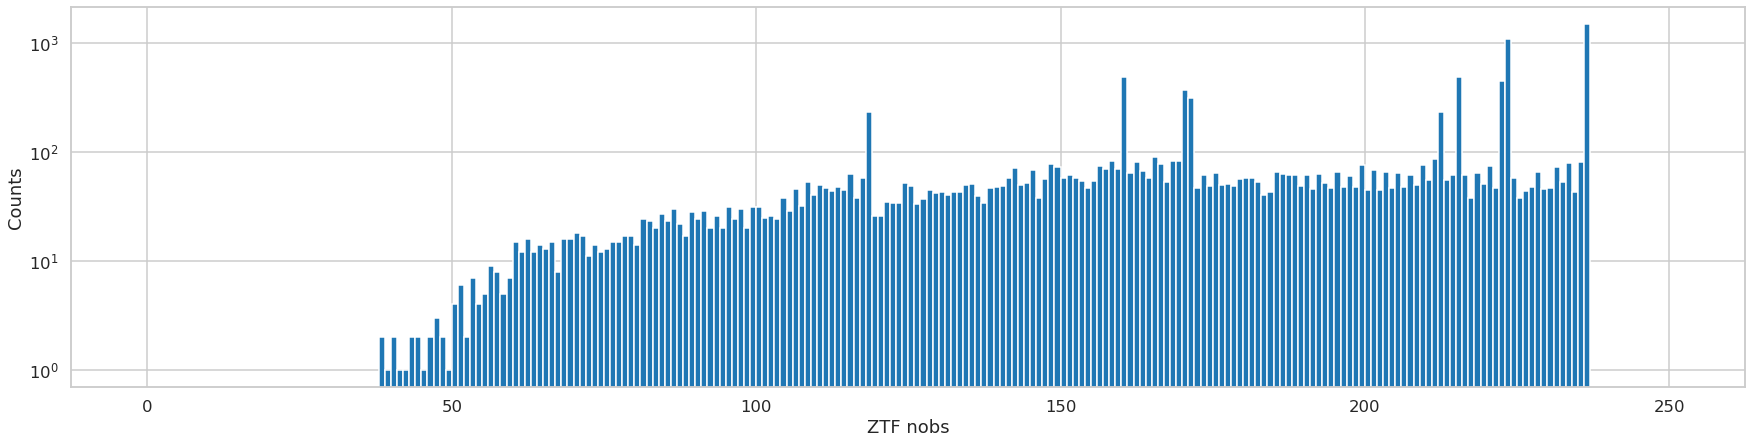

In [310]:
fig = plt.figure(figsize=(30, 7))
plt.hist(flare_energy['nobs'], bins=range(0, 250 + 1, 1), log=True)

plt.xlabel('ZTF nobs')
plt.ylabel('Counts')

In [311]:
np.min(flare_energy['nobs'])

38.0

Text(0, 0.5, 'Counts')

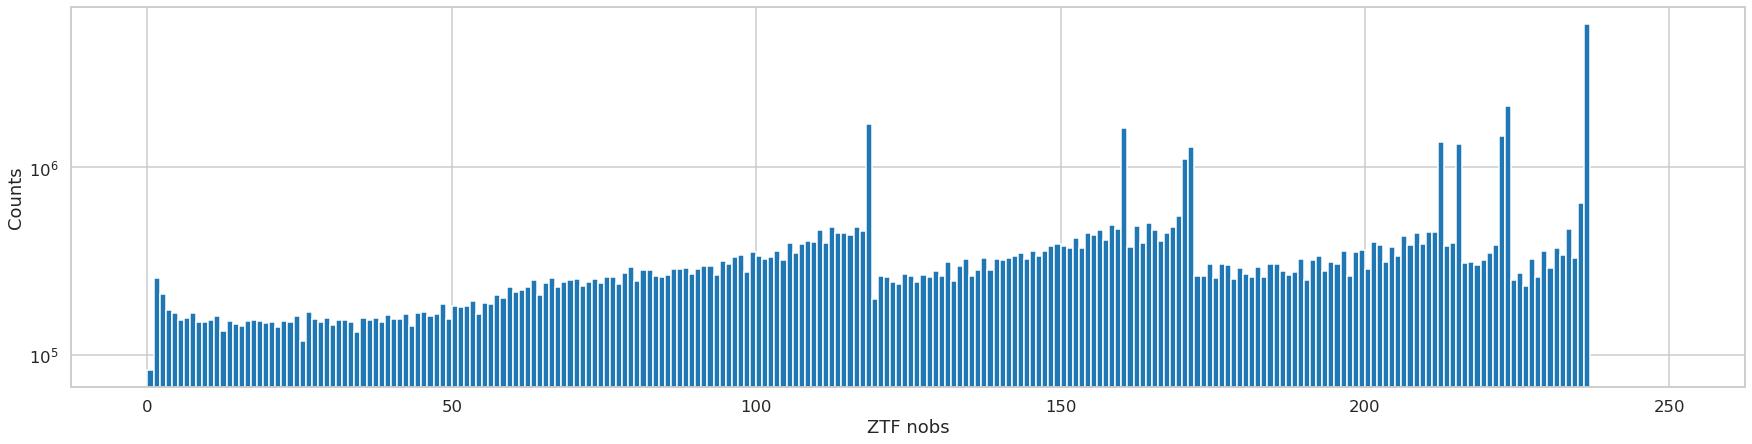

In [309]:
fig = plt.figure(figsize=(30, 7))
plt.hist(green_gaia['nobs'], bins=range(0, 250 + 1, 1), log=True)

plt.xlabel('ZTF nobs')
plt.ylabel('Counts')

In [327]:
len(green_gaia.loc[green_gaia['nobs']<38])

5847139

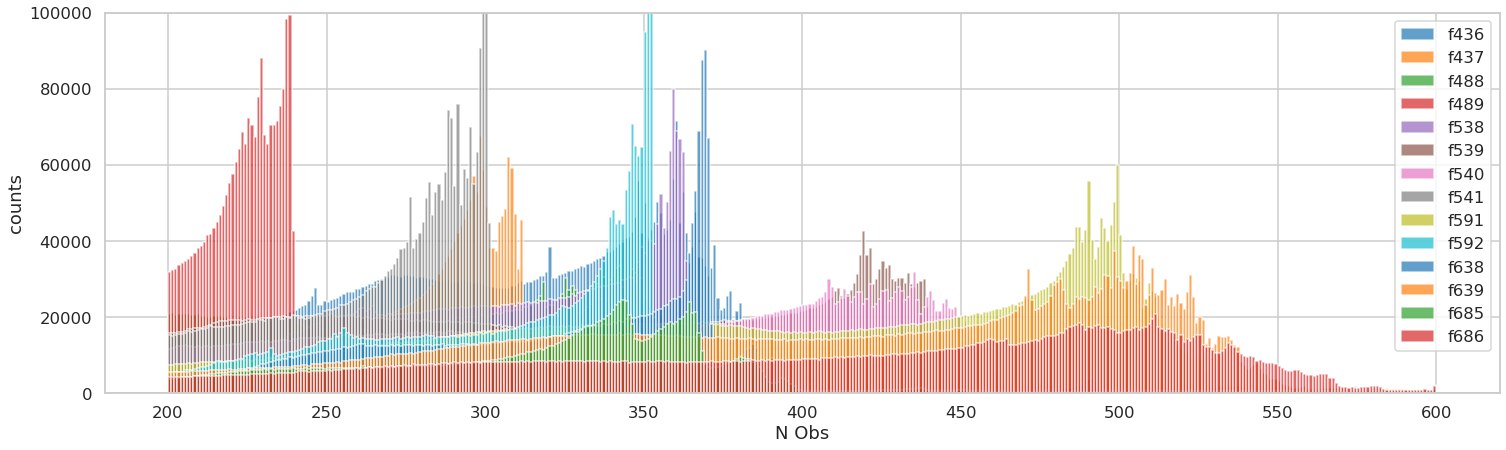

In [1407]:
fig = plt.figure(figsize=(25,7))

for i,j in zip([fall436, fall437, fall488, fall489, fall538, fall539, fall540, fall541, fall591, fall592, fall638, fall639, fall685, fall686],['f436', 'f437', 'f488', 'f489', 'f538', 'f539', 'f540', 'f541', 'f591', 'f592', 'f638', 'f639', 'f685', 'f686']):
    #fig = plt.figure(figsize=(25,7))
    plt.hist(i['ztf_n_obs'], bins=range(200, 600 + 1, 1),label=j, alpha=.7)
#plt.title(j)
plt.legend()
plt.xlabel('N Obs')
plt.ylabel('counts')
plt.ylim(0,100000)
plt.show()
    